# Assignment: Responsible Machine Learning Class by Professor Hall

## Set up & fit models

In [1]:
import datetime                                               # for timestamp 
import time                                                   # for timers

import h2o                                                    # base h2o package for python
from h2o.estimators.gbm import H2OGradientBoostingEstimator   # h2o GBM
from h2o.grid.grid_search import H2OGridSearch                # h2o grid search
from h2o.automl import H2OAutoML                              # h2o auto machine learning models
import math                                                   # math functions

import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation

import xgboost as xgb                                         # base xgboost package for python


# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G', nthreads=NTHREAD) # start h2o with plenty of memory and threads
h2o.remove_all()                              # clears h2o memory
h2o.no_progress()                             # turn off h2o progress indicators    

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         32 mins 52 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.3
H2O_cluster_version_age:    20 days
H2O_cluster_name:           H2O_from_python_minhyekim_0bsnuo
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    5.872 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.5 final
--------------------------  ---------------------------------------------------------

In [2]:
# start global timer
tic = time.time()

In [3]:
# load datasets
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [4]:
# define features to use
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

In [5]:
# 70%/30% train/test split
split_ratio = 0.7 

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112131, columns = 23
Validation data rows = 48207, columns = 23


In [6]:
# convert data to h2o frames
htrain = h2o.H2OFrame(train, column_types={'high_priced':'enum'})
hvalid = h2o.H2OFrame(valid, column_types={'high_priced':'enum'})

In [7]:
# set monotonic constraints for numerical columns
numeric_x_names = ['loan_amount_std', 'loan_to_value_ratio_std', 'intro_rate_period_std',
                   'property_value_std', 'income_std', 'debt_to_income_ratio_std']
mono = tuple([int(i) for i in np.sign(train[numeric_x_names + [y_name]].corr()[y_name].values[:-1])])
numeric_dict = dict(zip(numeric_x_names,mono))

binary_dict = {'conforming': 0, 'debt_to_income_ratio_missing': 0, 'no_intro_rate_period_std': 0, 'term_360': 0}

monotone_constraints = {**numeric_dict, **binary_dict}
monotone_constraints

{'loan_amount_std': -1,
 'loan_to_value_ratio_std': 1,
 'intro_rate_period_std': -1,
 'property_value_std': -1,
 'income_std': -1,
 'debt_to_income_ratio_std': 1,
 'conforming': 0,
 'debt_to_income_ratio_missing': 0,
 'no_intro_rate_period_std': 0,
 'term_360': 0}

### MGBM _ H2O Gradient Boosting Estimator

In [8]:
# preserve exact reproducibility
np.random.seed(SEED)

# start local timer
gbm_tic = time.time()

# train a mgbm model
best_gbm = H2OGradientBoostingEstimator(
    
    ntrees = 10000,                                                            

    ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
    learn_rate = 0.01,                                                         

    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC",                                                  

    ## sample 80% of columns per split
    col_sample_rate = 0.8,                                                   

    ## fix the seed for reproducibility
    seed = SEED,                                                             

    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10,
                                  
    ## monotonic constraints
    monotone_constraints=monotone_constraints)

best_gbm.train(x=x_names, y=y_name, training_frame=htrain, validation_frame=hvalid)

# end local timer
gbm_toc = time.time() - gbm_tic

print('GBM training completed in %.2f s.' % (gbm_toc))

GBM training completed in 74.19 s.


In [9]:
# create a submission file
best_gbm_submit = best_gbm.predict(h2o.H2OFrame(test)).as_data_frame() 
best_gbm_submit.drop(['predict', '0.0'], axis=1, inplace=True)
best_gbm_submit.columns = ['phat']
best_gbm_submit.to_csv('group5_mgbm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### H2O Explain


08:23:23.269: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
08:23:23.270: AutoML: XGBoost is not available; skipping it.



# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id auc logloss aucpr mean_per_class_error rmse mse training_time_ms predict_time_per_row_ms algo 
 
 
 StackedEnsemble_AllModels_AutoML_20210609_082323 0.81866 0.255971 0.289295 0.282199 0.276521 0.0764638 92883 0.015311 StackedEnsemble 
 GBM_3_AutoML_20210609_082323 0.816677 0.267117 0.286996 0.28712 0.278865 0.0777655 1498 0.003264 GBM 
 GBM_2_AutoML_20210609_082323 0.816665 0.266151 0.286315 0.277531 0.278698 0.0776724 1492 0.00198 GBM 
 StackedEnsemble_BestOfFamily_AutoML_20210609_082323 0.816466 0.257508 0.287617 0.287729 0.276952 0.0767026 55682 0.005034 StackedEnsemble 
 GBM_4_AutoML_20210609_082323 0.816005 0.271718 0.283085 0.287914 0.280245 0.0785373 2072 0.001823 GBM 
 GBM_1_AutoML_20210609_082323 0.814832 0.26593 0.285097 0.294263 0.278837 0.0777499 1449 0.001861 GBM 
 GBM_grid__1_AutoML_20210609_082323_model_1 0.814342 0.258589 0.276079 0.284813 0.277516 0.077015 5565 0.006201 GBM 
 GBM_5_AutoML_20210609_082323 0.81185 0.275849 0.274964 0.273088 0.281791 0.0794062 1487 0.001898 GBM 
 GBM_grid__1_AutoML_20210609_082323_model_2 0.808276 0.264145 0.270225 0.296768 0.27899 0.0778357 1754 0.002332 GBM 
 DeepLearning_grid__1_AutoML_20210609_082323_model_1 0.785712 0.278097 0.245245 0.300481 0.281689 0.0793485 795 0.00213 DeepLearning 
 DeepLearning_1_AutoML_20210609_082323 0.784825 0.272417 0.237631 0.296662 0.282385 0.0797412 786 0.001976 DeepLearning 
 DeepLearning_grid__2_AutoML_20210609_082323_model_1 0.778196 0.272549 0.230097 0.319046 0.28269 0.0799136 1470 0.003944 DeepLearning 
 XRT_1_AutoML_20210609_082323 0.771245 0.376371 0.232371 0.281102 0.289624 0.0838818 1360 0.001864 DRF 
 DeepLearning_grid__3_AutoML_20210609_082323_model_1 0.770976 0.275475 0.222645 0.300668 0.28324 0.0802251 2448 0.006001 DeepLearning 
 DRF_1_AutoML_20210609_082323 0.764507 0.514507 0.228501 0.288042 0.294222 0.0865666 1869 0.002453 DRF 
 GLM_1_AutoML_20210609_082323 0.751177 0.299234 0.219638 0.331362 0.290068 0.0841397 5190 0.000755 GLM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210609_082323


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1741866084526511: 


0.0     1.0   Error              Rate
0    0.0  7331.0  1608.0  0.1799   (1608.0/8939.0)
1    1.0   333.0   653.0  0.3377     (333.0/986.0)
2  Total  7664.0  2261.0  0.1956   (1941.0/9925.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

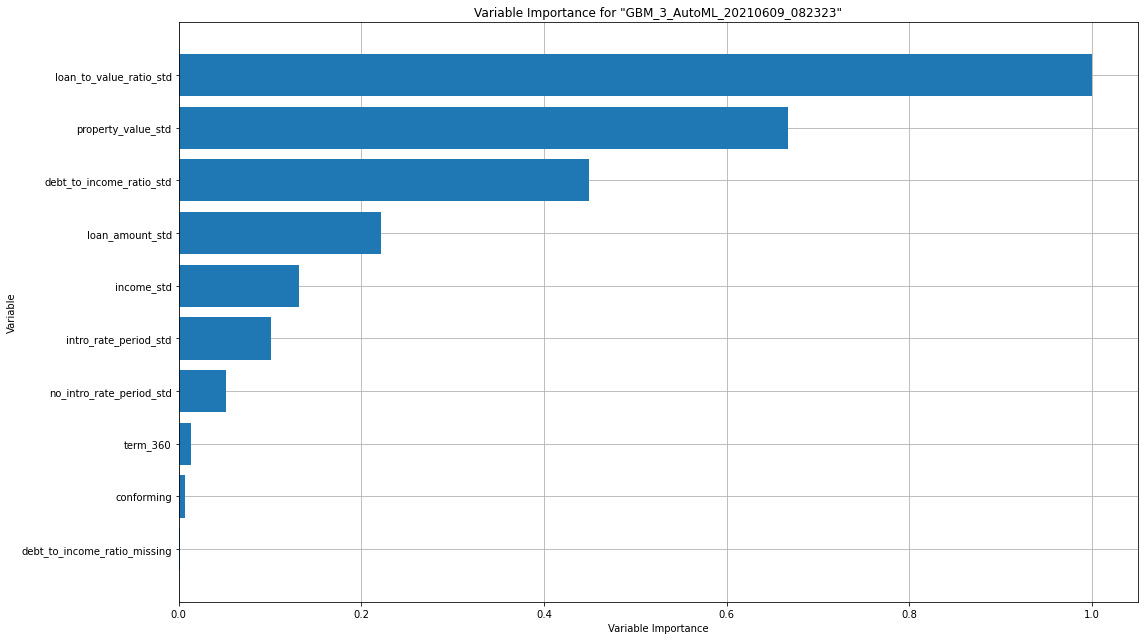

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

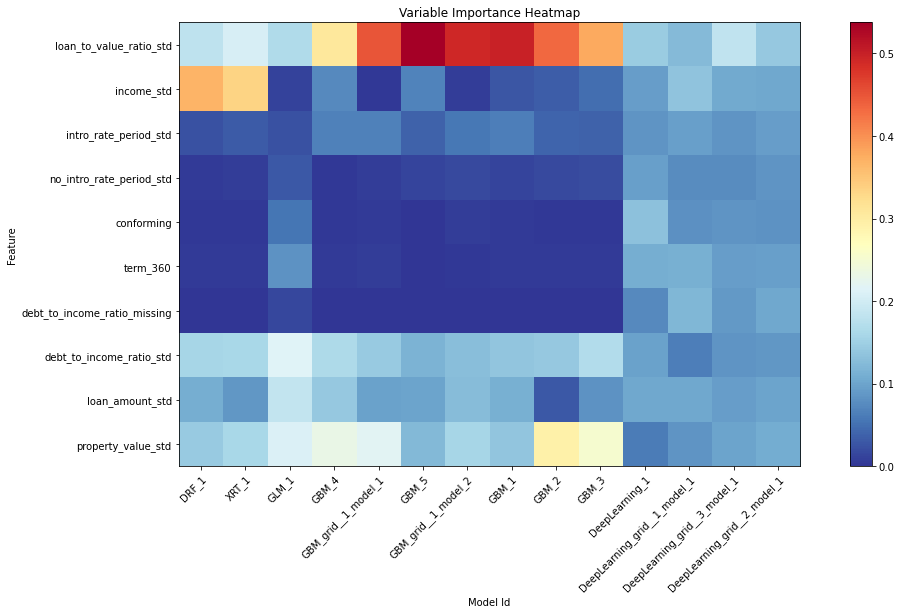

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

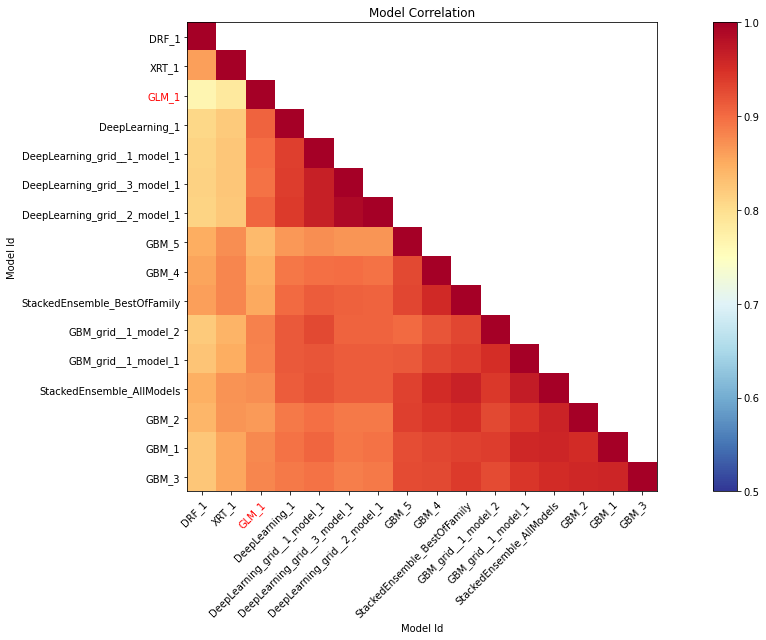

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

C:\Users\minhyekim\Anaconda3\lib\site-packages\h2o\explanation\_explain.py:514: RuntimeWarning: invalid value encountered in true_divide
  res = (res - np.nanmin(res)) / (np.nanmax(res) - np.nanmin(res))


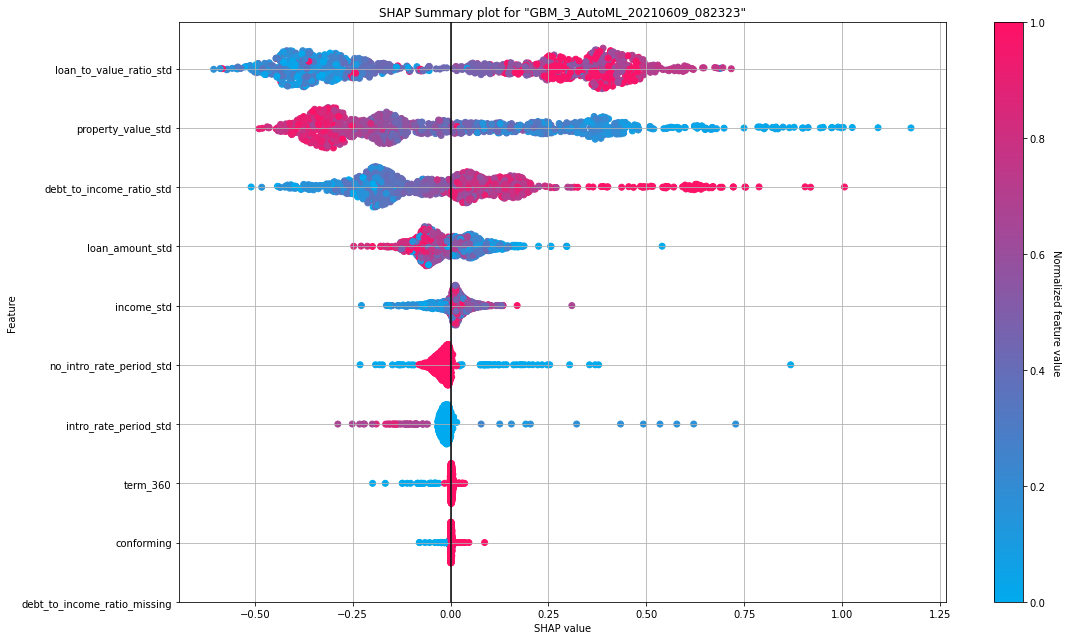

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

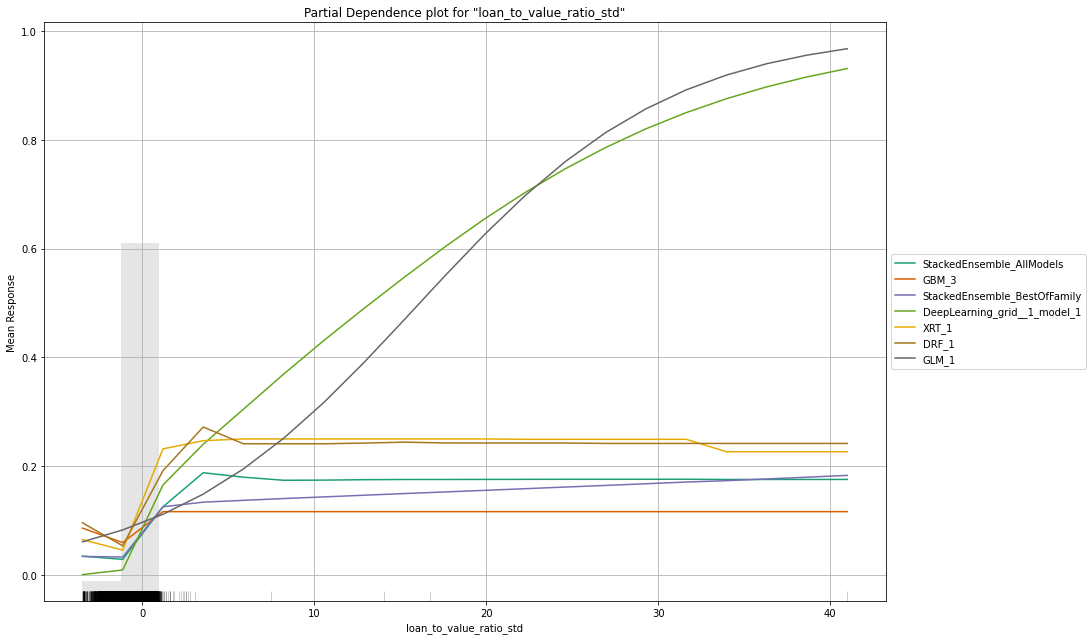

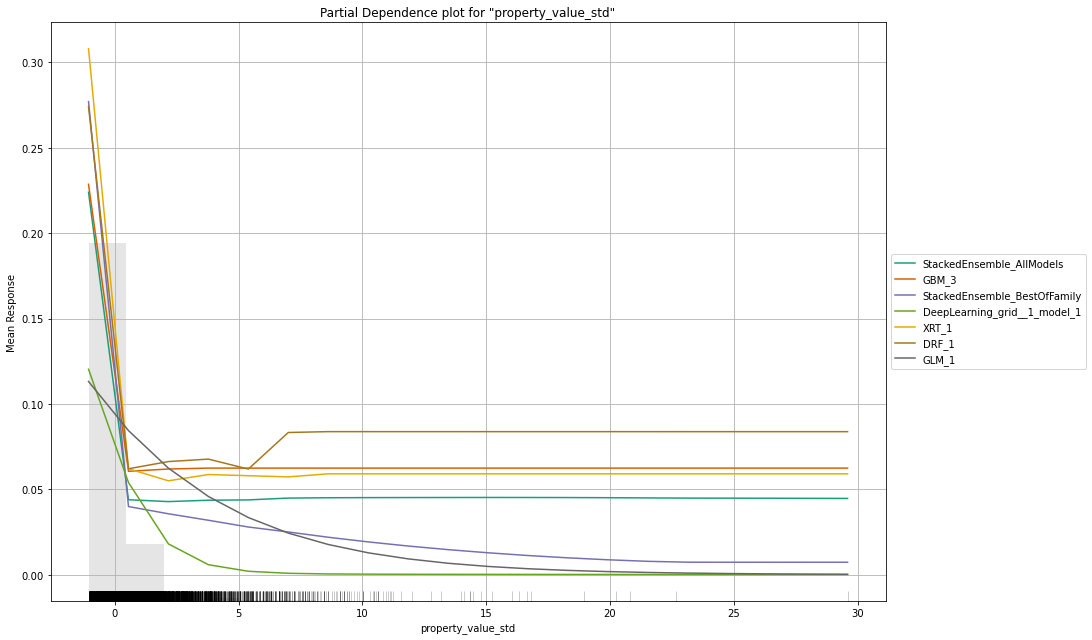

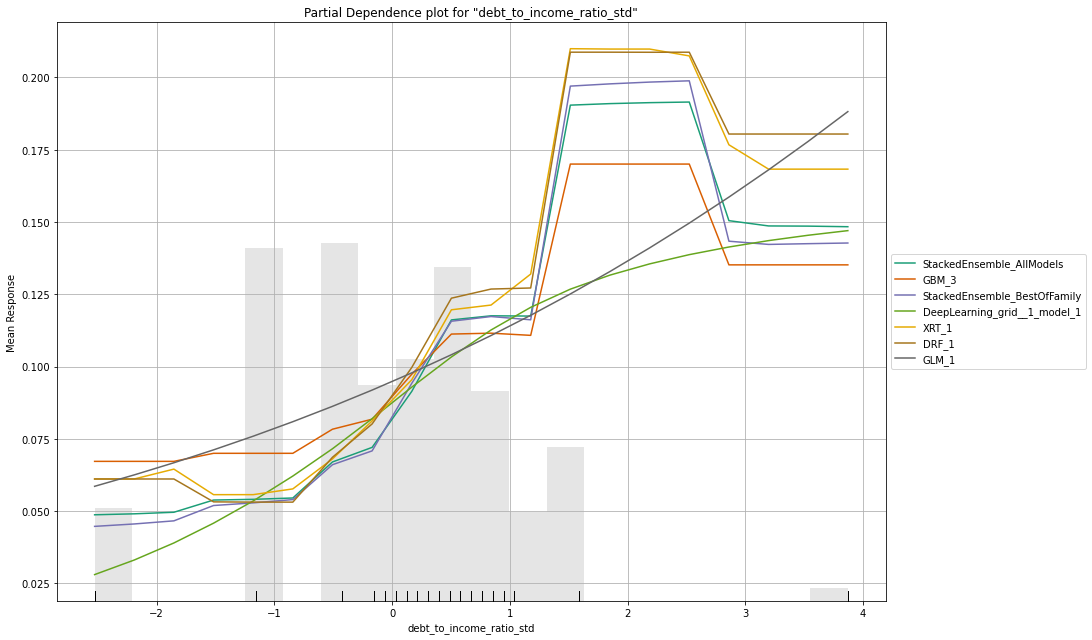

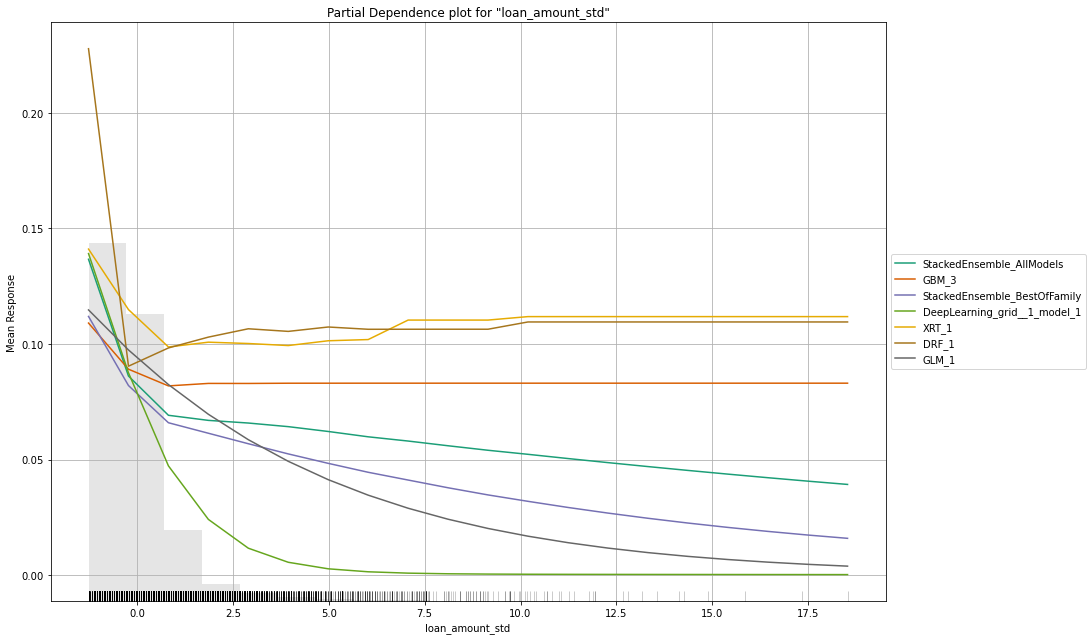

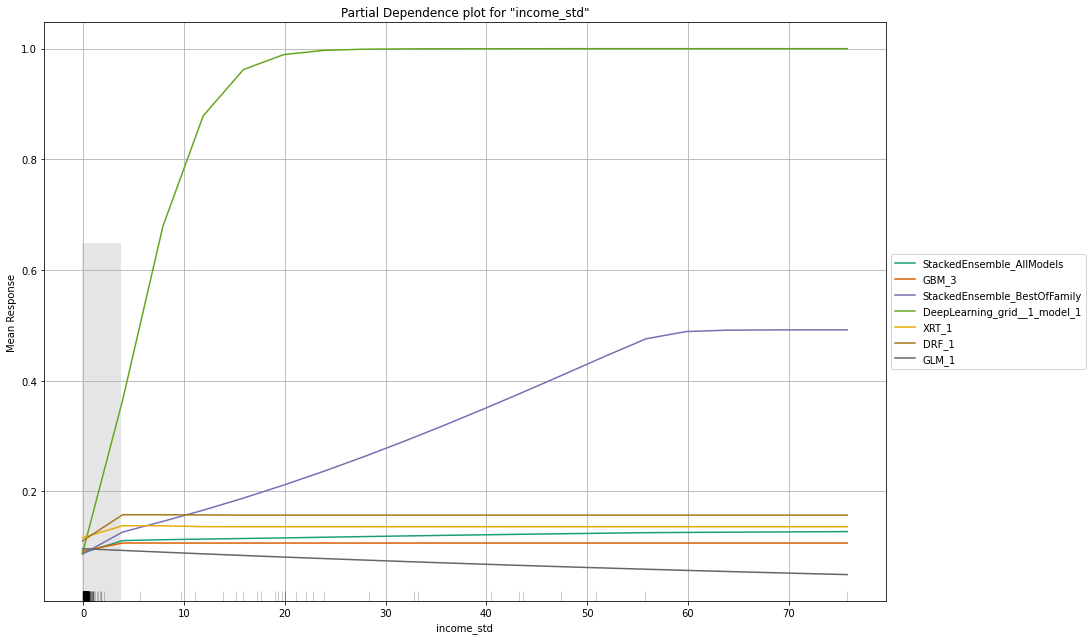

In [10]:
# preserve exact reproducibility
np.random.seed(SEED)

# use top models for submission

# Run AutoML for 3 minutes
aml = H2OAutoML(max_runtime_secs=180, seed=SEED)
aml.train(x=x_names, y=y_name, training_frame=htrain, validation_frame=hvalid)

# Explain leader model & compare with all AutoML models
exa = aml.explain(hvalid)

In [11]:
lb = aml.leaderboard
lb

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 StackedEnsemble_AllModels_AutoML_20210609_082323 0.81866 0.255971 0.289295 0.282199 0.276521 0.0764638 
 GBM_3_AutoML_20210609_082323 0.816677 0.267117 0.286996 0.28712 0.278865 0.0777655 
 GBM_2_AutoML_20210609_082323 0.816665 0.266151 0.286315 0.277531 0.278698 0.0776724 
 StackedEnsemble_BestOfFamily_AutoML_20210609_082323 0.816466 0.257508 0.287617 0.287729 0.276952 0.0767026 
 GBM_4_AutoML_20210609_082323 0.816005 0.271718 0.283085 0.287914 0.280245 0.0785373 
 GBM_1_AutoML_20210609_082323 0.814832 0.26593 0.285097 0.294263 0.278837 0.0777499 
 GBM_grid__1_AutoML_20210609_082323_model_1 0.814342 0.258589 0.276079 0.284813 0.277516 0.077015 
 GBM_5_AutoML_20210609_082323 0.81185 0.275849 0.274964 0.273088 0.281791 0.0794062 
 GBM_grid__1_AutoML_20210609_082323_model_2 0.808276 0.264145 0.270225 0.296768 0.27899 0.0778357 
 DeepLearning_grid__1_AutoML_20210609_082323_model_1 0.785712 0.278097 0.245245 0.300481 0.281689 0.0793485

### ENSENBLE _ H2O AUTOML

In [12]:
ensenble_h2o = h2o.get_model(lb[0,"model_id"])

In [13]:
# create a submission file
ensenble_submit = ensenble_h2o.predict(h2o.H2OFrame(test)).as_data_frame() 
ensenble_submit.drop(['predict', '0.0'], axis=1, inplace=True)
ensenble_submit.columns = ['phat']
ensenble_submit.to_csv('group5_ensenble_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

### GBM _ H2O AUTOML

In [14]:
gbm_h2o = h2o.get_model(lb[2,"model_id"])

In [15]:
# create a submission file
gbm_submit = gbm_h2o.predict(h2o.H2OFrame(test)).as_data_frame() 
gbm_submit.drop(['predict', '0.0'], axis=1, inplace=True)
gbm_submit.columns = ['phat']
gbm_submit.to_csv('group5_gbm_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'), 
                       index=False)

## Calculate and Plot Global Feature Importance.

### MGBM

In [16]:
import shap

shap.initjs()

In [17]:
# must convert from Pandas to H2OFrame ... and back again ... wasteful
shap_contribs_hf = best_gbm.predict_contributions(h2o.H2OFrame(valid))
shap_contribs_matrix = shap_contribs_hf.as_data_frame().values
print(shap_contribs_matrix)
print('\nShapley contributions rows = %d, columns = %d' % (shap_contribs_matrix.shape[0], shap_contribs_matrix.shape[1]))

[[ 2.84214802e-02  7.87373167e-03 -3.35506629e-04 ...  1.75908096e-02
   3.14095497e-01 -2.93035436e+00]
 [ 2.45479662e-02  8.89241695e-03 -3.35531746e-04 ...  1.28546264e-02
   2.79806346e-01 -2.93035436e+00]
 [ 3.60911824e-02  1.04340911e-02 -3.41544393e-04 ...  1.21990619e-02
   2.06641912e-01 -2.93035436e+00]
 ...
 [ 3.14708576e-02  1.61613021e-02 -3.52587289e-04 ...  1.39622148e-02
   2.01121360e-01 -2.93035436e+00]
 [ 2.78528649e-02  8.99048429e-03 -3.36504367e-04 ...  1.21000316e-02
   4.74840850e-02 -2.93035436e+00]
 [ 3.35829593e-02 -1.28238052e-01 -3.50681134e-04 ... -3.83763872e-02
   2.41965562e-01 -2.93035436e+00]]

Shapley contributions rows = 48207, columns = 11


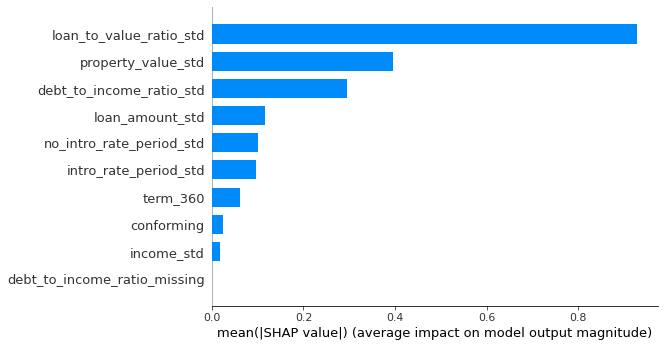

In [18]:
shap_contribs = shap_contribs_matrix[:,:-1] # remove constant intercept column
shap.summary_plot(shap_contribs, x_names, plot_type='bar', title='Variable Importance: MGBM') # use shap package for nice bar plot

### GBM

In [19]:
gbm_h2o

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20210609_082323


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               12.0                      12.0              17664.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        7.0        7.0         7.0       108.0       122.0   112.666664



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.0766858969772717
RMSE: 0.2769221857801785
LogLoss: 0.2624930553047788
Mean Per-Class Error: 0.23568941379377506
AUC: 0.8292560969961295
AUCPR: 0.3194110437245225
Gini: 0.6585121939922589

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16179220547030526: 


0.0      1.0   Error                 Rate
0    0.0  83984.0  17287.0  0.1707   (17287.0/101271.0)
1    1.0   4326.0   6534.0  0.3983     (4326.0/10860.0)
2  Total  88310.0  23821.0  0.1927   (21613.0/112131.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.161792       0.376806  183.0
1                        max f2   0.110191       0.541946  252.0
2                  max f0point5   0.216479       0.334805  115.0
3                  max accuracy   0.342811       0.904406   43.0
4                 max precision   0.599219       1.000000    0.0
5                    max recall   0.032945       1.000000  398.0
6               max specificity   0.599219       1.000000    0.0
7              max absolute_mcc   0.129775       0.327737  226.0
8    max min_per_class_accuracy   0.137141       0.750916  216.0
9   max mean_per_class_accuracy   0.109344       0.764311  253.0
10                      max tns   0.599219  101271.000000    0.0
11                      max fns   0.599219   10854.000000    0.0
12                      max fps   0.032677  101271.000000  399.0
13                      max tps   0.032945   10860.000000  398.0
14                      max tnr   0.599219       1.000000    0.0
15                      max fnr   0.599219       0.999448    0.0
16                      max fpr   0.032677       1.000000  399.0
17                      max tpr   0.032945       1.000000  398.0


Gains/Lift Table: Avg response rate:  9.69 %, avg score:  9.80 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010051         0.302410  5.570261   
1       2                  0.020039         0.272450  4.139274   
2       3                  0.030206         0.252832  3.713427   
3       4                  0.040007         0.236480  3.335236   
4       5                  0.053741         0.231610  3.184702   
5       6                  0.100311         0.199167  2.791860   
6       7                  0.150280         0.179435  2.447222   
7       8                  0.200025         0.165807  2.239766   
8       9                  0.300060         0.136249  1.807843   
9      10                  0.400112         0.095432  1.203786   
10     11                  0.500040         0.065385  0.642269   
11     12                  0.600271         0.049654  0.276525   
12     13                  0.700003         0.041020  0.158806   
13     14                  0.800555         0.037132  0.083334   
14     15                  0.900197         0.034725  0.047130   
15     16                  1.000000         0.032406  0.026756   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          5.570261       0.539485  0.346838                  0.539485   
1          4.856996       0.400893  0.286718                  0.470405   
2          4.472093       0.359649  0.260746                  0.433127   
3          4.193580       0.323021  0.245085                  0.406152   
4          3.935752       0.308442  0.233066                  0.381182   
5          3.404689       0.270394  0.212904                  0.329748   
6          3.086328       0.237016  0.187301                  0.298914   
7          2.875792       0.216924  0.172547                  0.278523   
8          2.519756       0.175091  0.150271                  0.244041   
9          2.190683       0.116588  0.116332                  0.212170   
10         1.881249       0.062204  0.079526                  0.182201   
11         1.613298       0.026782  0.056134                  0.156250   
12         1.406072       0.015380  0.045122                  0.136179   
13         1.239932       0.008071  0.038798                  0.120089   
14         1.107901       0.004565  0.035761                  0.107301   
15         1.000000       0.002591  0.033634                  0.096851   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.346838      0.055985                 0.055985  457.026085   
1           0.316871      0.041344                 0.097330  313.927412   
2           0.297981      0.037753                 0.135083  271.342687   
3           0.285022      0.032689                 0.167772  233.523570   
4           0.271744      0.043738                 0.211510  218.470169   
5           0.244427      0.130018                 0.341529  179.186040   
6           0.225433      0.122284                 0.463812  144.722174   
7           0.212280      0.111418                 0.575230  123.976643   
8           0.191607      0.180847                 0.756077   80.784267   
9           0.172784      0.120442                 0.876519   20.378649   
10          0.154147      0.064180                 0.940700  -35.773126   
11          0.137781      0.027716                 0.968416  -72.347481   
12          0.124580      0.015838                 0.984254  -84.119433   
13          0.113806      0.008379                 0.992634  -91.666629   
14          0.105167      0.004696                 0.997330  -95.287013   
15          0.098028      0.002670                 1.000000  -97.324377   

    cumulative_gain  kolmogorov_smirnov  
0        457.026085            0.050860  
1        385.699644            0.085579  
2        347.209260            0.116124  
3        319.358040            0.141466  
4        293.575212            0.174688  
5        240.468859            0.267085  
6        208.632845            0.347155  
7        1



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.07747848683255448
RMSE: 0.2783495766703346
LogLoss: 0.2656280896361889
Mean Per-Class Error: 0.2445085902334665
AUC: 0.8167347342409262
AUCPR: 0.2819205954400744
Gini: 0.6334694684818525

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14551447018772484: 


0.0      1.0   Error                Rate
0    0.0  33942.0   9620.0  0.2208    (9620.0/43562.0)
1    1.0   1504.0   3141.0  0.3238     (1504.0/4645.0)
2  Total  35446.0  12761.0  0.2308   (11124.0/48207.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold         value    idx
0                        max f1   0.145514      0.360910  202.0
1                        max f2   0.097724      0.528993  265.0
2                  max f0point5   0.180722      0.300943  152.0
3                  max accuracy   0.378448      0.904101   27.0
4                 max precision   0.599231      1.000000    0.0
5                    max recall   0.032937      1.000000  398.0
6               max specificity   0.599231      1.000000    0.0
7              max absolute_mcc   0.131173      0.312564  222.0
8    max min_per_class_accuracy   0.134470      0.741495  217.0
9   max mean_per_class_accuracy   0.097724      0.755491  265.0
10                      max tns   0.599231  43562.000000    0.0
11                      max fns   0.599231   4643.000000    0.0
12                      max fps   0.032672  43562.000000  399.0
13                      max tps   0.032937   4645.000000  398.0
14                      max tnr   0.599231      1.000000    0.0
15                      max fnr   0.599231      0.999569    0.0
16                      max fpr   0.032672      1.000000  399.0
17                      max tpr   0.032937      1.000000  398.0


Gains/Lift Table: Avg response rate:  9.64 %, avg score:  9.77 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010227         0.302526  4.736527   
1       2                  0.020059         0.271421  3.481314   
2       3                  0.031510         0.251966  3.139799   
3       4                  0.041799         0.235614  3.117662   
4       5                  0.052855         0.231610  3.193310   
5       6                  0.100214         0.199102  2.577517   
6       7                  0.150414         0.179435  2.500216   
7       8                  0.200158         0.165190  2.259153   
8       9                  0.300454         0.135824  1.882468   
9      10                  0.400046         0.094473  1.275395   
10     11                  0.500010         0.064925  0.721460   
11     12                  0.600017         0.049261  0.333671   
12     13                  0.700002         0.040904  0.193785   
13     14                  0.800299         0.037186  0.064395   
14     15                  0.900015         0.034687  0.045339   
15     16                  1.000000         0.032406  0.023685   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.736527       0.456389  0.345269                  0.456389   
1          4.121252       0.335443  0.286386                  0.397104   
2          3.764595       0.302536  0.258761                  0.362739   
3          3.605350       0.300403  0.241237                  0.347395   
4          3.519158       0.307692  0.232389                  0.339089   
5          3.074164       0.248357  0.212879                  0.296212   
6          2.882610       0.240909  0.187324                  0.277755   
7          2.727667       0.217681  0.172384                  0.262825   
8          2.445525       0.181386  0.149822                  0.235639   
9          2.154221       0.122891  0.115512                  0.207571   
10         1.867776       0.069516  0.078961                  0.179970   
11         1.612083       0.032151  0.055734                  0.155333   
12         1.409499       0.018672  0.044883                  0.135813   
13         1.240925       0.006205  0.038811                  0.119570   
14         1.108462       0.004369  0.035776                  0.106806   
15         1.000000       0.002282  0.033633                  0.096355   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.345269      0.048439                 0.048439  373.652666   
1           0.316406      0.034230                 0.082670  248.131379   
2           0.295458      0.035953                 0.118622  213.979852   
3           0.282111      0.032078                 0.150700  211.766164   
4           0.271710      0.035307                 0.186006  219.330960   
5           0.243908      0.122067                 0.308073  157.751698   
6           0.225023      0.125511                 0.433584  150.021626   
7           0.211941      0.112379                 0.545963  125.915335   
8           0.191205      0.188805                 0.734769   88.246757   
9           0.172361      0.127018                 0.861787   27.539495   
10          0.153688      0.072121                 0.933907  -27.853998   
11          0.137362      0.033369                 0.967277  -66.632862   
12          0.124153      0.019376                 0.986652  -80.621513   
13          0.113457      0.006459                 0.993111  -93.560544   
14          0.104851      0.004521                 0.997632  -95.466125   
15          0.097730      0.002368                 1.000000  -97.631518   

    cumulative_gain  kolmogorov_smirnov  
0        373.652666            0.042287  
1        312.125168            0.069286  
2        276.459458            0.096401  
3        260.534954            0.120513  
4        251.915751            0.147349  
5        207.416365            0.230024  
6        188.261039            0.313365  
7        1



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07767236247810895
RMSE: 0.2786976183574394
LogLoss: 0.26615108135097776
Mean Per-Class Error: 0.24346315102996718
AUC: 0.8166654910016344
AUCPR: 0.2863145935570221
Gini: 0.6333309820032689

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14820720954388647: 


0.0      1.0   Error                 Rate
0    0.0  79982.0  21289.0  0.2102   (21289.0/101271.0)
1    1.0   3745.0   7115.0  0.3448     (3745.0/10860.0)
2  Total  83727.0  28404.0  0.2233   (25034.0/112131.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold          value    idx
0                        max f1   0.148207       0.362419  203.0
1                        max f2   0.103898       0.532356  255.0
2                  max f0point5   0.196903       0.310781  139.0
3                  max accuracy   0.381698       0.903479   33.0
4                 max precision   0.635326       1.000000    0.0
5                    max recall   0.022255       1.000000  399.0
6               max specificity   0.635326       1.000000    0.0
7              max absolute_mcc   0.115732       0.315838  242.0
8    max min_per_class_accuracy   0.133099       0.741417  221.0
9   max mean_per_class_accuracy   0.102997       0.756537  256.0
10                      max tns   0.635326  101271.000000    0.0
11                      max fns   0.635326   10859.000000    0.0
12                      max fps   0.022255  101271.000000  399.0
13                      max tps   0.022255   10860.000000  399.0
14                      max tnr   0.635326       1.000000    0.0
15                      max fnr   0.635326       0.999908    0.0
16                      max fpr   0.022255       1.000000  399.0
17                      max tpr   0.022255       1.000000  399.0


Gains/Lift Table: Avg response rate:  9.69 %, avg score:  9.80 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010060         0.299139  4.494364   
1       2                  0.020003         0.274868  3.898550   
2       3                  0.030027         0.254380  3.417217   
3       4                  0.040042         0.241274  3.300734   
4       5                  0.050013         0.229746  2.807551   
5       6                  0.100035         0.199002  2.775951   
6       7                  0.150021         0.180255  2.477665   
7       8                  0.200293         0.164405  2.161374   
8       9                  0.300033         0.134407  1.843643   
9      10                  0.400005         0.095041  1.280280   
10     11                  0.500031         0.066377  0.718967   
11     12                  0.600004         0.050229  0.284609   
12     13                  0.700003         0.042378  0.169431   
13     14                  0.800055         0.038610  0.083750   
14     15                  0.900010         0.036063  0.049746   
15     16                  1.000000         0.020964  0.068147   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          4.494364       0.435284  0.354128                  0.435284   
1          4.198184       0.377578  0.285515                  0.406598   
2          3.937475       0.330961  0.262969                  0.381348   
3          3.778219       0.319679  0.247884                  0.365924   
4          3.584708       0.271914  0.235509                  0.347183   
5          3.180294       0.268854  0.214062                  0.308015   
6          2.946181       0.239964  0.188996                  0.285341   
7          2.749202       0.209331  0.171890                  0.266263   
8          2.448165       0.178559  0.149174                  0.237107   
9          2.156279       0.123996  0.114661                  0.208838   
10         1.868760       0.069633  0.080306                  0.180991   
11         1.604809       0.027565  0.057055                  0.155427   
12         1.399758       0.016410  0.045706                  0.135568   
13         1.235182       0.008111  0.040350                  0.119629   
14         1.103528       0.004818  0.037324                  0.106878   
15         1.000000       0.006600  0.028993                  0.096851   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.354128      0.045212                 0.045212  349.436420   
1           0.320020      0.038766                 0.083978  289.854991   
2           0.300975      0.034254                 0.118232  241.721653   
3           0.287696      0.033057                 0.151289  230.073427   
4           0.277292      0.027993                 0.179282  180.755097   
5           0.245675      0.138858                 0.318140  177.595084   
6           0.226790      0.123849                 0.441989  147.766472   
7           0.213010      0.108656                 0.550645  116.137360   
8           0.191789      0.183886                 0.734530   84.364278   
9           0.172513      0.127993                 0.862523   28.028028   
10          0.154068      0.071915                 0.934438  -28.103309   
11          0.137904      0.028453                 0.962891  -71.539093   
12          0.124733      0.016943                 0.979834  -83.056939   
13          0.114180      0.008379                 0.988214  -91.625033   
14          0.105644      0.004972                 0.993186  -95.025362   
15          0.097980      0.006814                 1.000000  -93.185335   

    cumulative_gain  kolmogorov_smirnov  
0        349.436420            0.038922  
1        319.818367            0.070835  
2        293.747471            0.097663  
3        277.821869            0.123176  
4        258.470826            0.143131  
5        218.029350            0.241494  
6        194.618137            0.323278  
7        1



Cross-Validation Metrics Summary: 


mean            sd   cv_1_valid  \
0                  accuracy   0.7832269    0.02095416   0.76844877   
1                       auc   0.8183485  0.0039028234    0.8177964   
2                       err  0.21677311    0.02095416   0.23155126   
3                 err_count      4861.4     469.95883       5193.0   
4                  f0point5   0.2901736   0.009173013   0.28025356   
5                        f1  0.36446348  0.0030892994   0.35975835   
6                        f2   0.4910383    0.01845456    0.5022375   
7            lift_top_group   4.4369307    0.31089845    4.0094004   
8                   logloss   0.2661511  0.0046763895   0.26531866   
9       max_per_class_error  0.35884067   0.052787855   0.31758654   
10                      mcc  0.30340928  0.0045960206    0.3055571   
11  mean_per_class_accuracy    0.719786   0.012354979    0.7299642   
12     mean_per_class_error  0.28021404   0.012354979    0.2700358   
13                      mse  0.07767237  0.0013568443   0.07700114   
14                   pr_auc  0.28855115   0.008517611   0.27445796   
15                precision  0.25555694   0.011251246   0.24426587   
16                       r2  0.11200992  0.0060922247  0.107165076   
17                   recall  0.64115936   0.052787855   0.68241346   
18                     rmse   0.2786892  0.0024245728    0.2774908   
19              specificity  0.79841256   0.028631672   0.77751493   

    cv_2_valid  cv_3_valid   cv_4_valid  cv_5_valid  
0   0.78056717   0.7625078    0.8159725   0.7886382  
1    0.8188723   0.8135316    0.8243354  0.81720686  
2    0.2194328   0.2374922   0.18402746  0.21136181  
3       4921.0      5326.0       4127.0      4740.0  
4   0.29073313   0.2837171    0.3040437  0.29212043  
5     0.367562  0.36307102   0.36595485  0.36597112  
6   0.49958077    0.504051    0.4595262  0.48979592  
7     4.520416    4.845914    4.2871933     4.52173  
8   0.26728493  0.27314928   0.26472384  0.26027876  
9   0.34313276  0.31989247    0.4460465  0.36754507  
10   0.3082216  0.30343077   0.29589665   0.3039403  
11  0.72536683  0.72586143    0.6988548  0.71888256  
12   0.2746332  0.27413857   0.30114517  0.28111744  
13  0.07787566  0.07992929  0.077076465  0.07647929  
14      0.2938  0.29266962   0.28667727   0.2951509  
15  0.25517488  0.24763459    0.2732278  0.25748163  
16   0.1115288  0.10814747    0.1107893  0.12241897  
17  0.65686727  0.68010753   0.55395347  0.63245493  
18   0.2790621  0.28271767   0.27762648   0.2765489  
19  0.79386634   0.7716153   0.84375614   0.8053102


Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0    2021-06-09 08:24:05   6.631 sec              0.0       0.295755   
1    2021-06-09 08:24:05   7.118 sec              5.0       0.283771   
2    2021-06-09 08:24:06   7.669 sec             10.0       0.278045   
3    2021-06-09 08:24:06   7.980 sec             12.0       0.276922   

   training_logloss  training_auc  training_pr_auc  training_lift  \
0          0.318108      0.500000         0.096851       1.000000   
1          0.282371      0.821588         0.299464       4.814877   
2          0.265869      0.827910         0.316276       5.262696   
3          0.262493      0.829256         0.319411       5.570261   

   training_classification_error  validation_rmse  validation_logloss  \
0                       0.903149         0.295078            0.317002   
1                       0.209665         0.284127            0.283704   
2                       0.195459         0.279249            0.268632   
3                       0.192748         0.278350            0.265628   

   validation_auc  validation_pr_auc  validation_lift  \
0        0.500000           0.096355         1.000000   
1        0.810199           0.268773         4.163370   
2        0.815507           0.279460         4.416666   
3        0.816735           0.281921         4.736527   

   validation_classification_error  
0                         0.903645  
1                         0.239052  
2                         0.235609  
3                         0.230755


Variable Importances: 


variable  relative_importance  scaled_importance  \
0       loan_to_value_ratio_std          2328.665039           1.000000   
1            property_value_std          1568.684937           0.673641   
2      debt_to_income_ratio_std           758.923584           0.325905   
3         intro_rate_period_std           220.463760           0.094674   
4                    income_std           189.614319           0.081426   
5               loan_amount_std           168.018707           0.072152   
6      no_intro_rate_period_std            90.918098           0.039043   
7                      term_360            22.961485           0.009860   
8                    conforming            14.551989           0.006249   
9  debt_to_income_ratio_missing             0.154374           0.000066   

   percentage  
0    0.434213  
1    0.292504  
2    0.141512  
3    0.041109  
4    0.035356  
5    0.031329  
6    0.016953  
7    0.004281  
8    0.002713  
9    0.000029

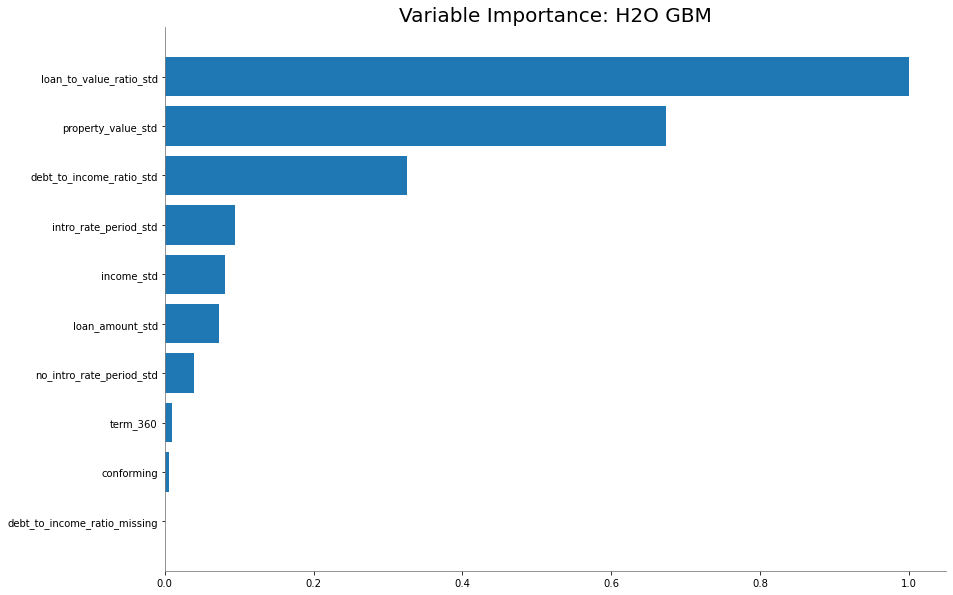

In [20]:
gbm_h2o.varimp_plot()

## Calculate and Plot Local Feature Importance.

### MGBM

In [21]:
from rmltk import explain

In [22]:
# merge MGBM predictions onto validation data
mgbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             best_gbm.predict(hvalid)['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
mgbm_yhat_valid = mgbm_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
mgbm_percentile_dict = explain.get_percentile_dict('p_high_priced', mgbm_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
mgbm_percentile_dict

{0: 18583,
 99: 139587,
 10: 99881,
 20: 79592,
 30: 76226,
 40: 2046,
 50: 155357,
 60: 131820,
 70: 159488,
 80: 91588,
 90: 158581}

In [23]:
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True) # Pandas index will now start from 0
valid_idx_map[0:5] # Shapley array index on left, ID on right

0     6
1     7
2    10
3    13
4    19
Name: row_id, dtype: int64

In [24]:
local_coef_dict = {10: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names),
                   50: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names),
                   90: pd.DataFrame(columns = ['mgbm Contribution'], index=x_names)}
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(mgbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['mgbm Contribution'], index=x_names)
        local_coef_dict[percentile]['mgbm Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### Ensenble

In [25]:
# merge ensenble predictions onto validation data
ensenble_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             ensenble_h2o.predict(hvalid)['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
ensenble_yhat_valid = ensenble_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
ensenble_percentile_dict = explain.get_percentile_dict('p_high_priced', ensenble_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
ensenble_percentile_dict

{0: 12046,
 99: 104391,
 10: 2669,
 20: 8471,
 30: 128046,
 40: 107425,
 50: 101083,
 60: 39382,
 70: 153066,
 80: 132715,
 90: 49824}

In [26]:
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(ensenble_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['Ensenble Contribution'], index=x_names)
        local_coef_dict[percentile]['Ensenble Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### GBM

In [27]:
# merge gbm predictions onto validation data
gbm_yhat_valid = pd.concat([valid.reset_index(drop=True),
                             gbm_h2o.predict(hvalid)['1.0'].as_data_frame()],
                            axis=1)

# rename yhat column
gbm_yhat_valid = gbm_yhat_valid.rename(columns={'1.0':'p_high_priced'})

# find percentiles of predictions
gbm_percentile_dict = explain.get_percentile_dict('p_high_priced', gbm_yhat_valid, 'row_id')

# display percentiles dictionary
# key=percentile, val=row_id
gbm_percentile_dict

{0: 111605,
 99: 1238,
 10: 23862,
 20: 27746,
 30: 137602,
 40: 132702,
 50: 73334,
 60: 63661,
 70: 45758,
 80: 9234,
 90: 103393}

In [28]:
# loop through features and percentiles
for name in x_names:
    for percentile in [10, 50, 90]:
    
        # use mapping find correct row of Shapley array
        # create a Pandas DataFrame from row of Shapley values
        idx = valid_idx_map[valid_idx_map == int(gbm_percentile_dict[percentile])].index[0]
        s_df = pd.DataFrame(shap_contribs[idx, :].T, columns=['gbm Contribution'], index=x_names)
        local_coef_dict[percentile]['gbm Contribution'] = 0
        local_coef_dict[percentile].update(s_df)

### Comparison

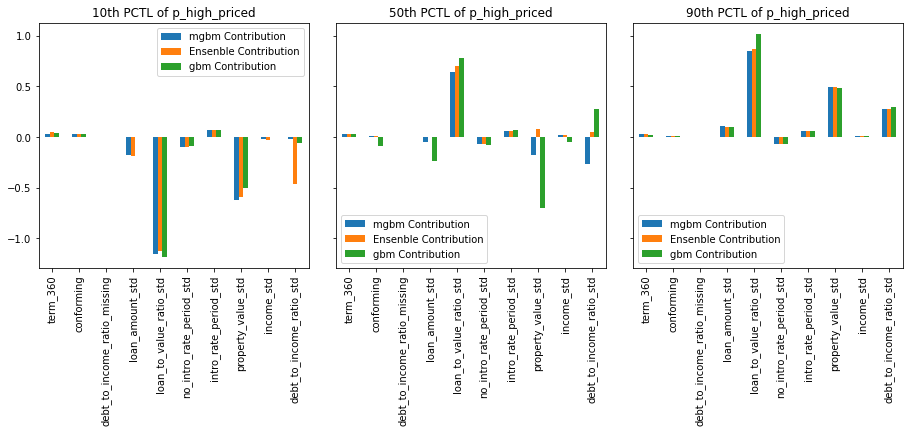

In [29]:
## init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_coef_dict[10].plot(kind='bar',
                           ax=ax0,
                           title='10th PCTL of p_high_priced')

_ = local_coef_dict[50].plot(kind='bar',
                           ax=ax1,
                           title='50th PCTL of p_high_priced')

_ = local_coef_dict[90].plot(kind='bar',
                           ax=ax2,
                           title='90th PCTL of p_high_priced')

### H2O Analysis: Ensenble

No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

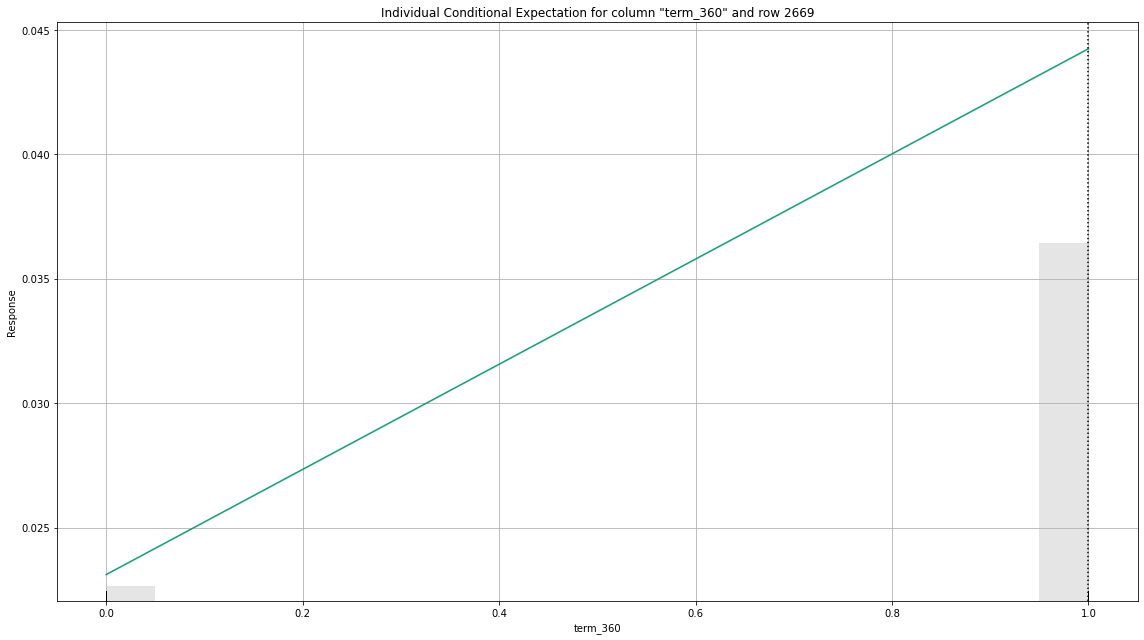

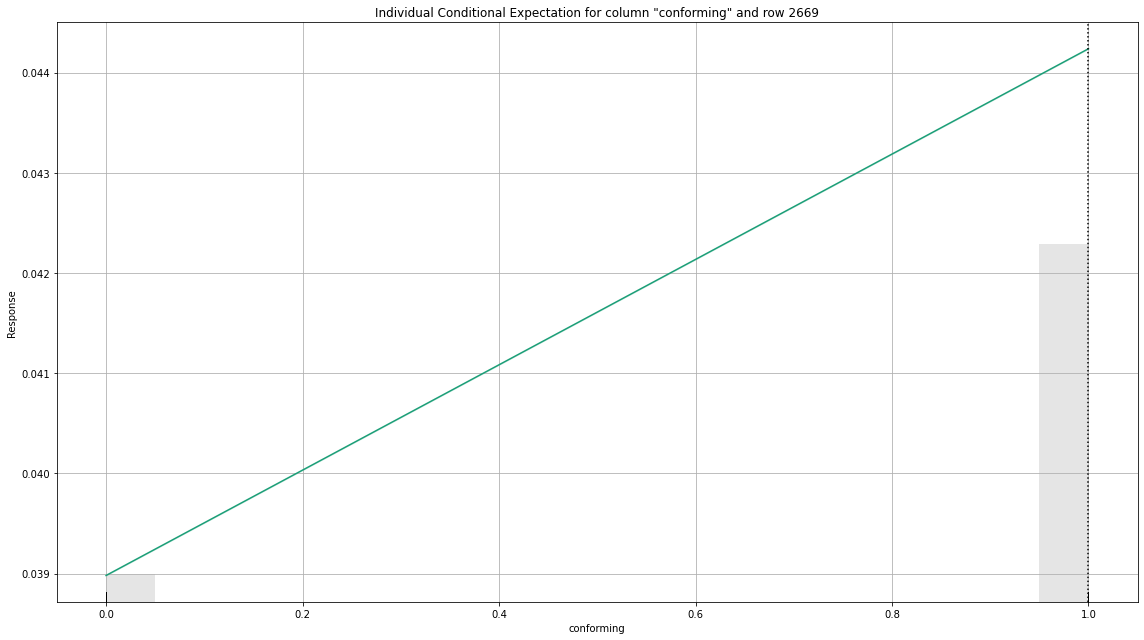

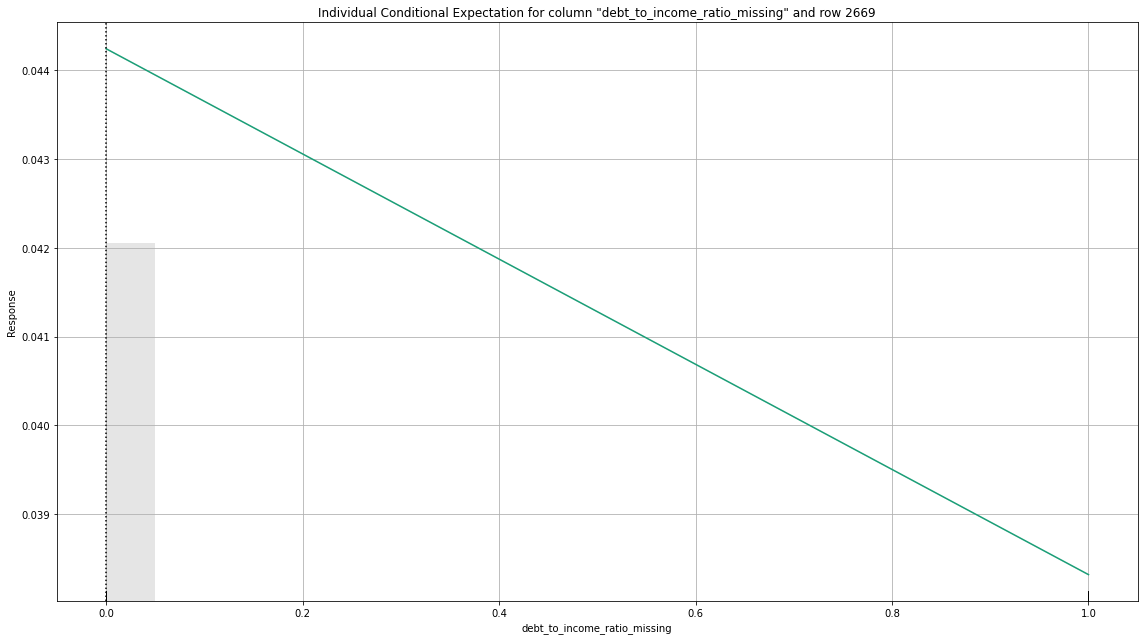

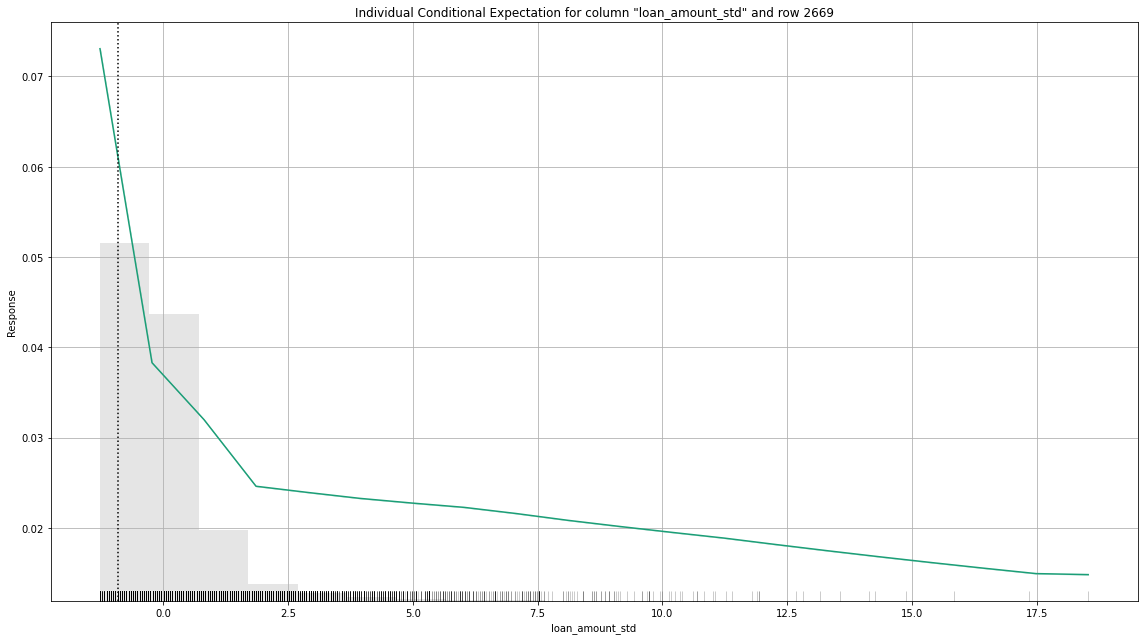

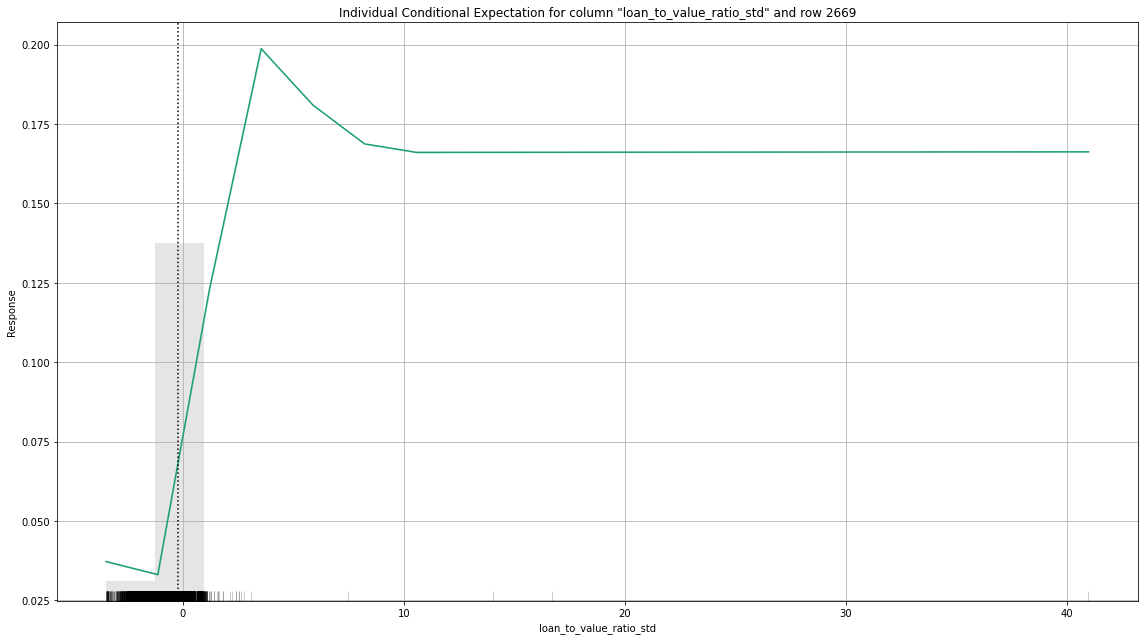

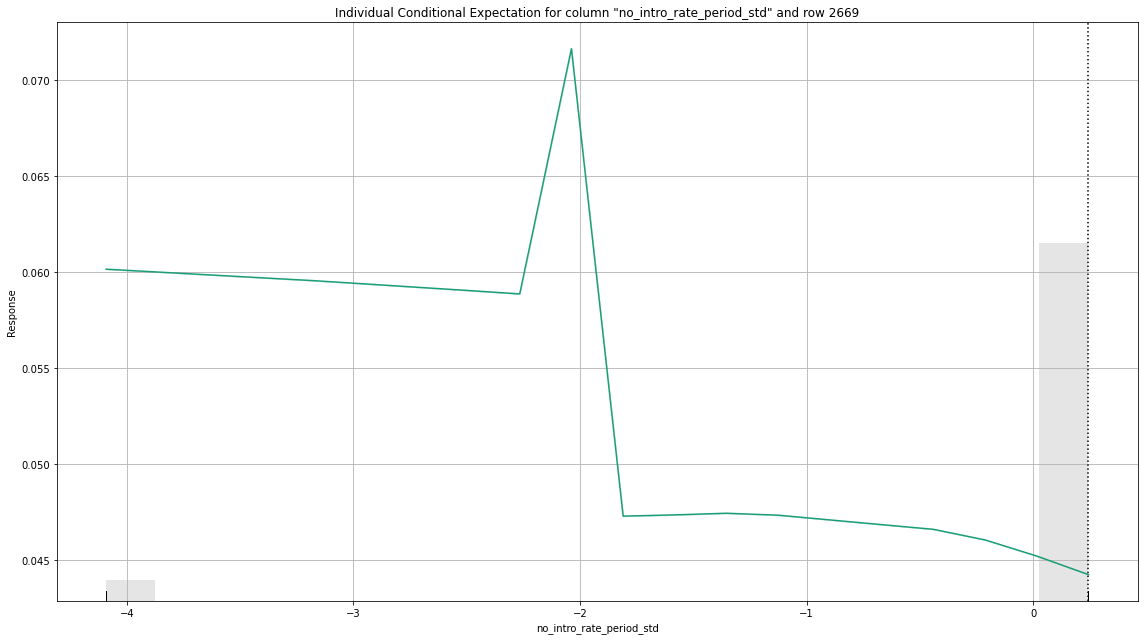

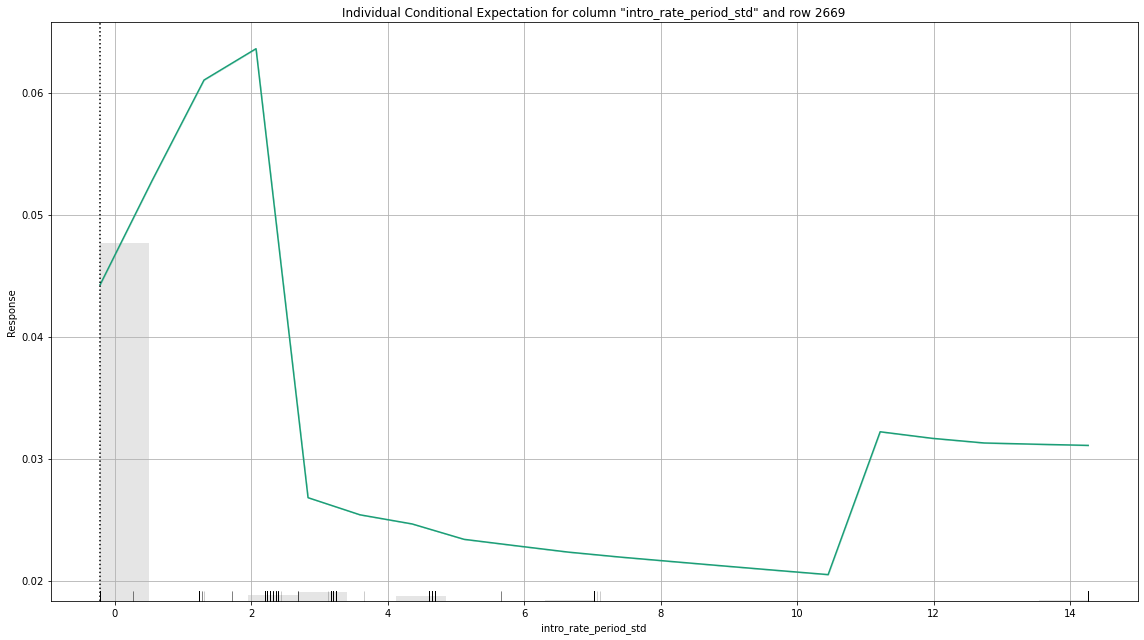

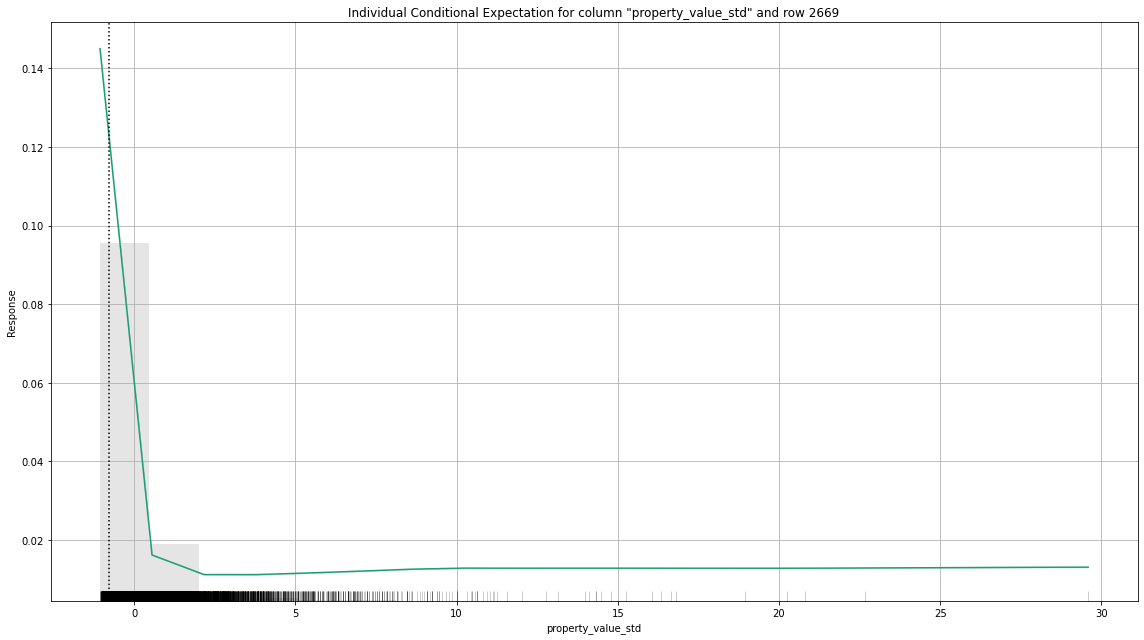

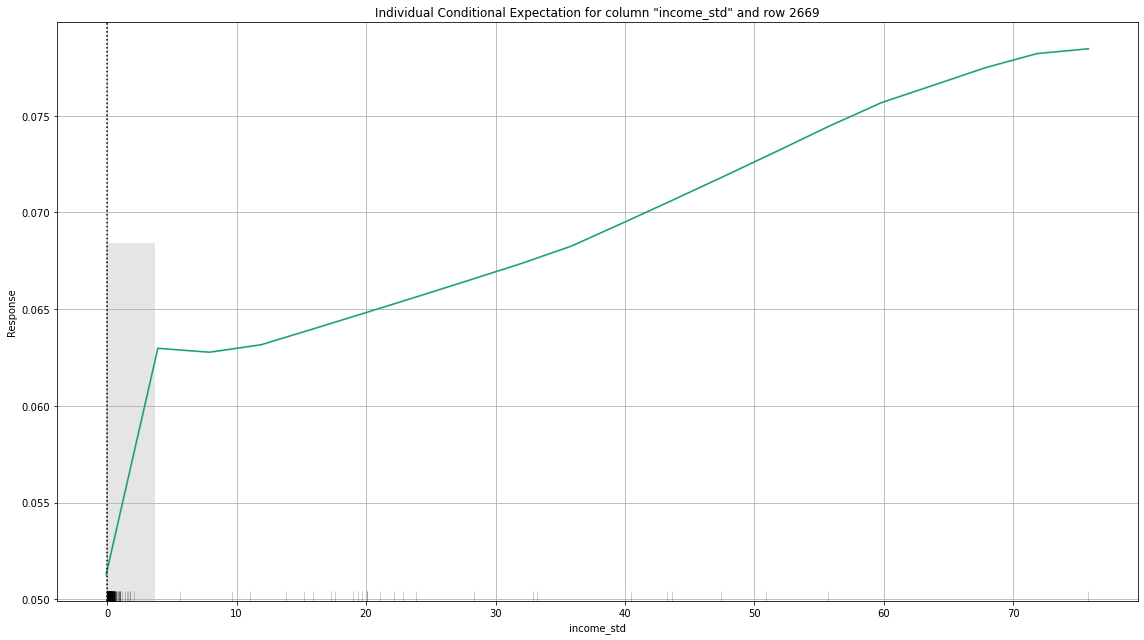

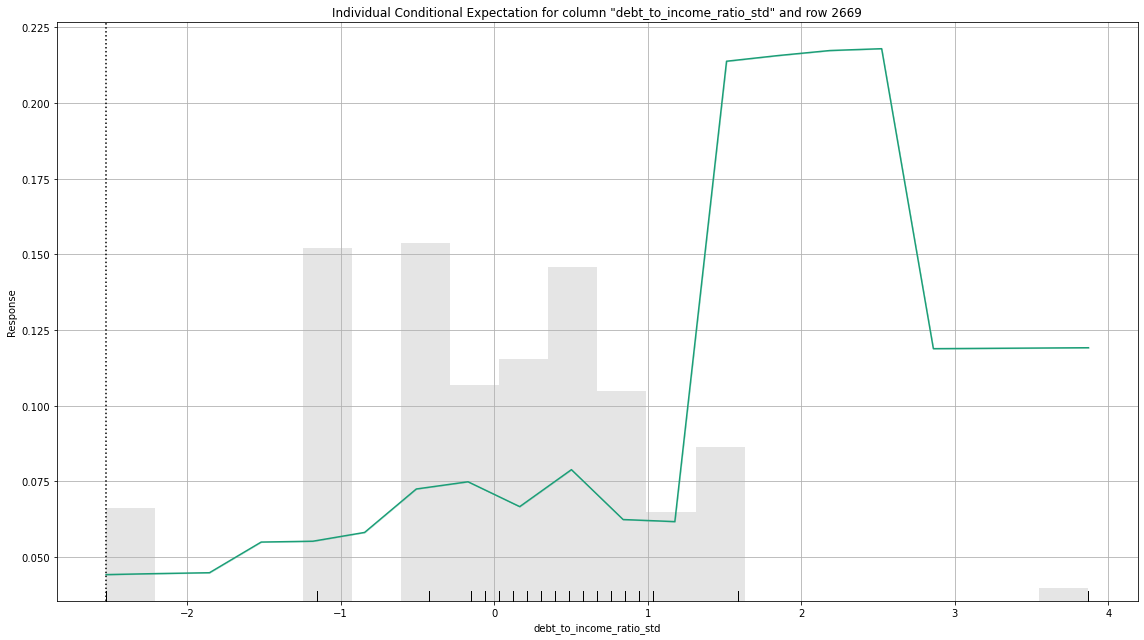

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

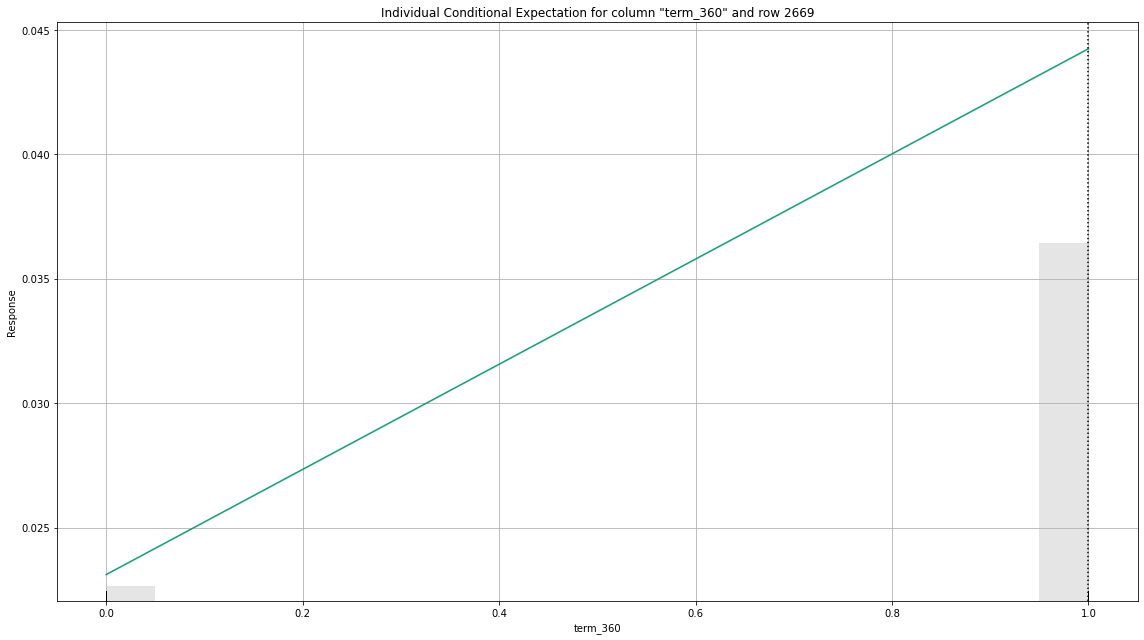

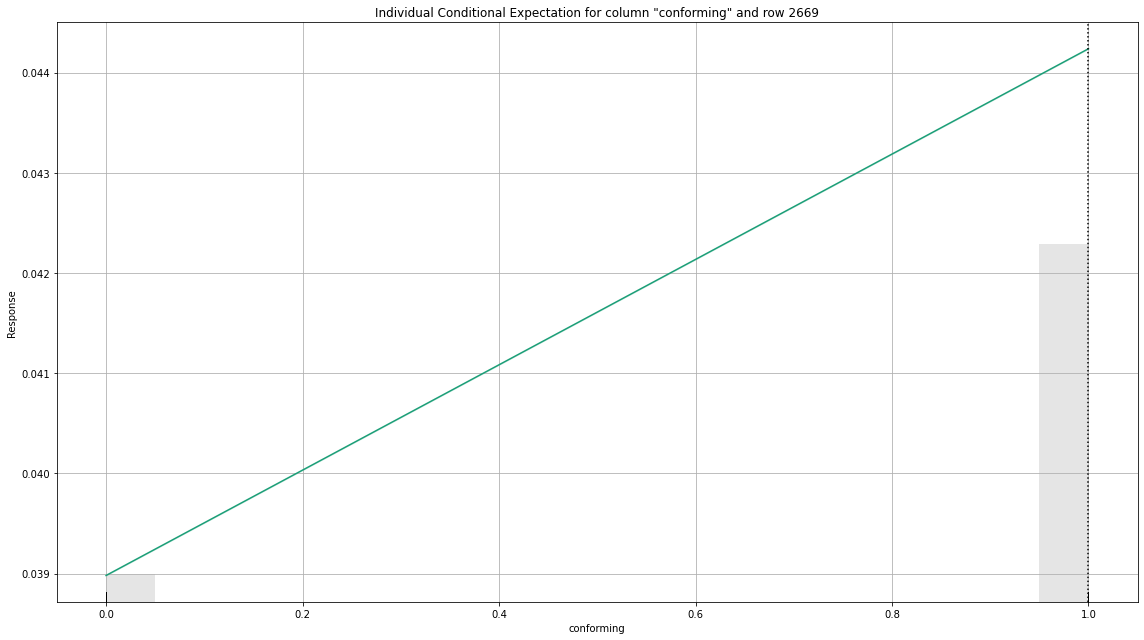

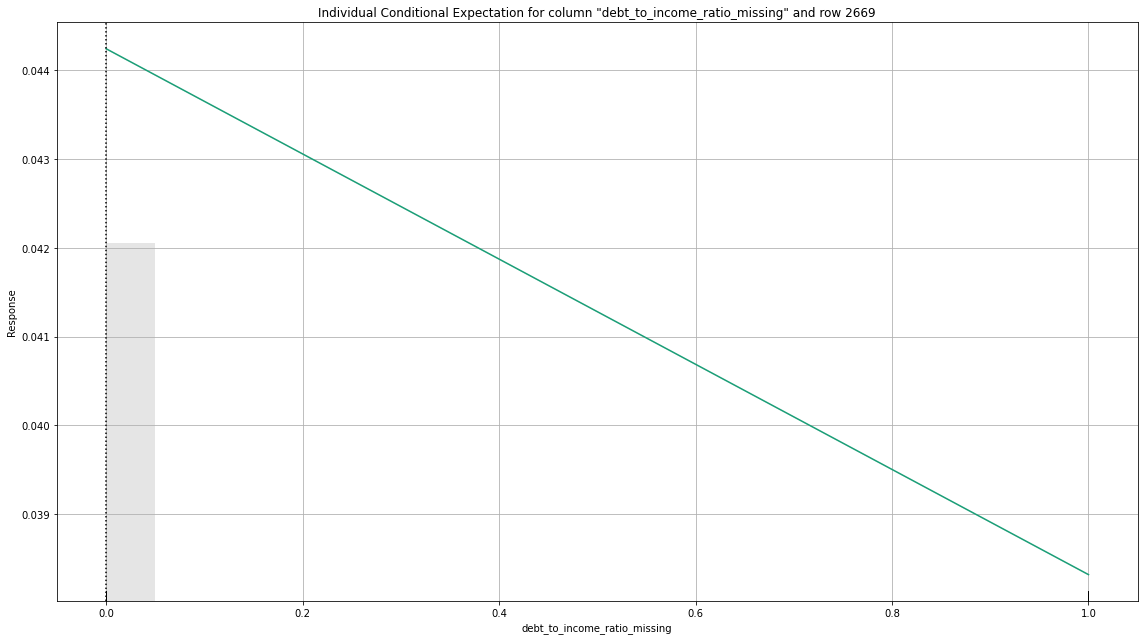

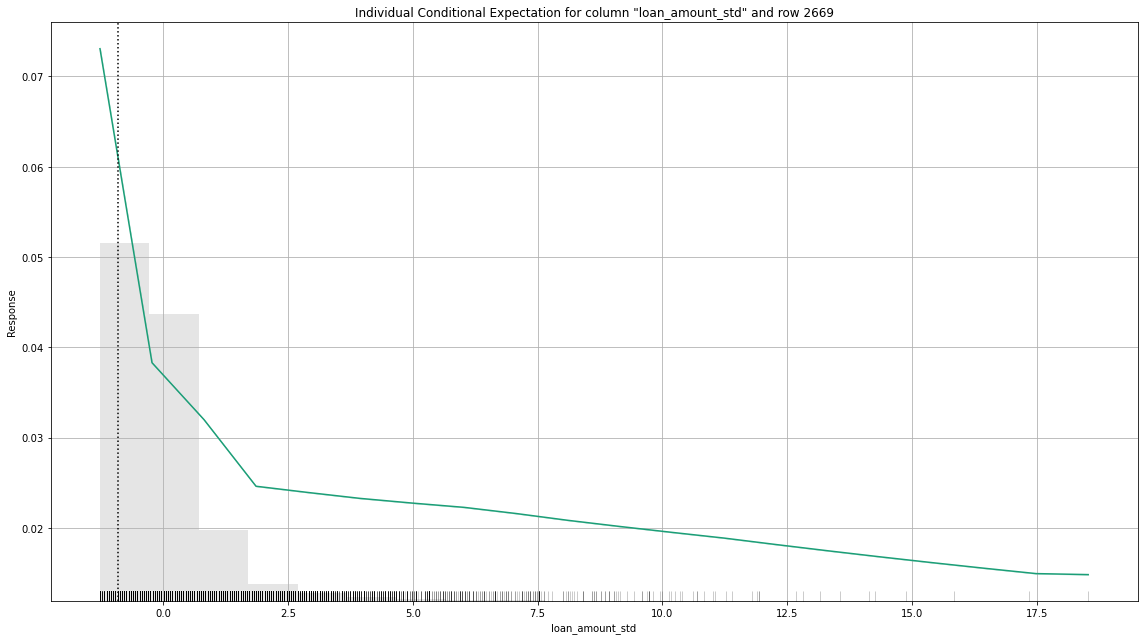

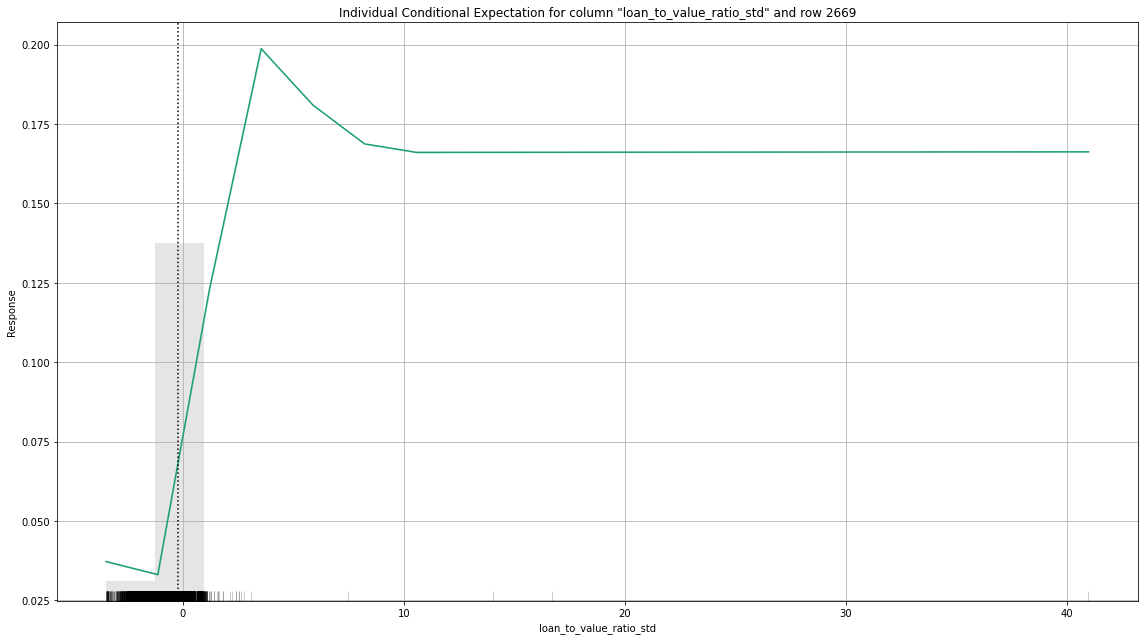

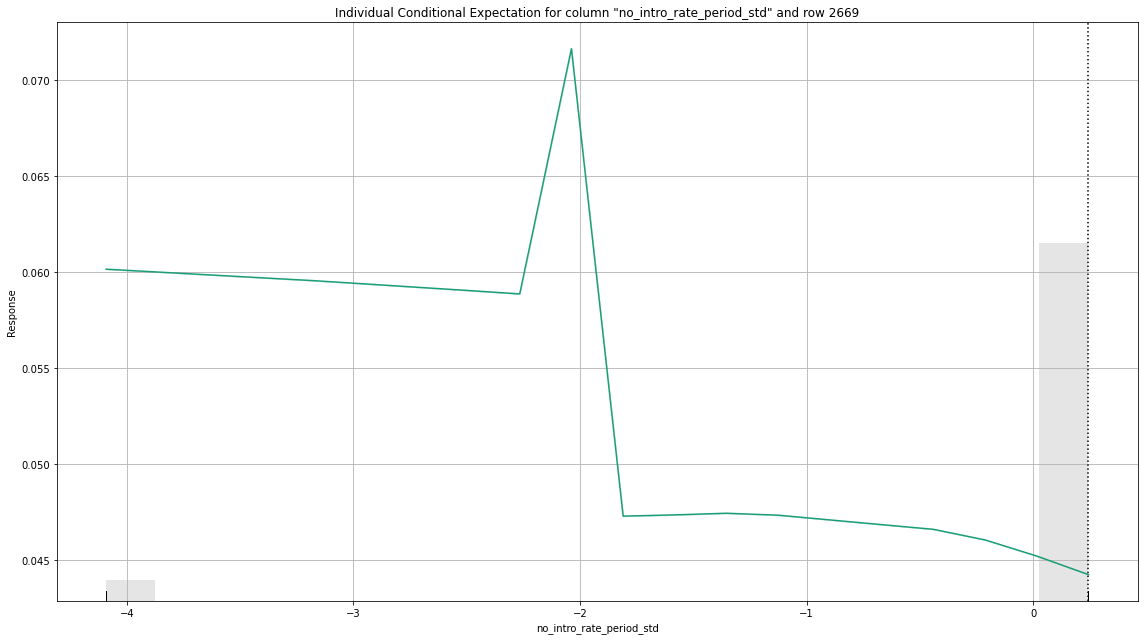

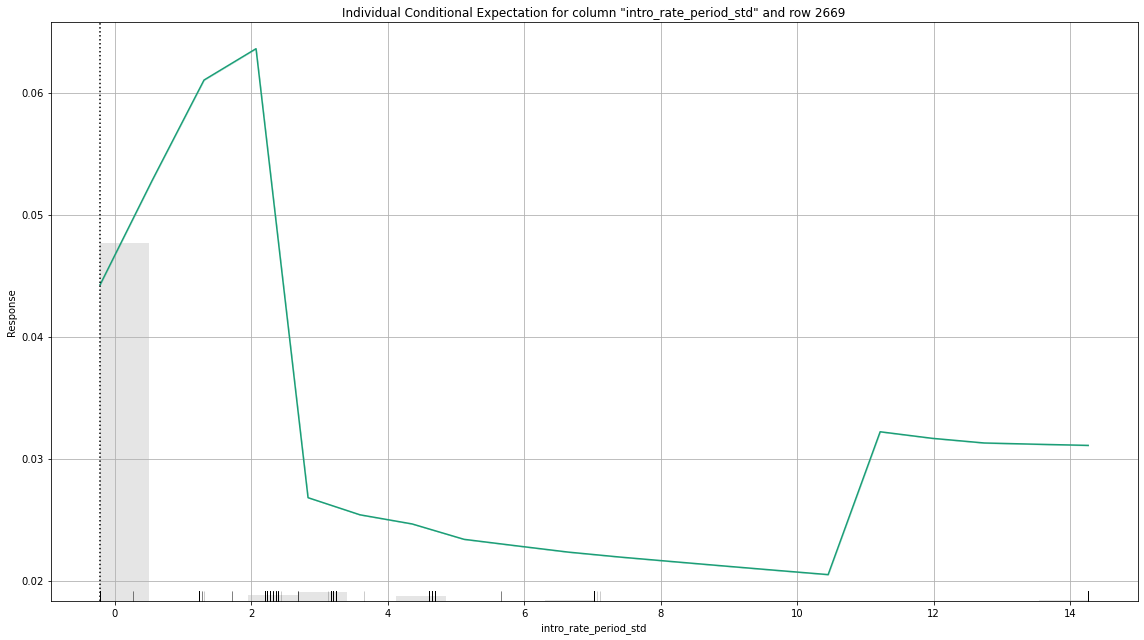

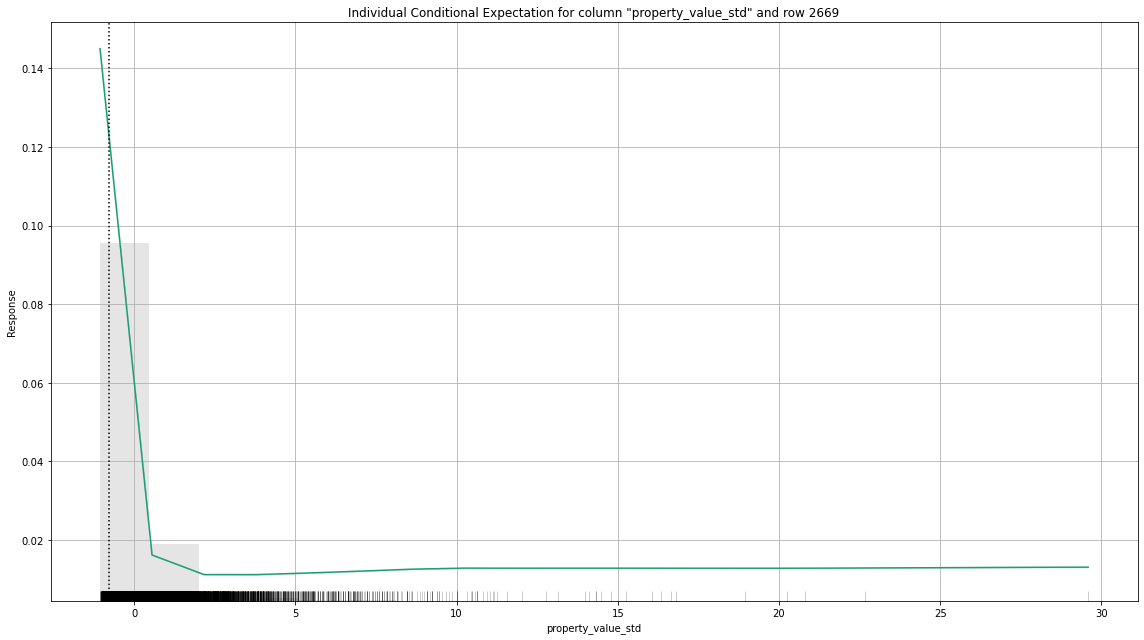

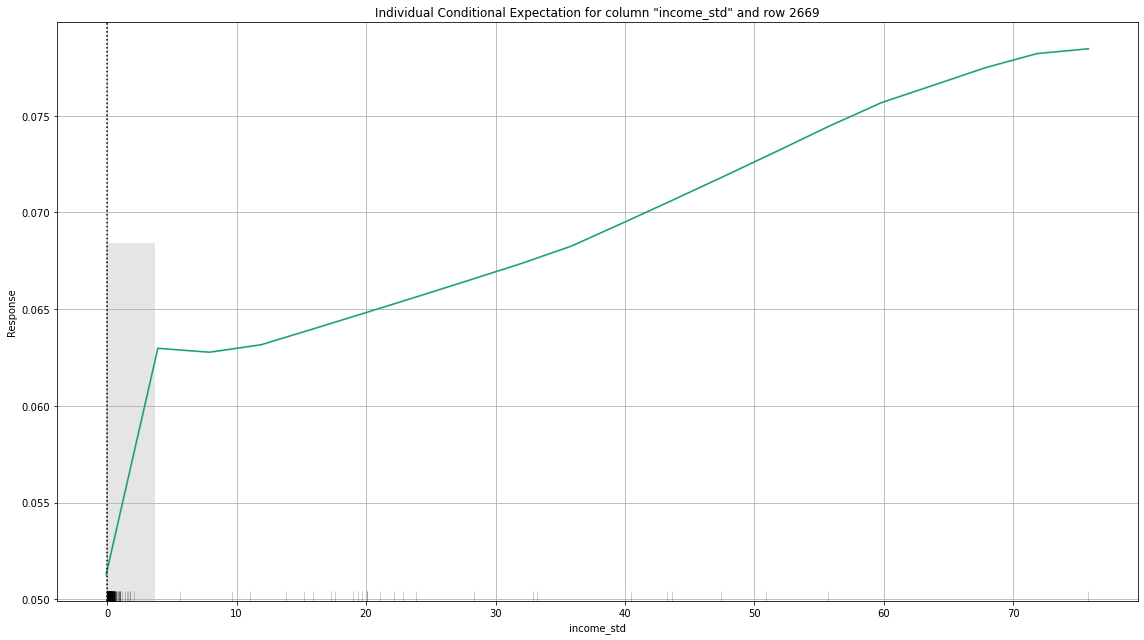

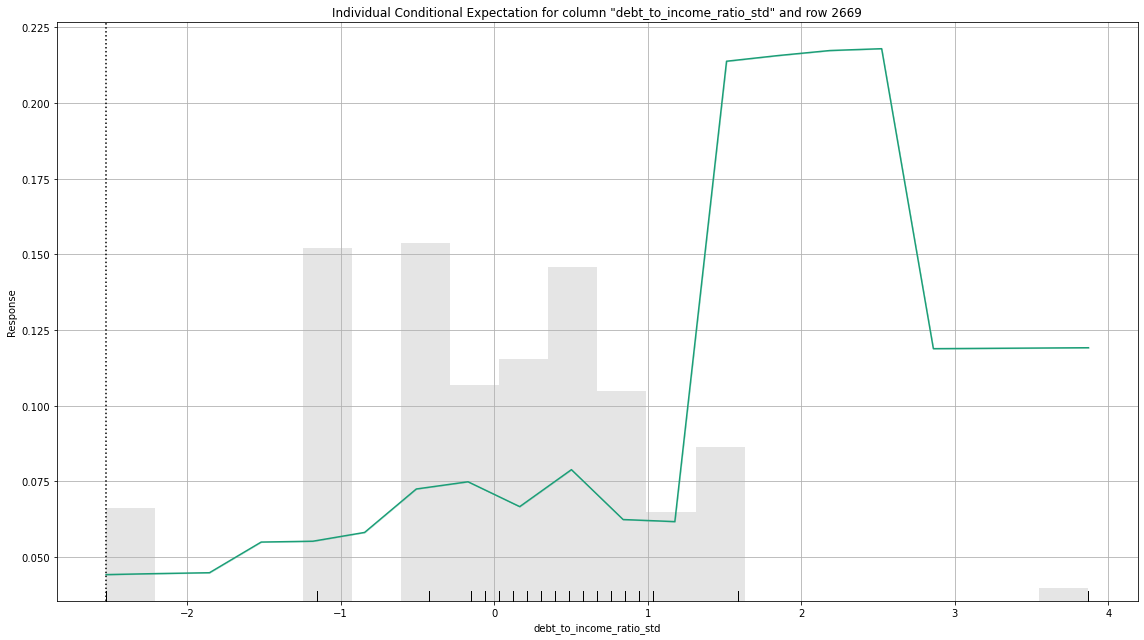

In [30]:
# Explain 10 percentile
ensenble_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[10]))


No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

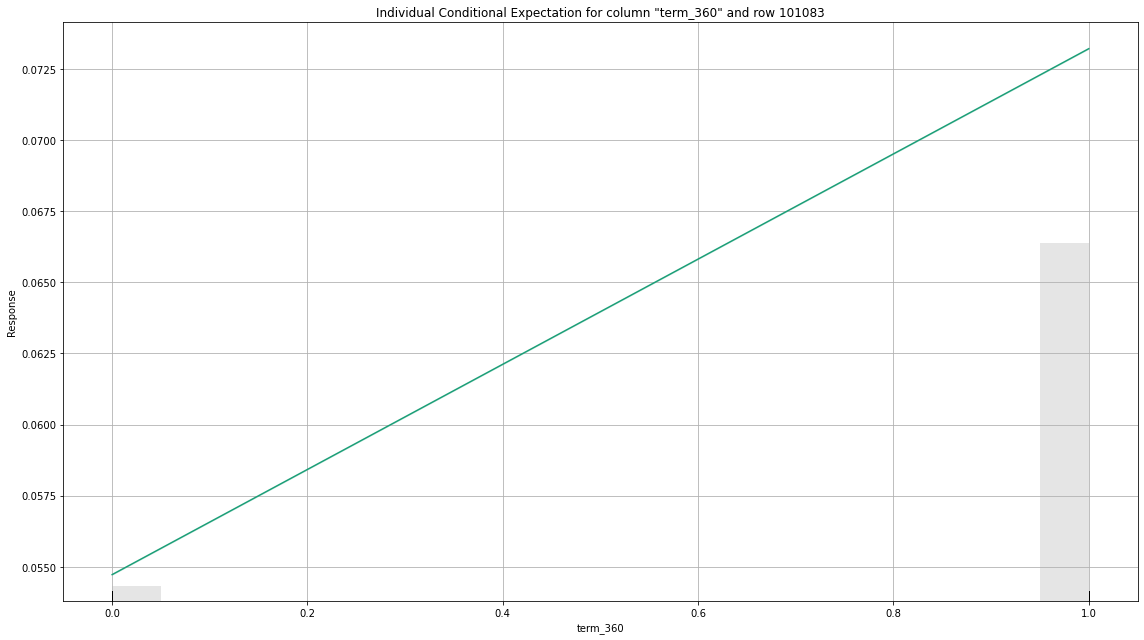

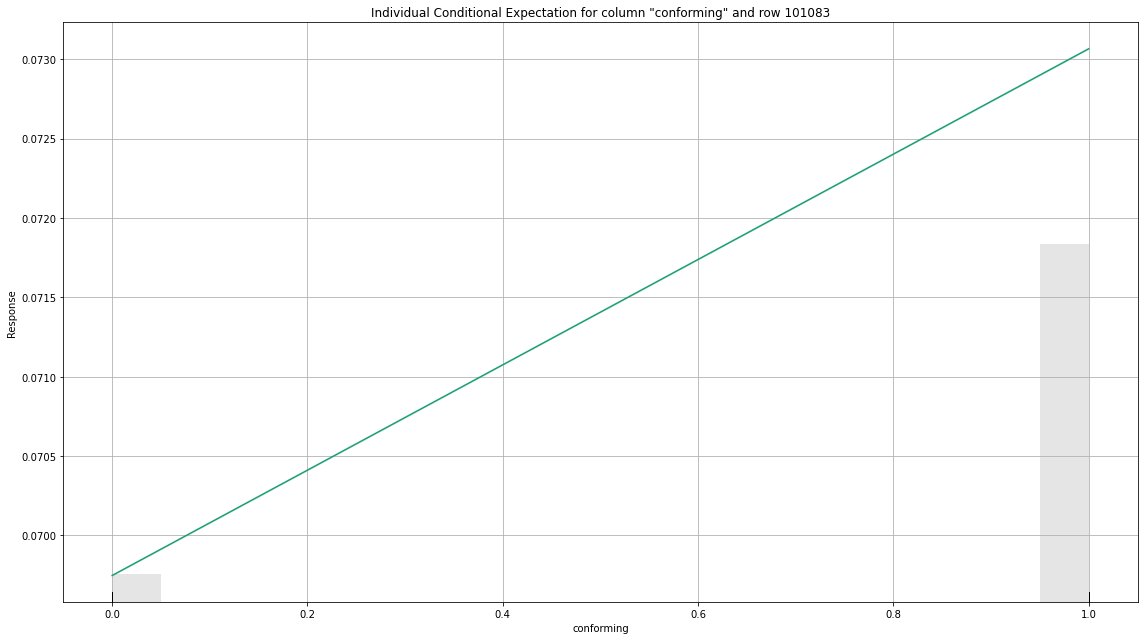

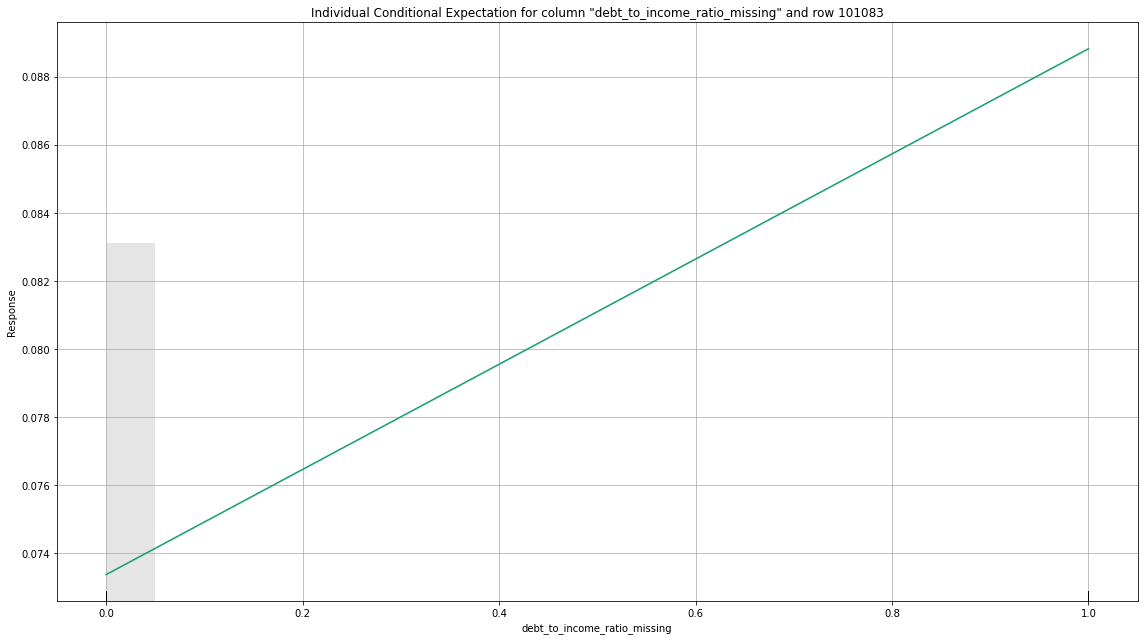

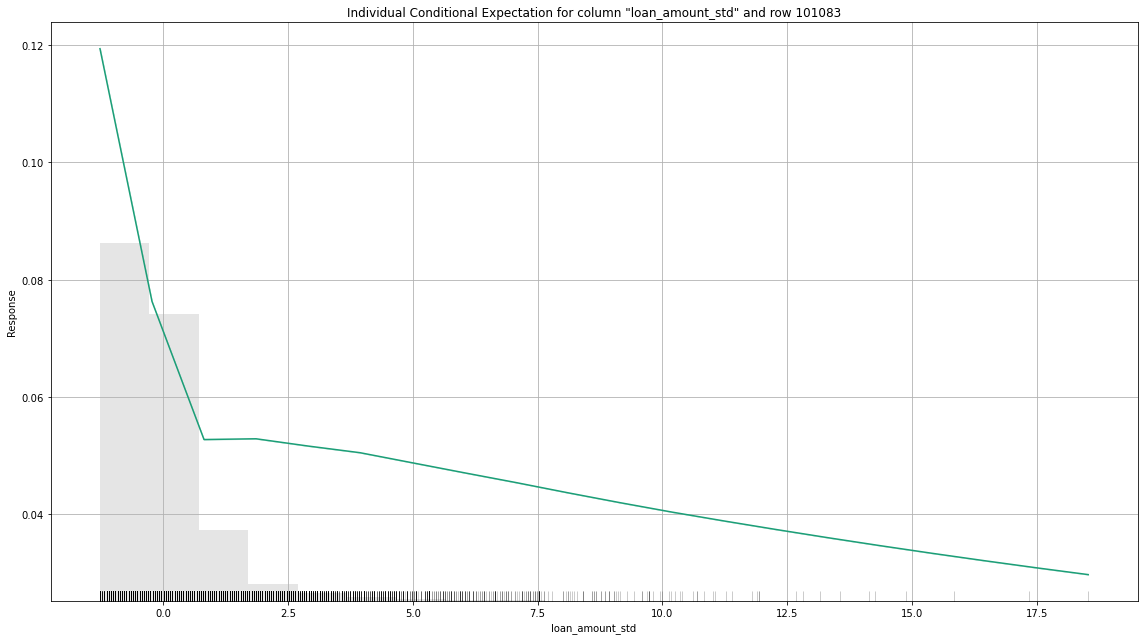

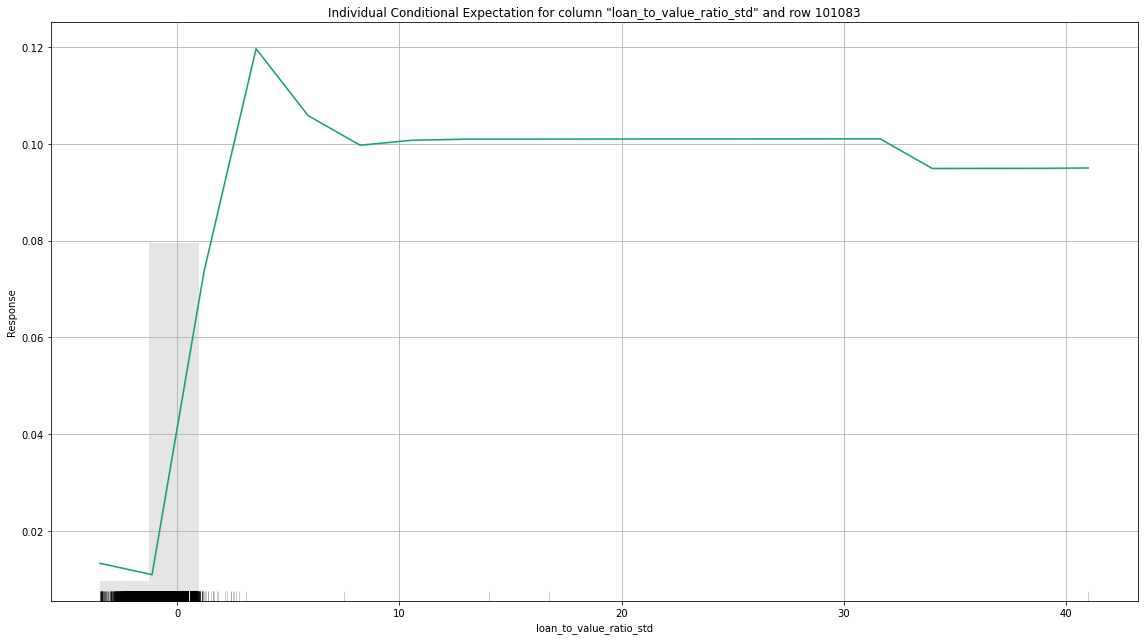

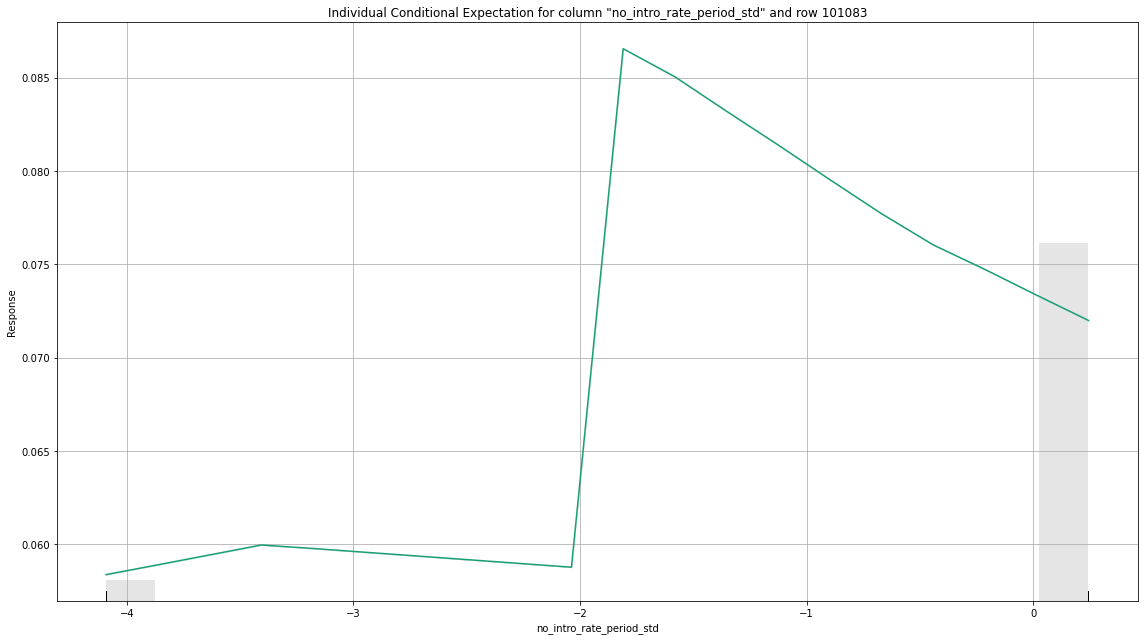

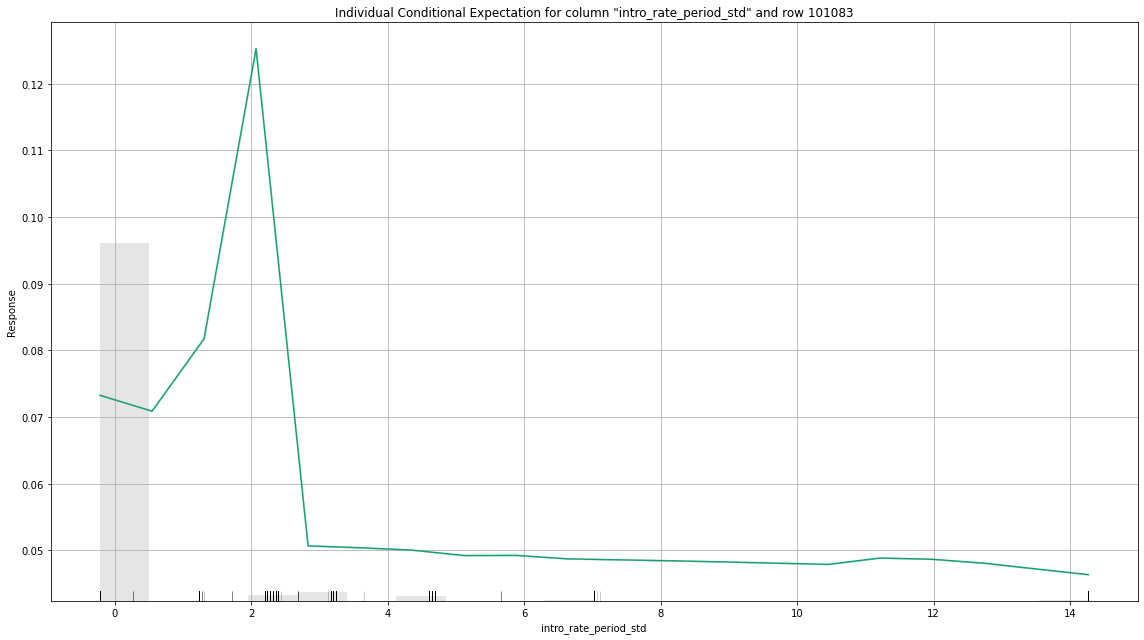

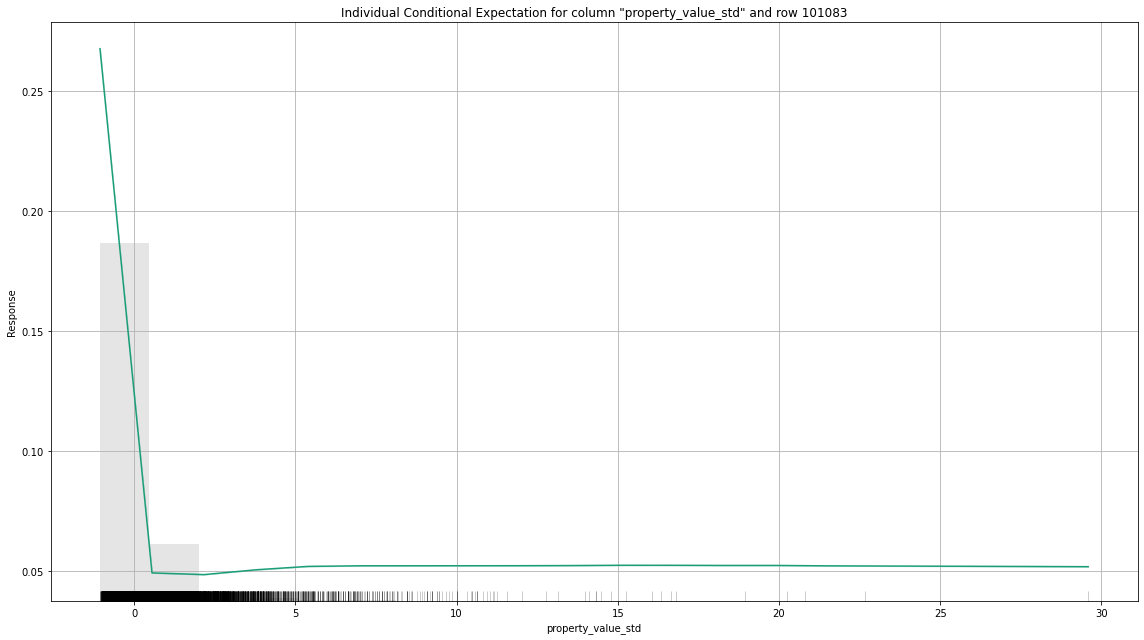

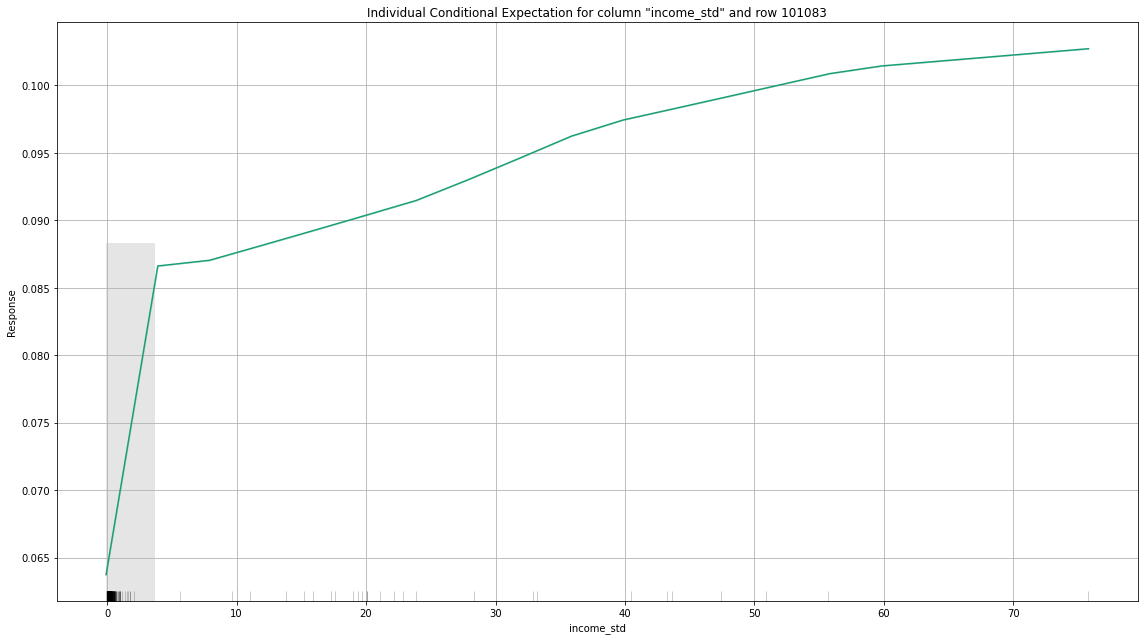

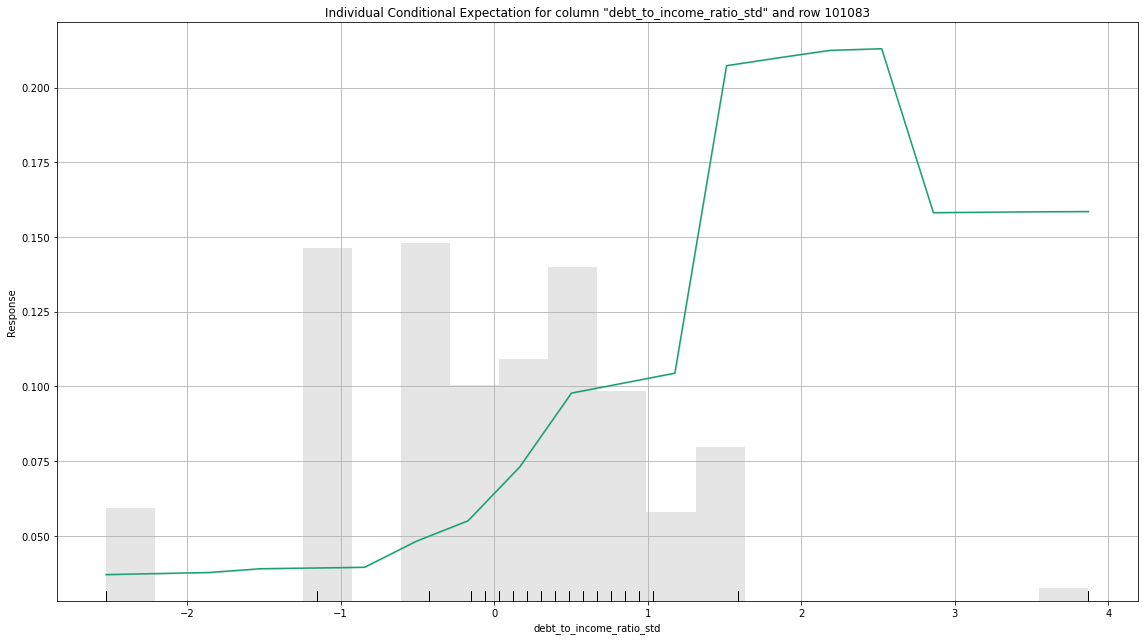

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

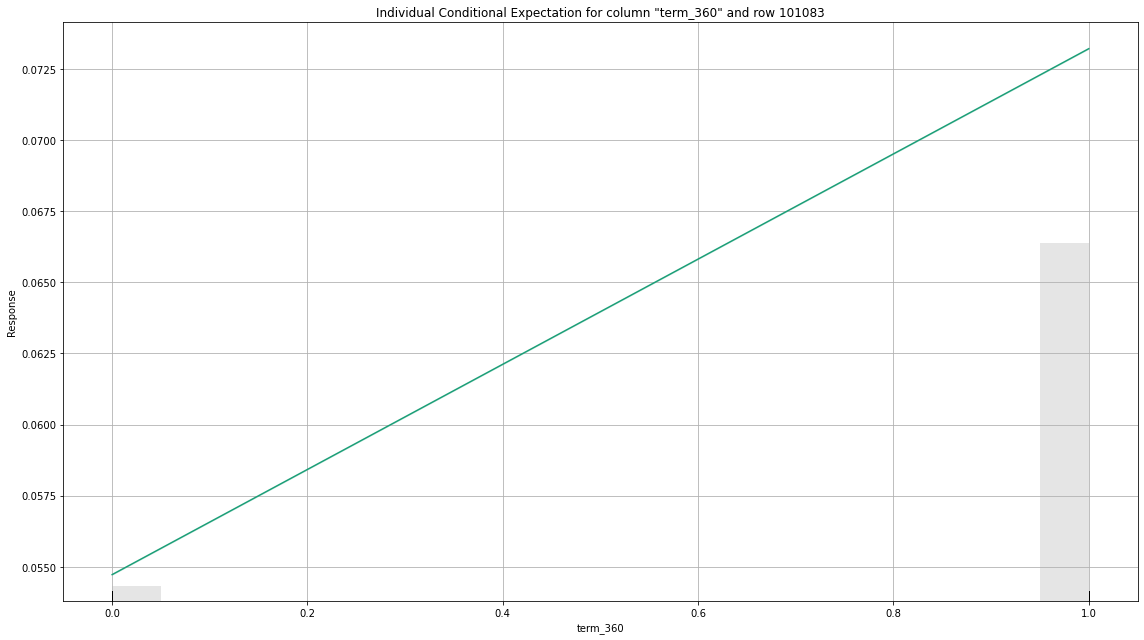

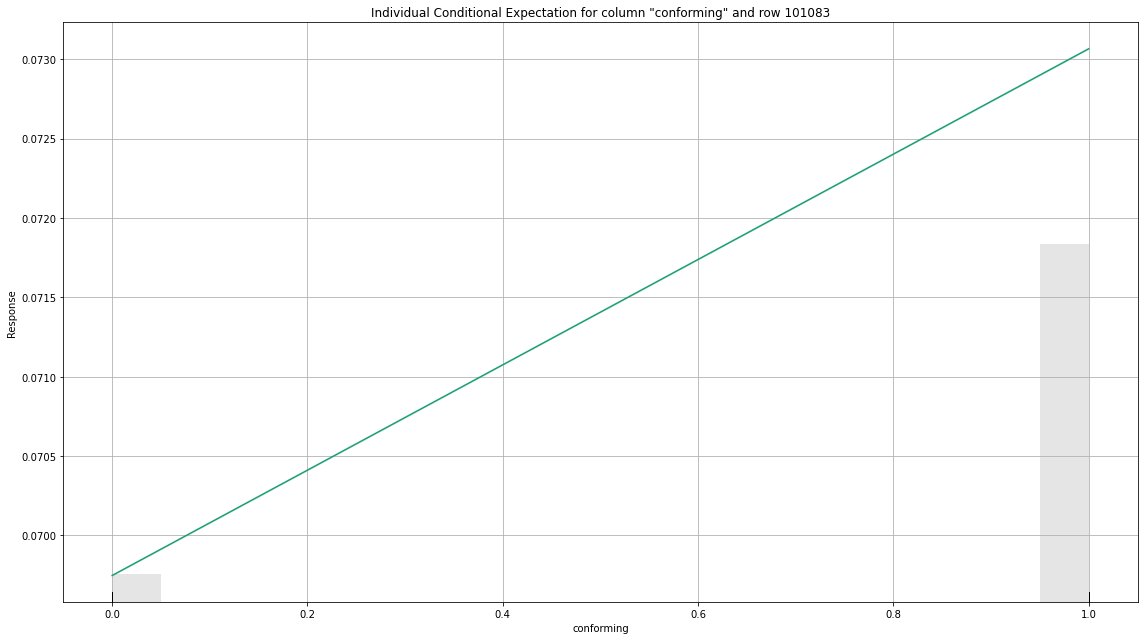

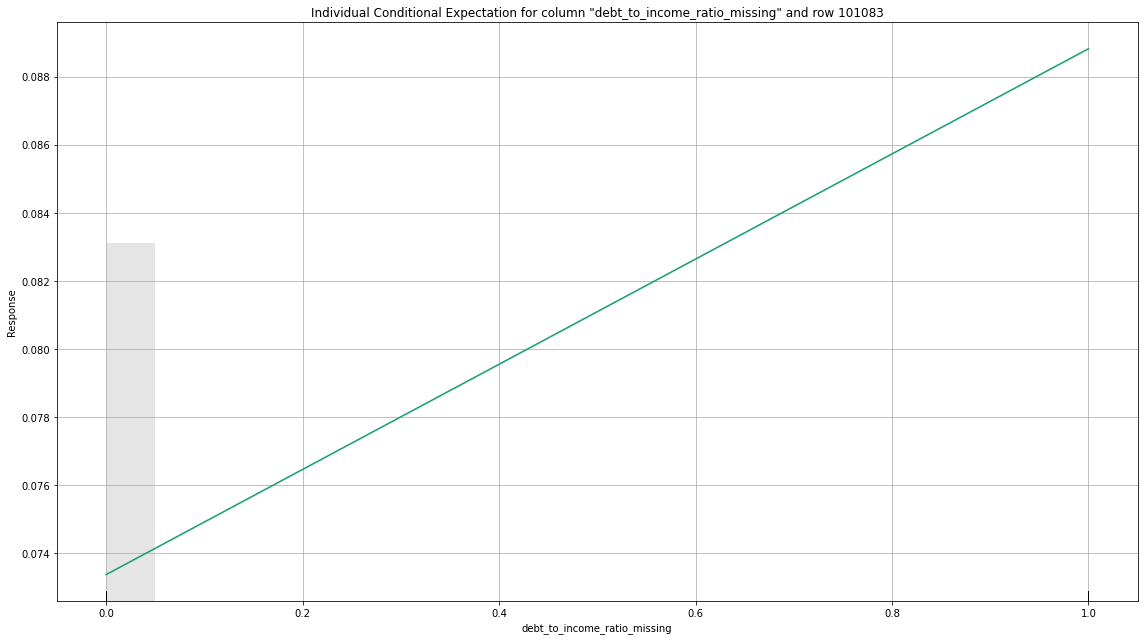

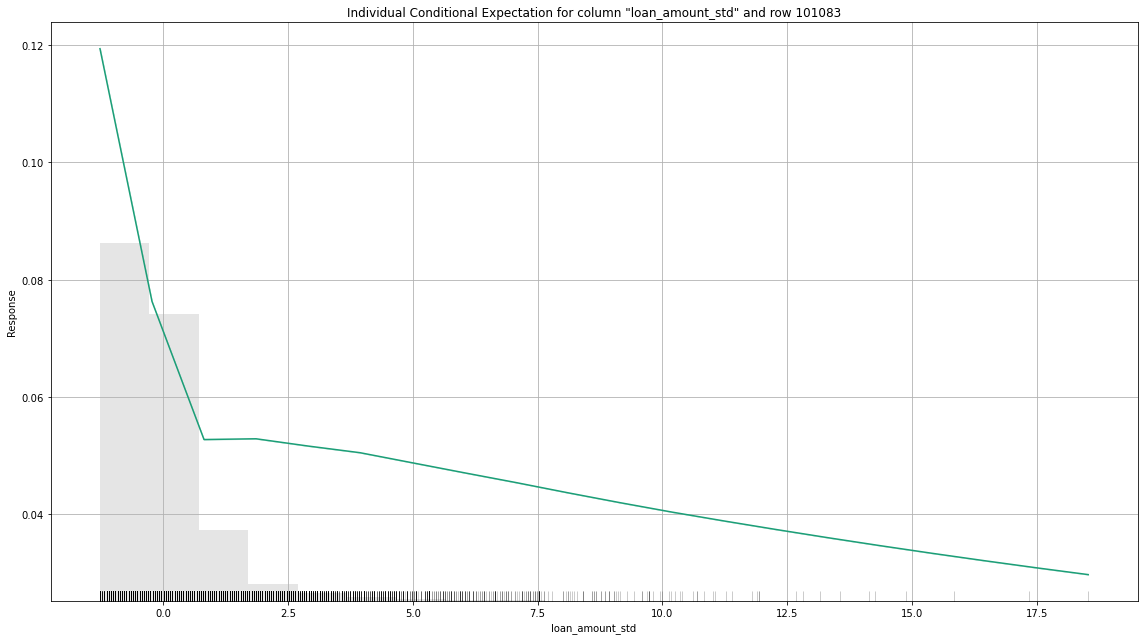

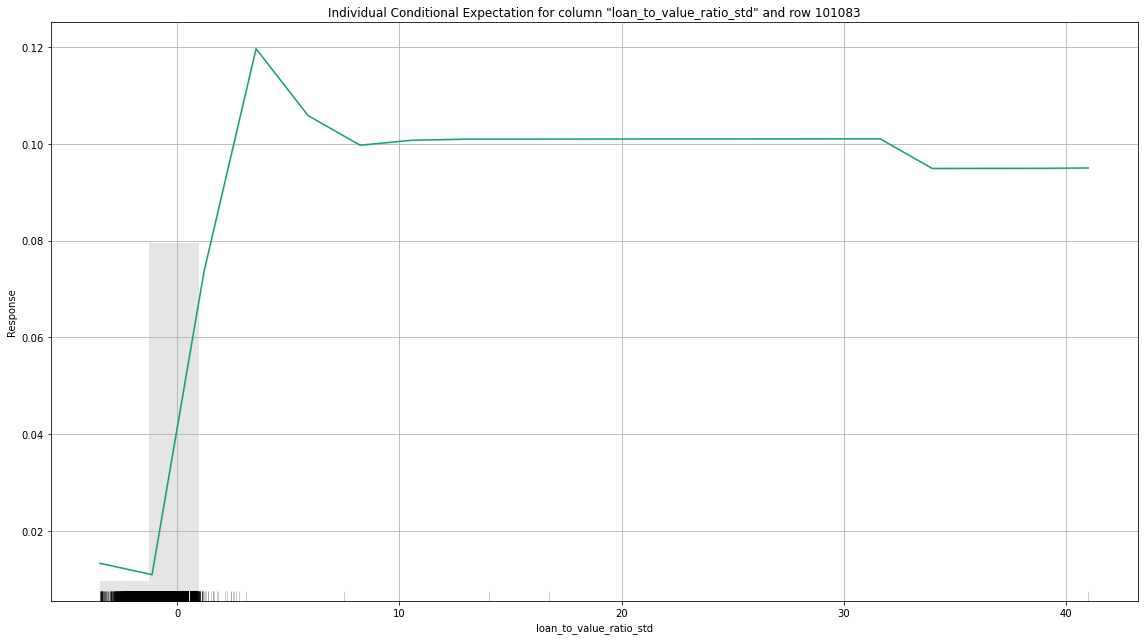

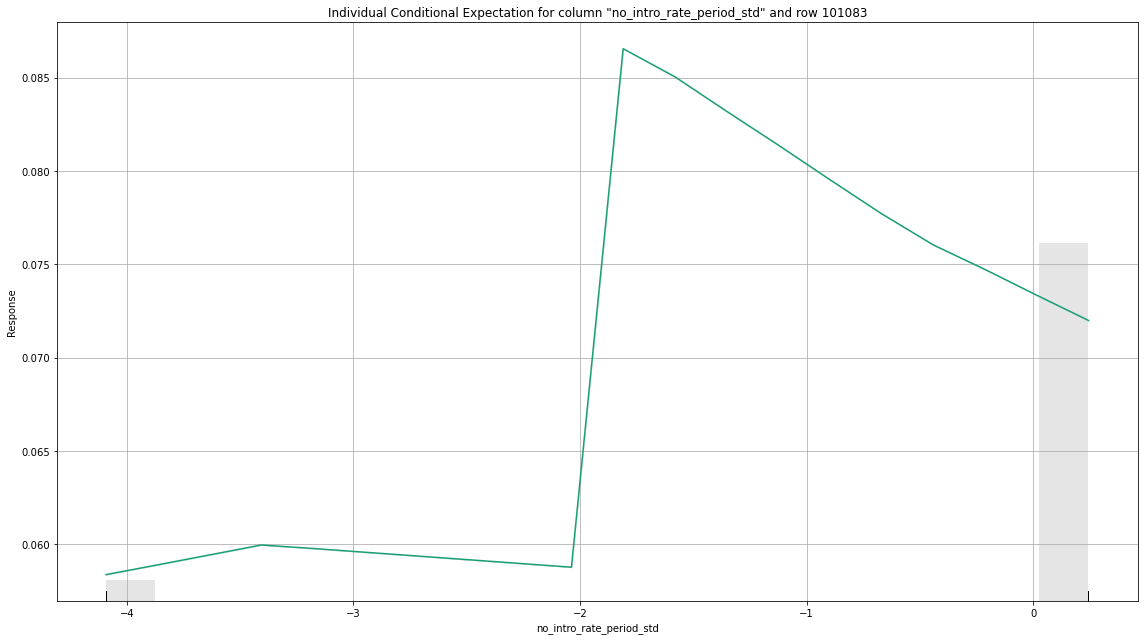

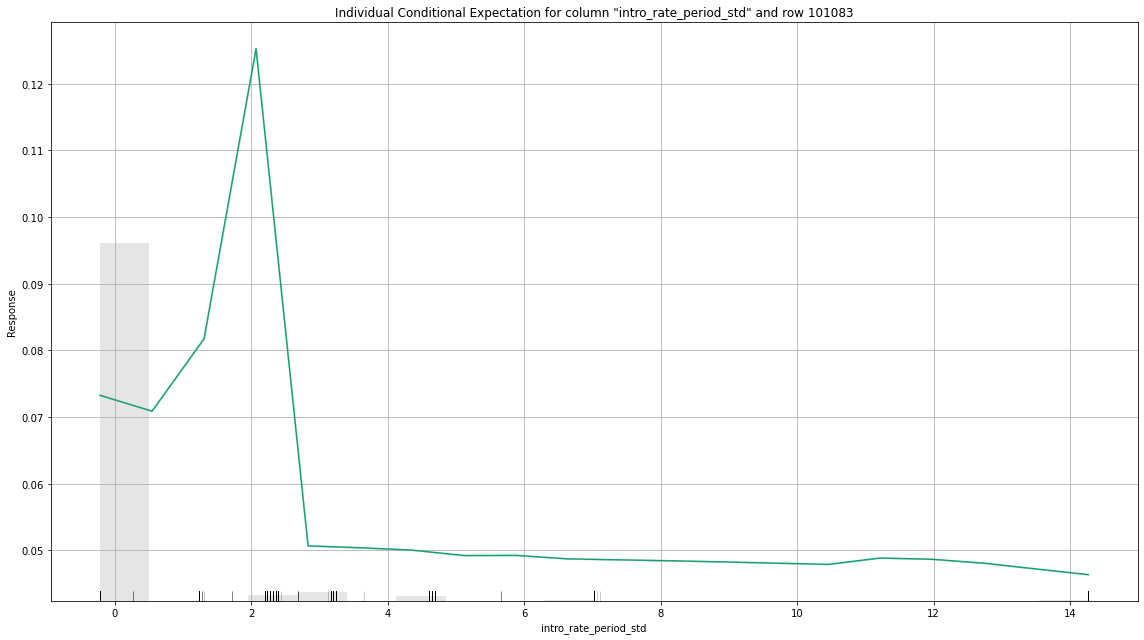

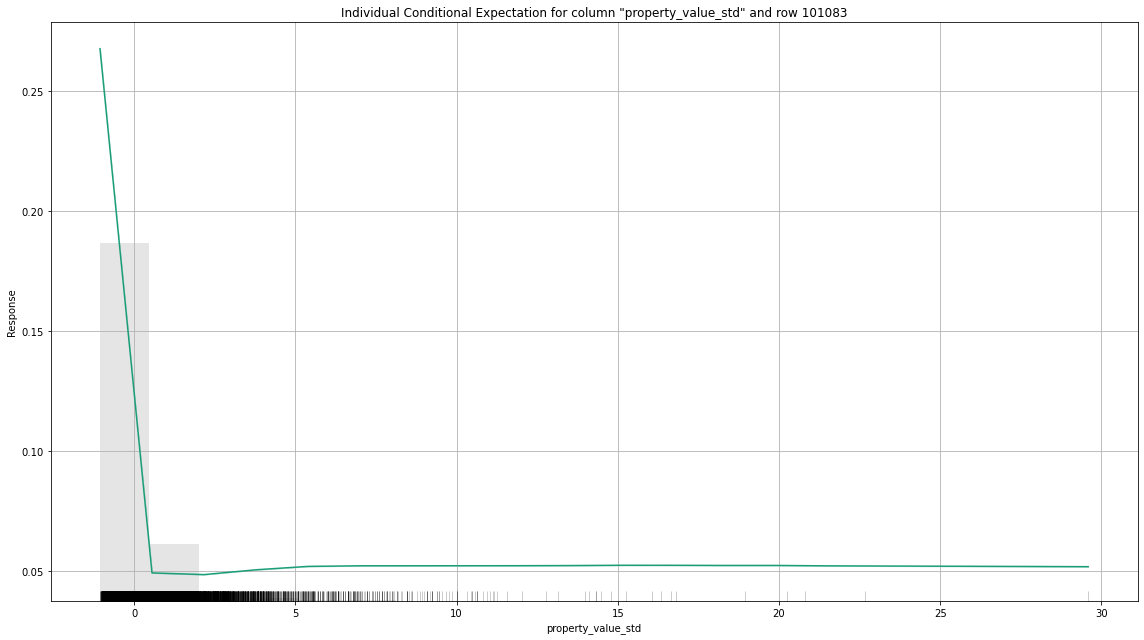

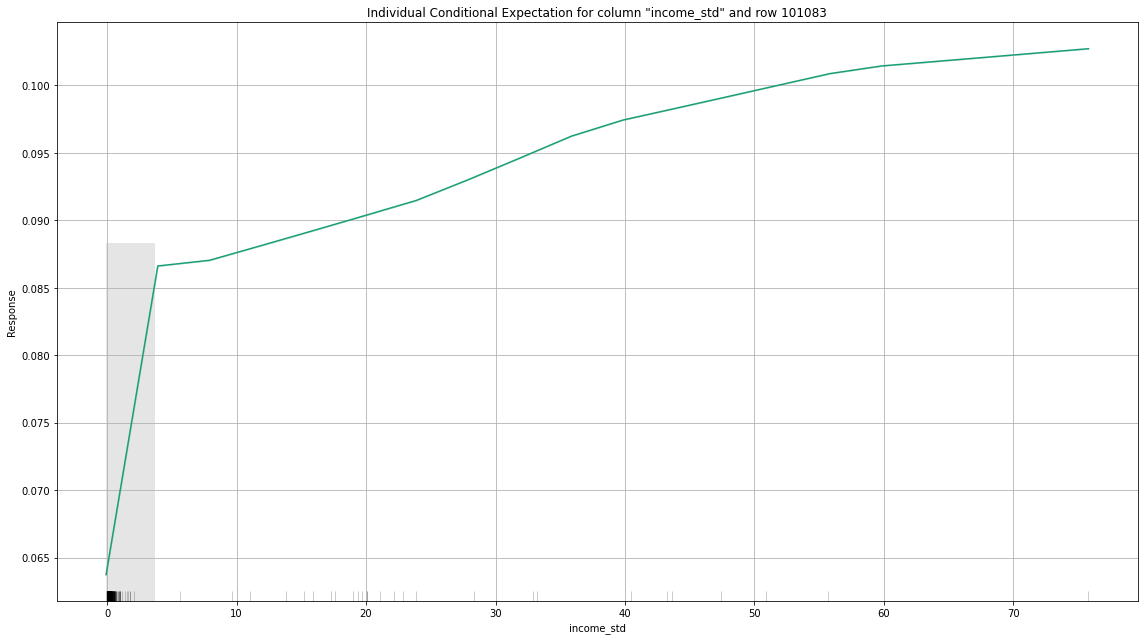

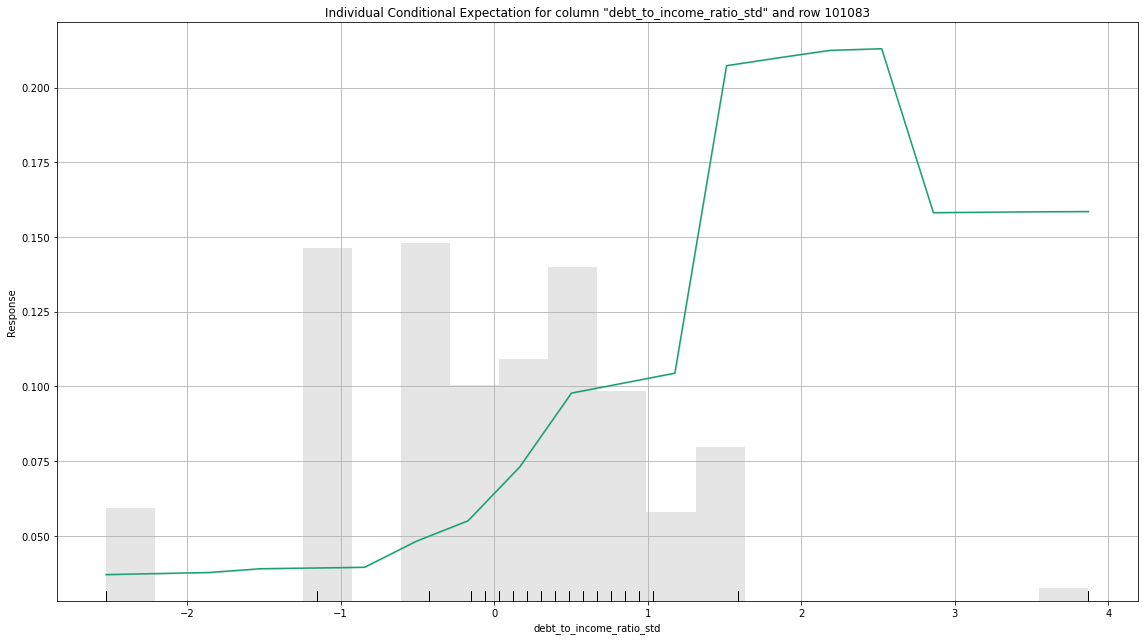

In [31]:
# Explain 50 percentile
ensenble_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[50]))

No model with variable importance. Selecting all features to explain.


# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

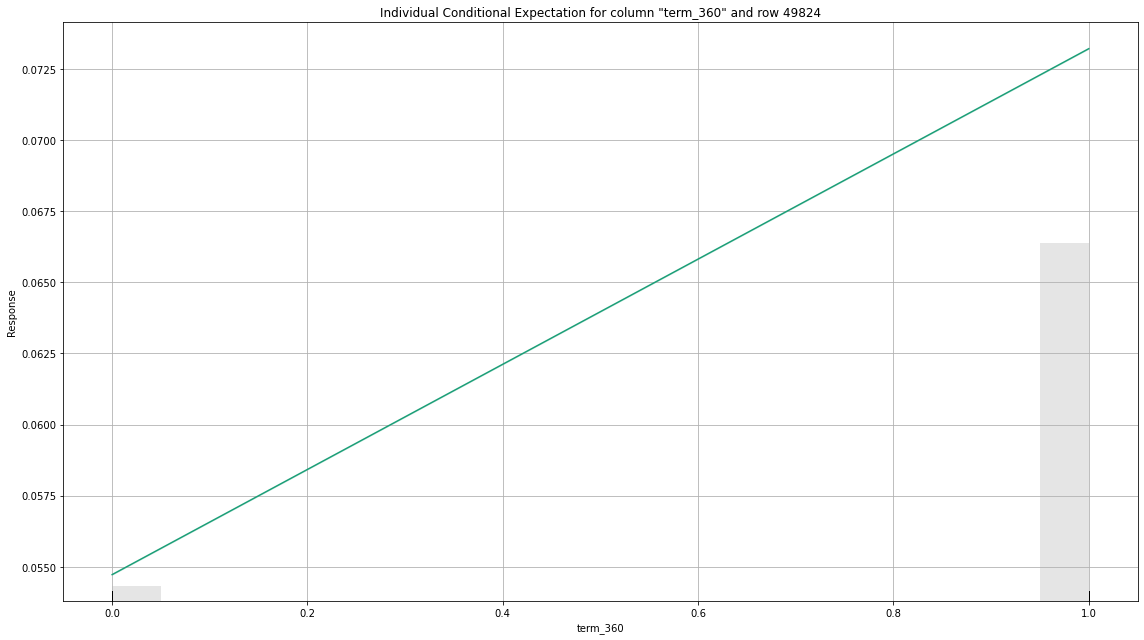

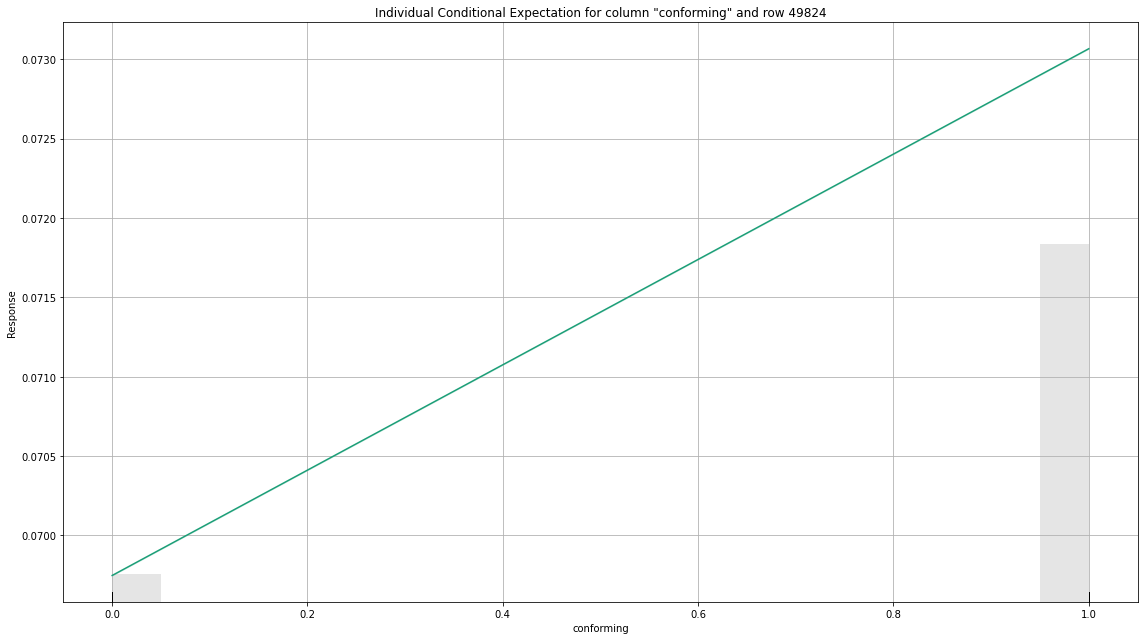

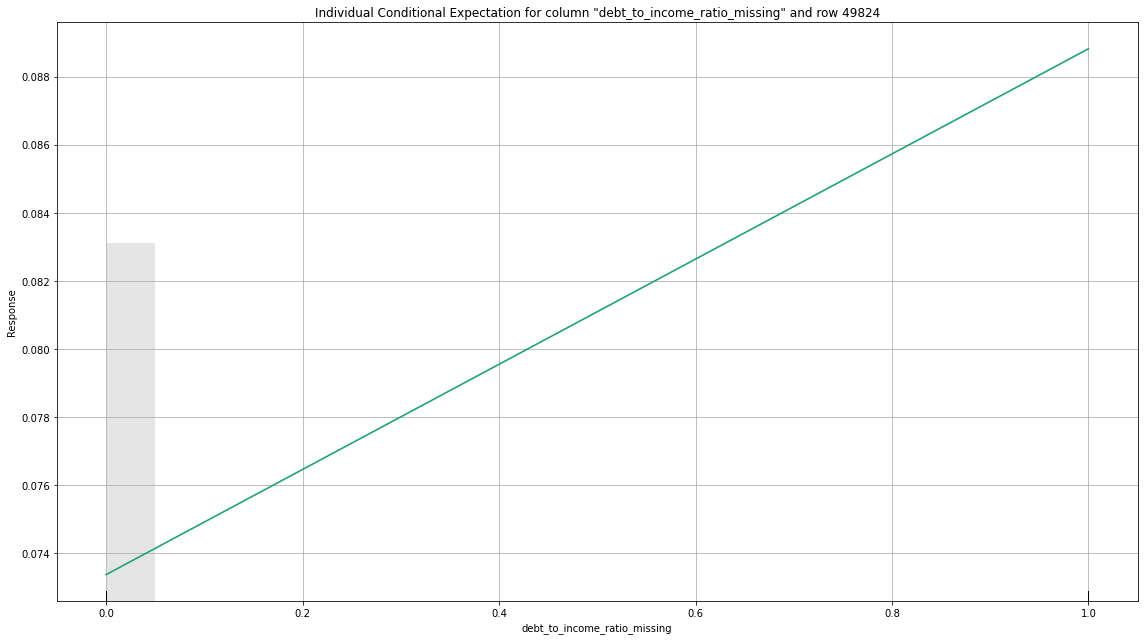

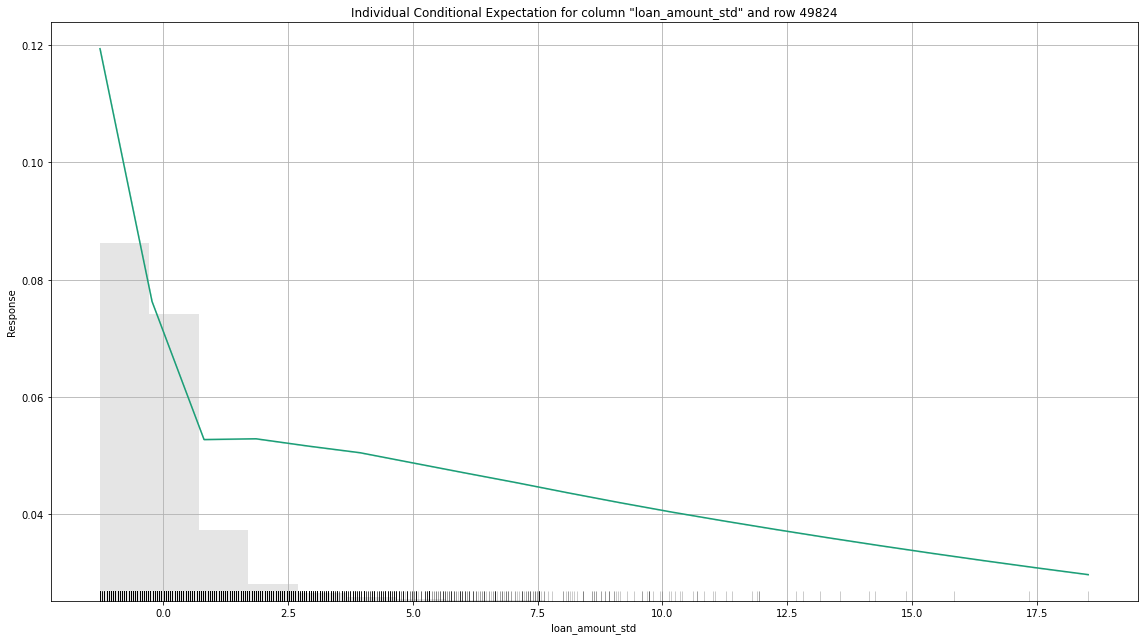

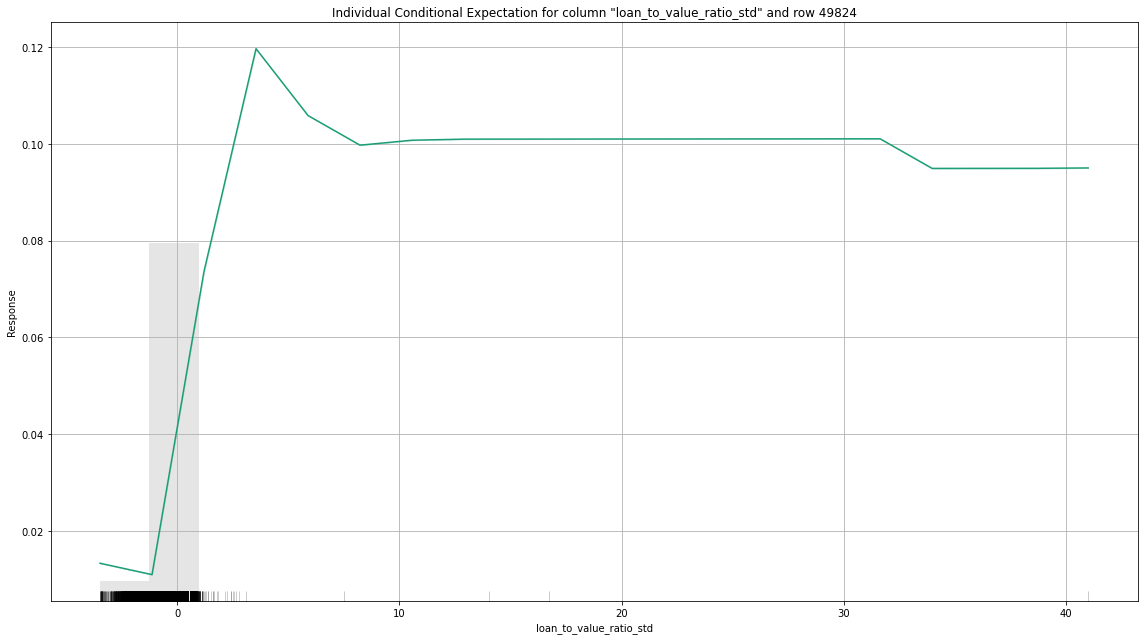

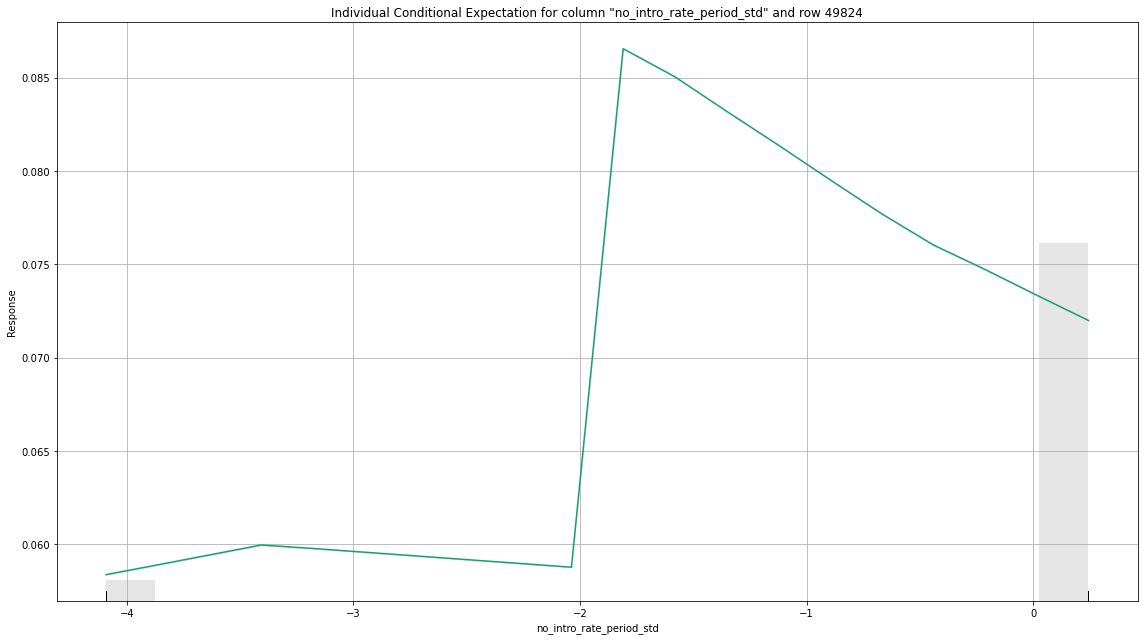

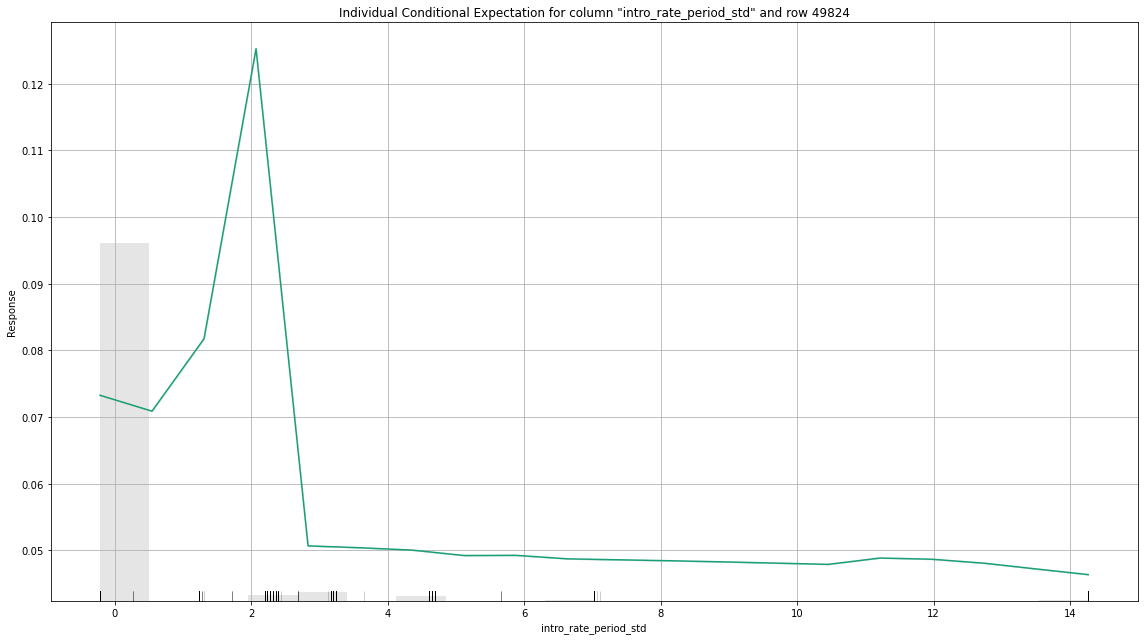

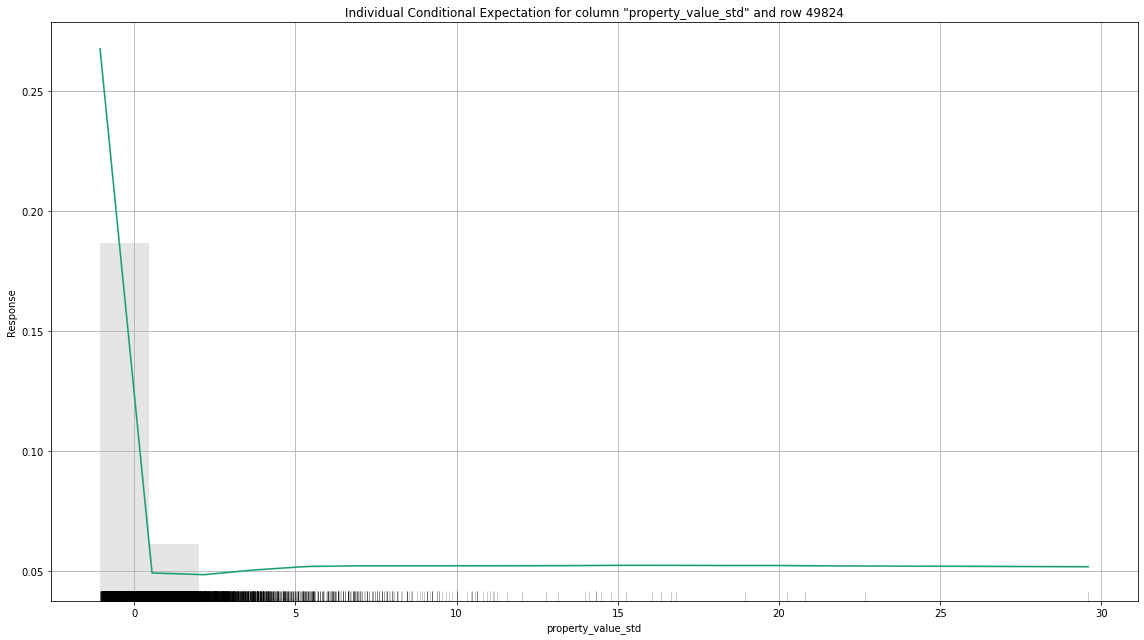

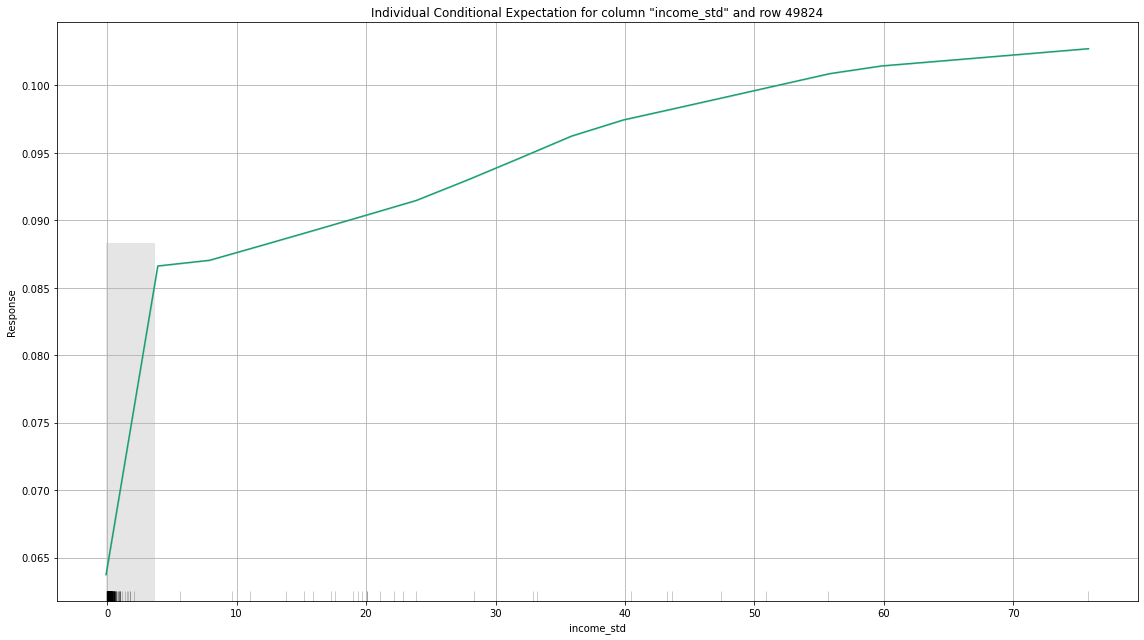

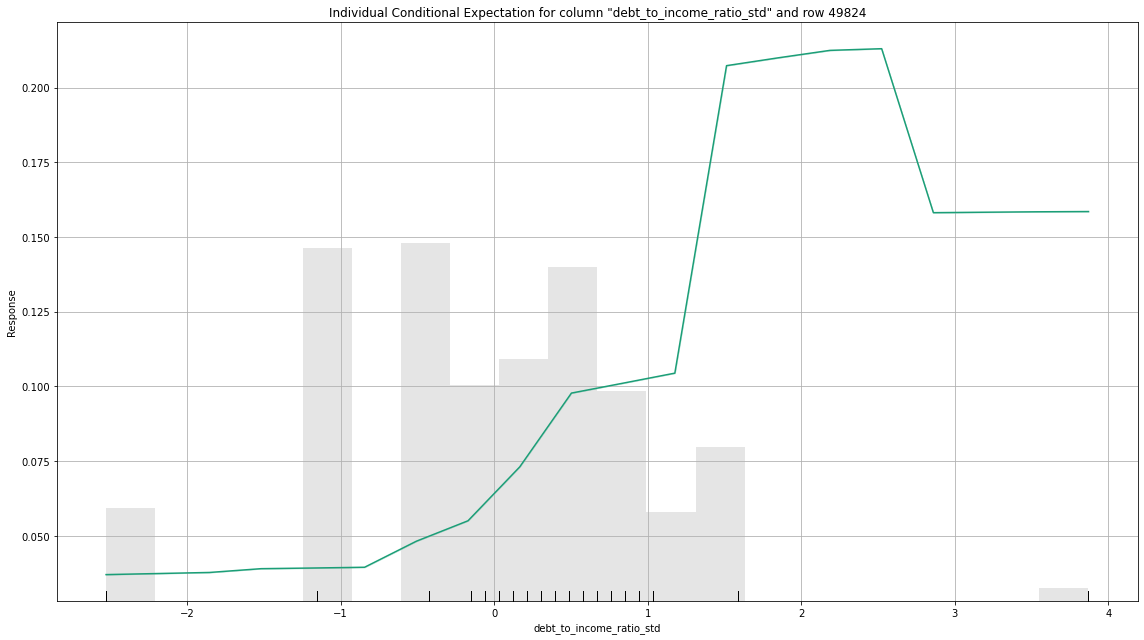

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

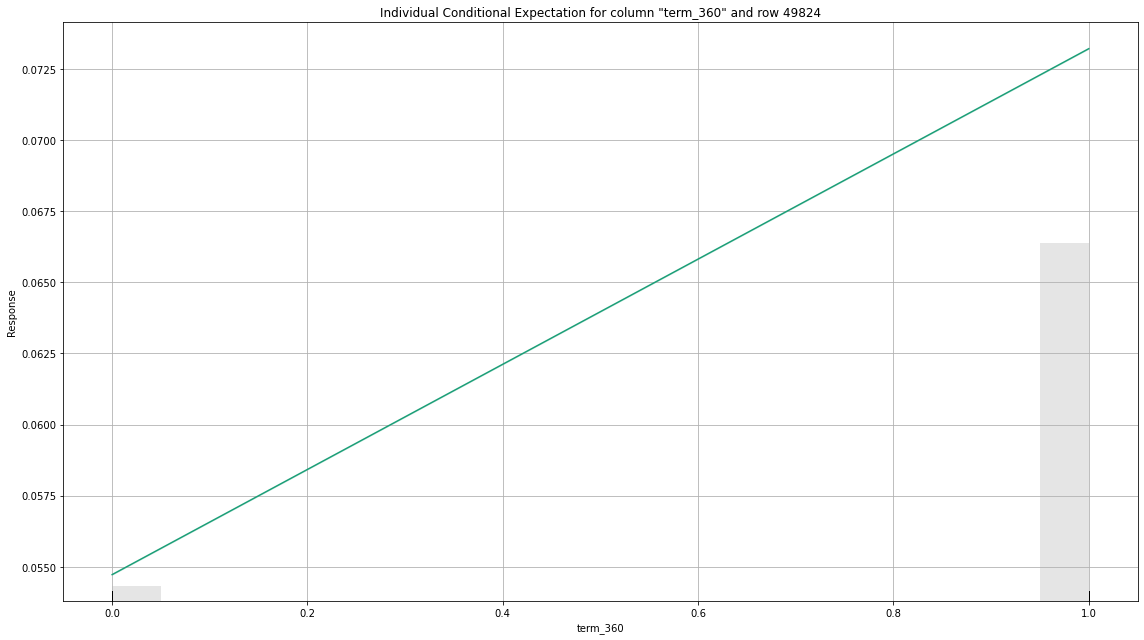

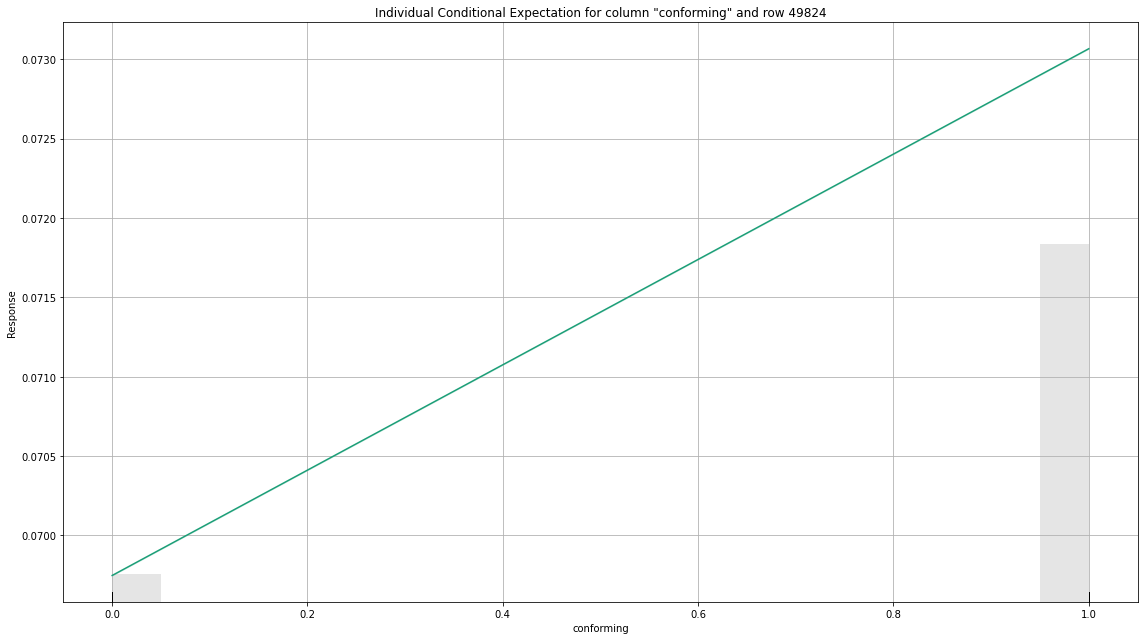

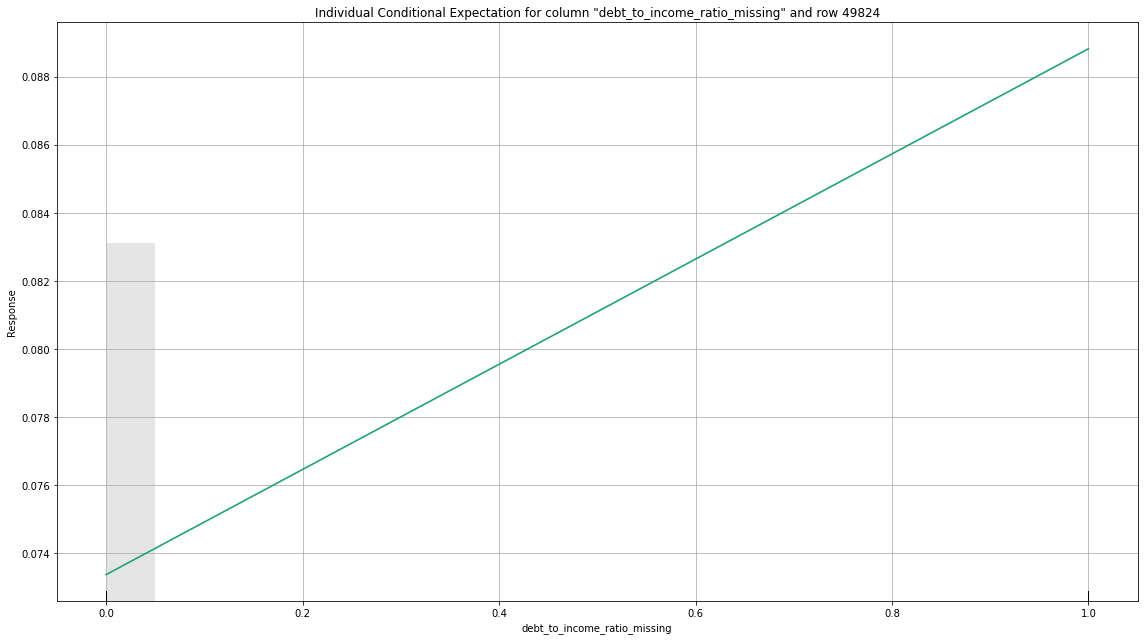

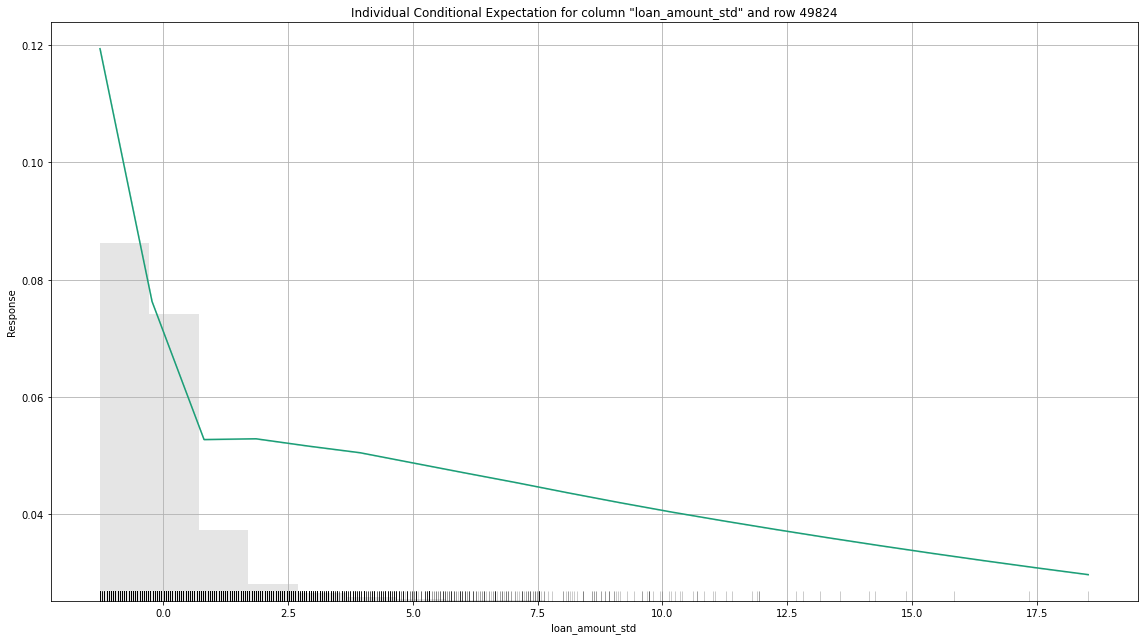

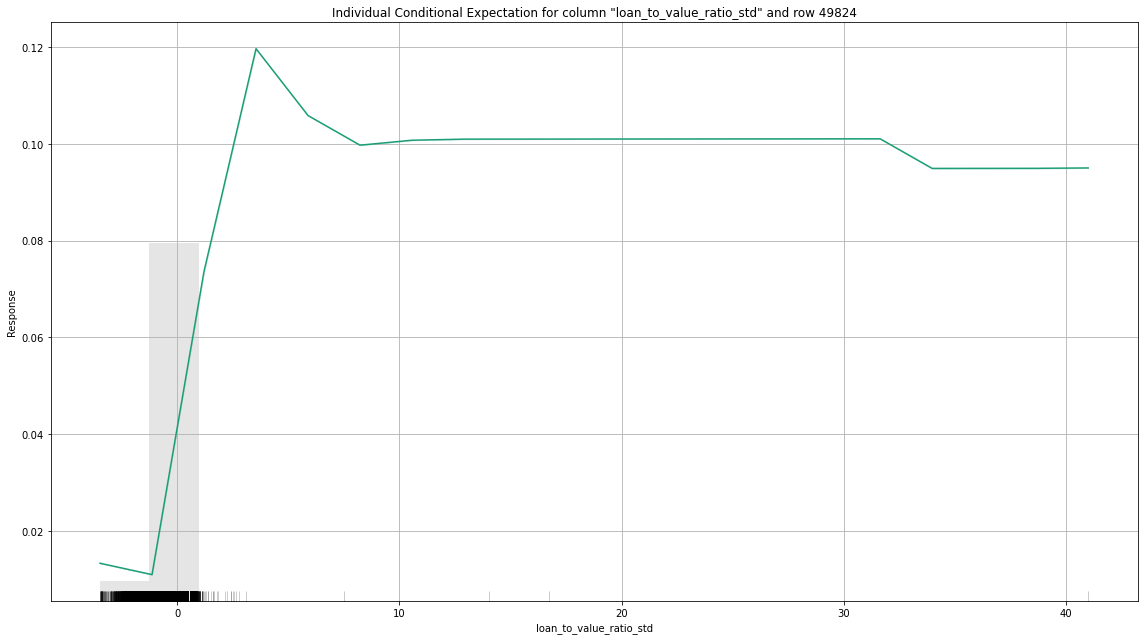

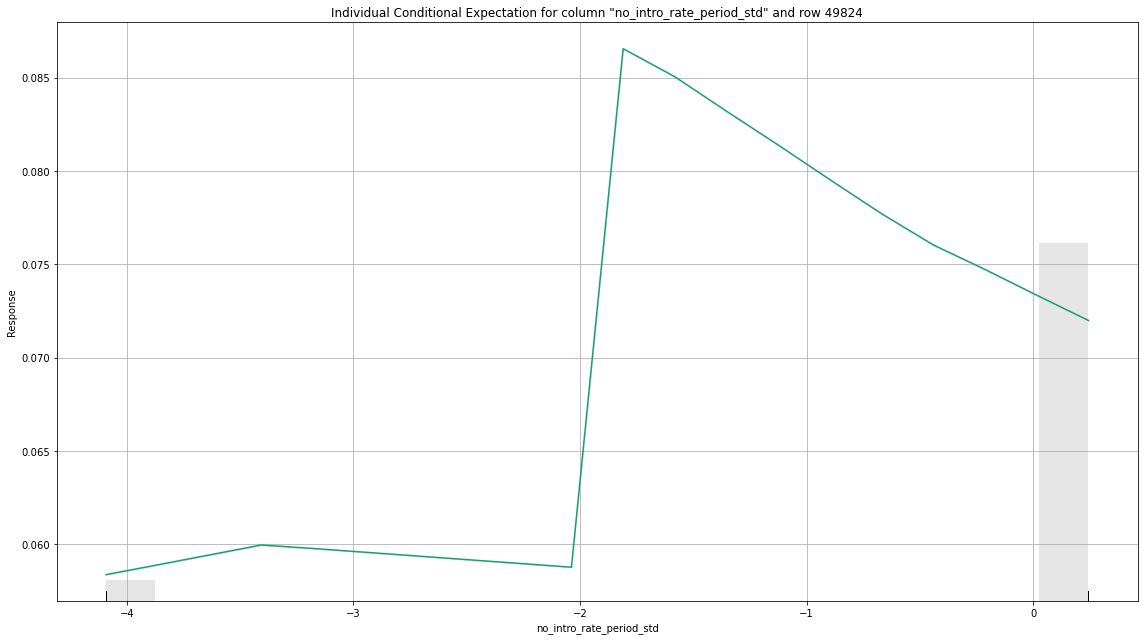

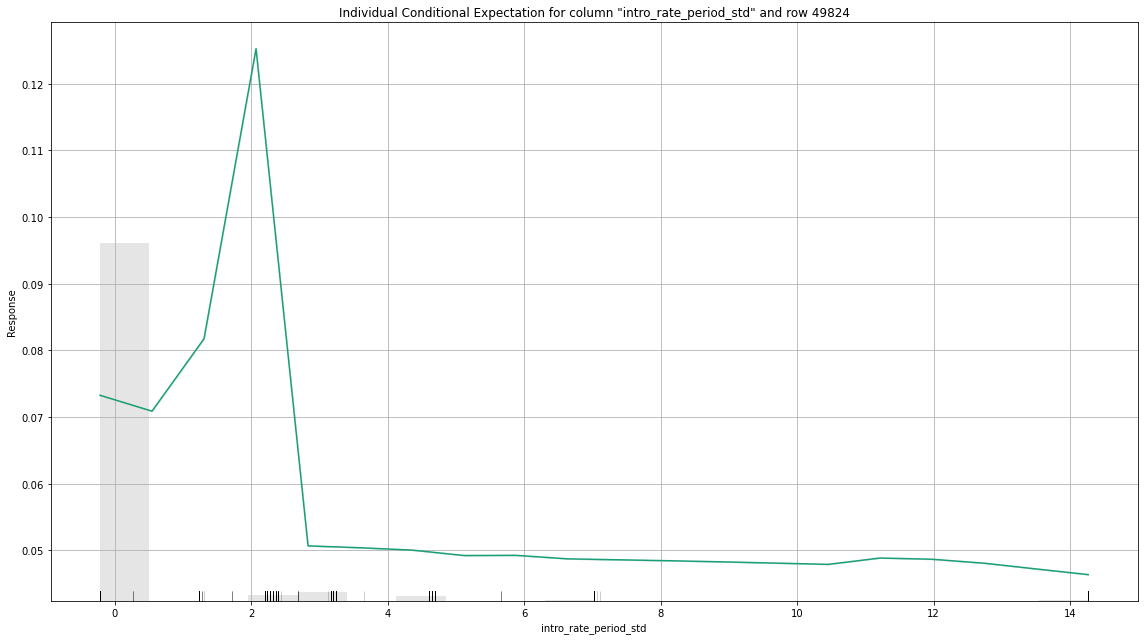

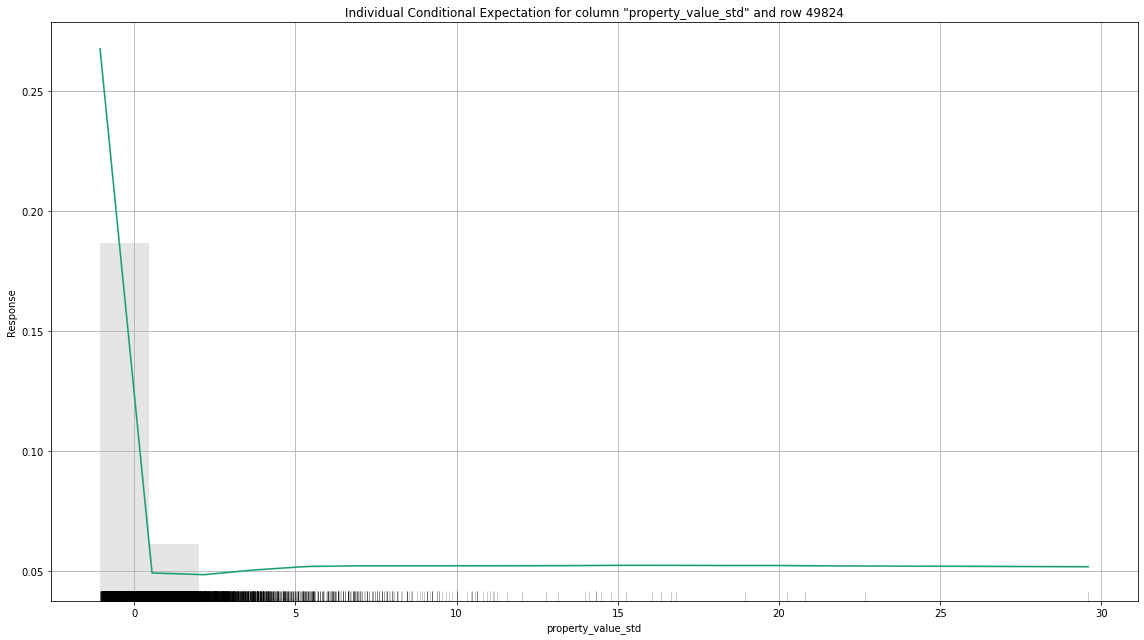

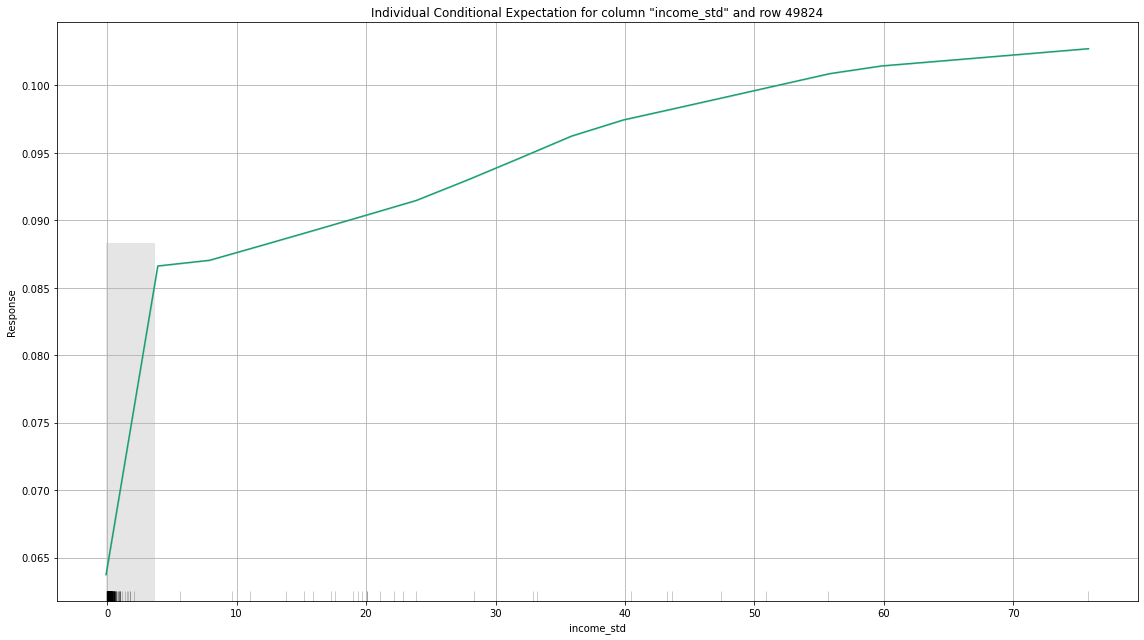

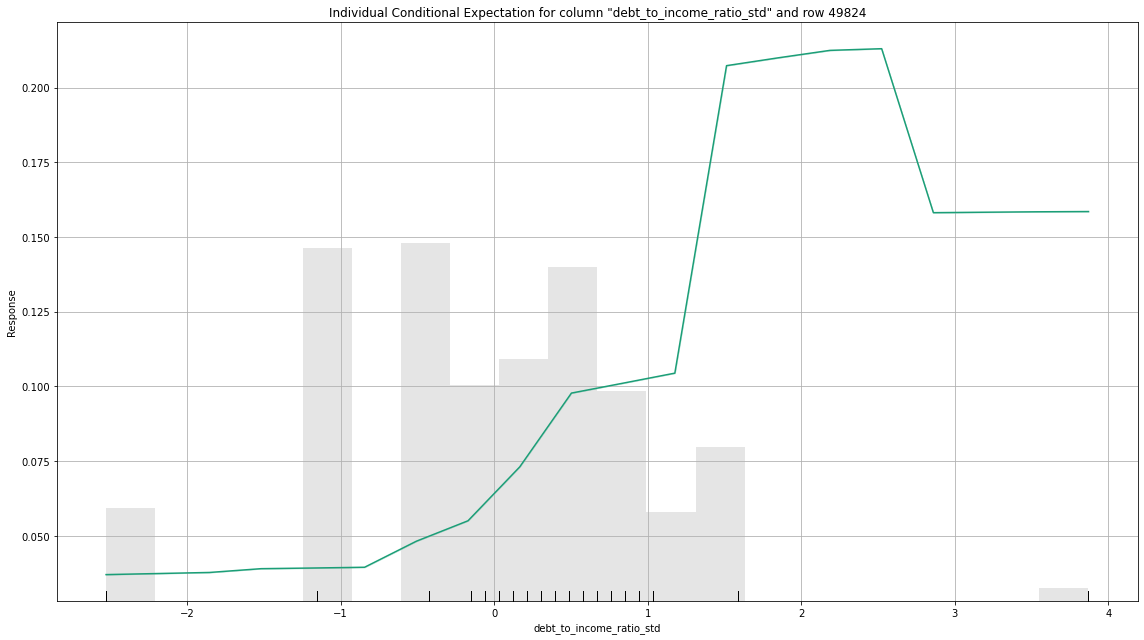

In [32]:
# Explain 90 percentile
ensenble_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[90]))

### H2O Analysis: gbm

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

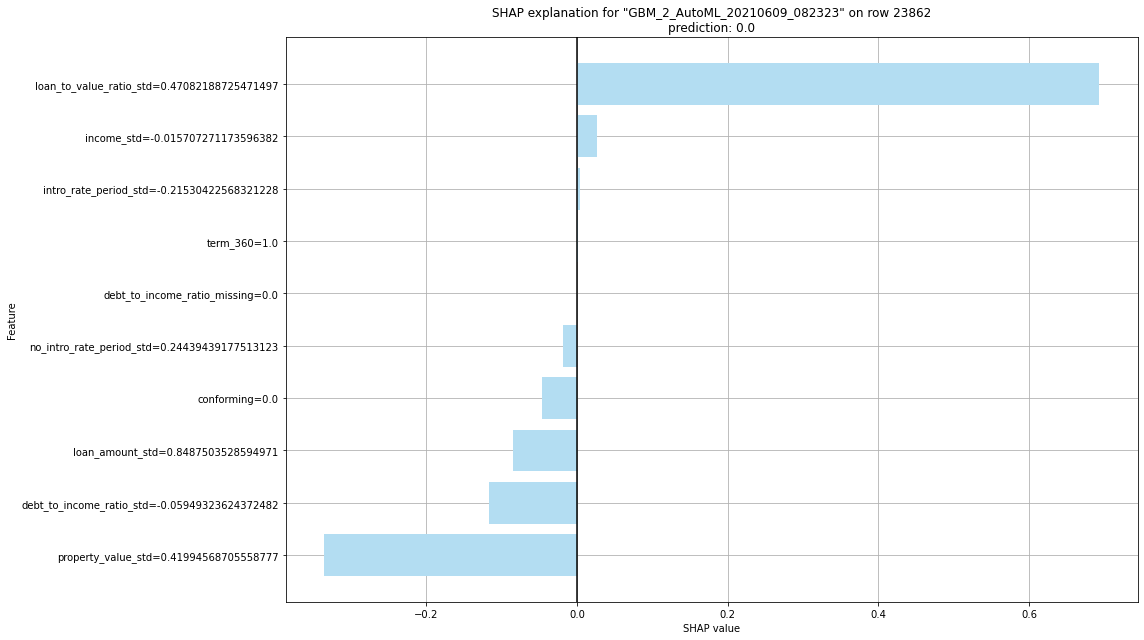

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

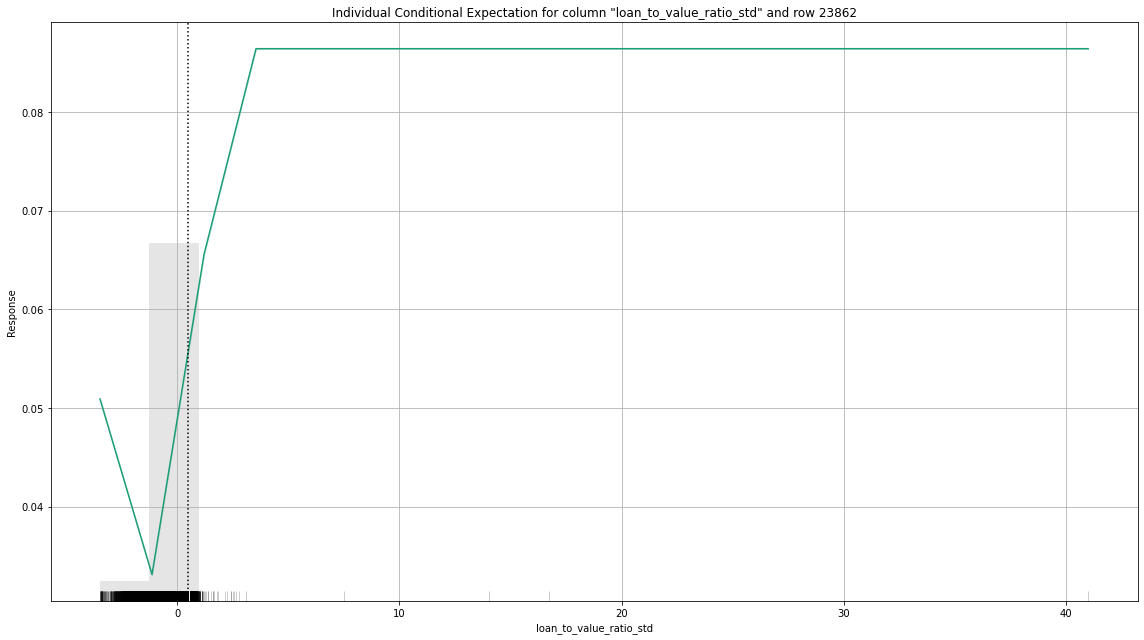

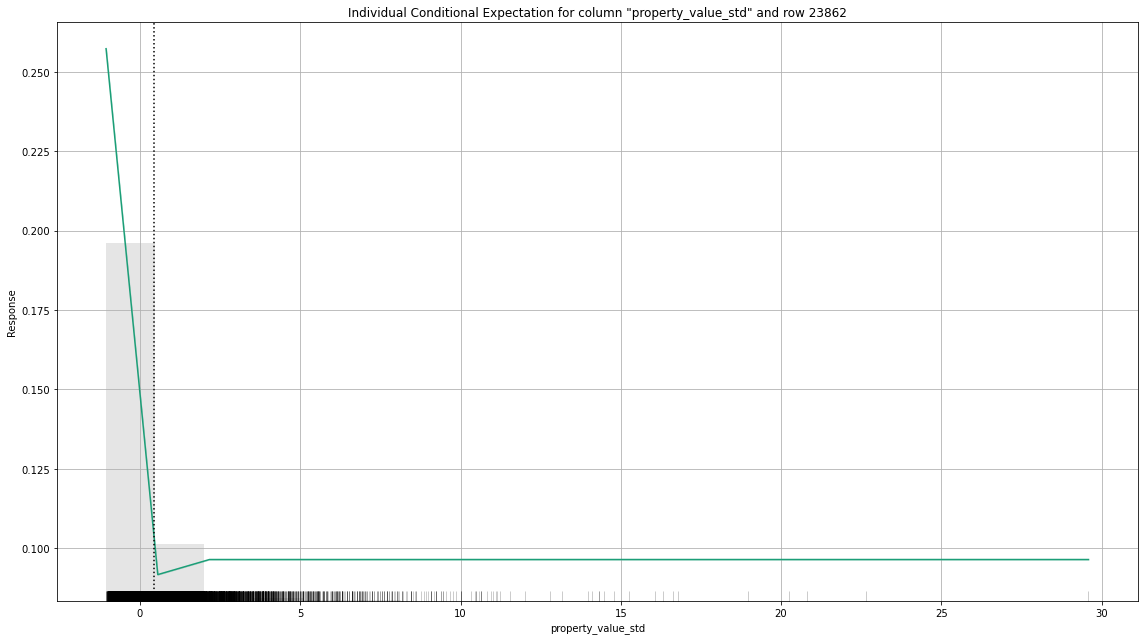

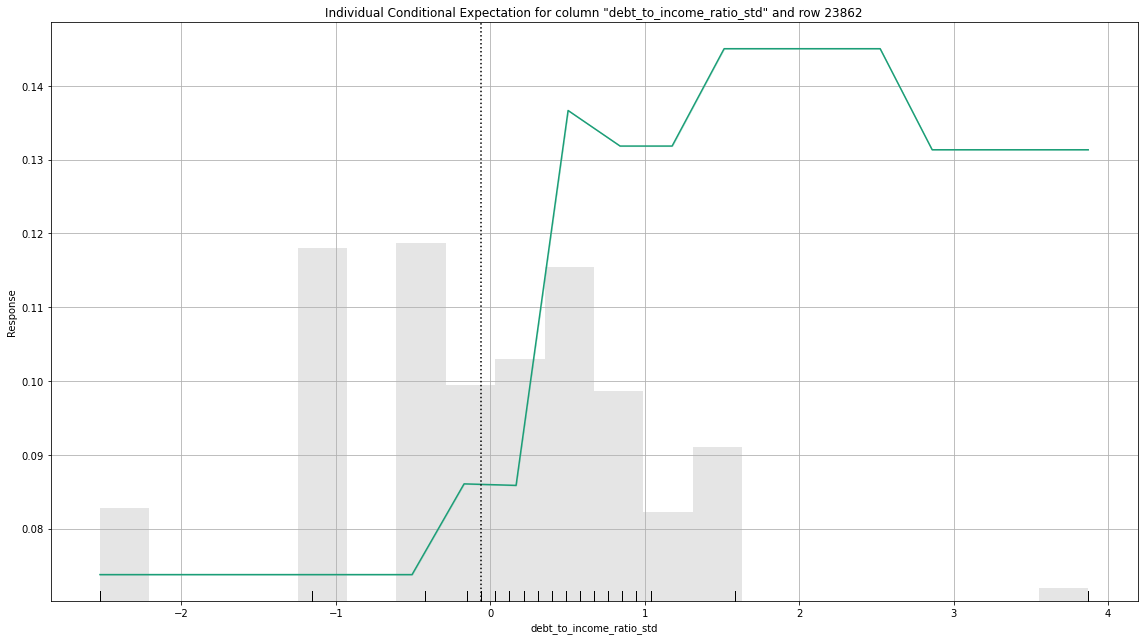

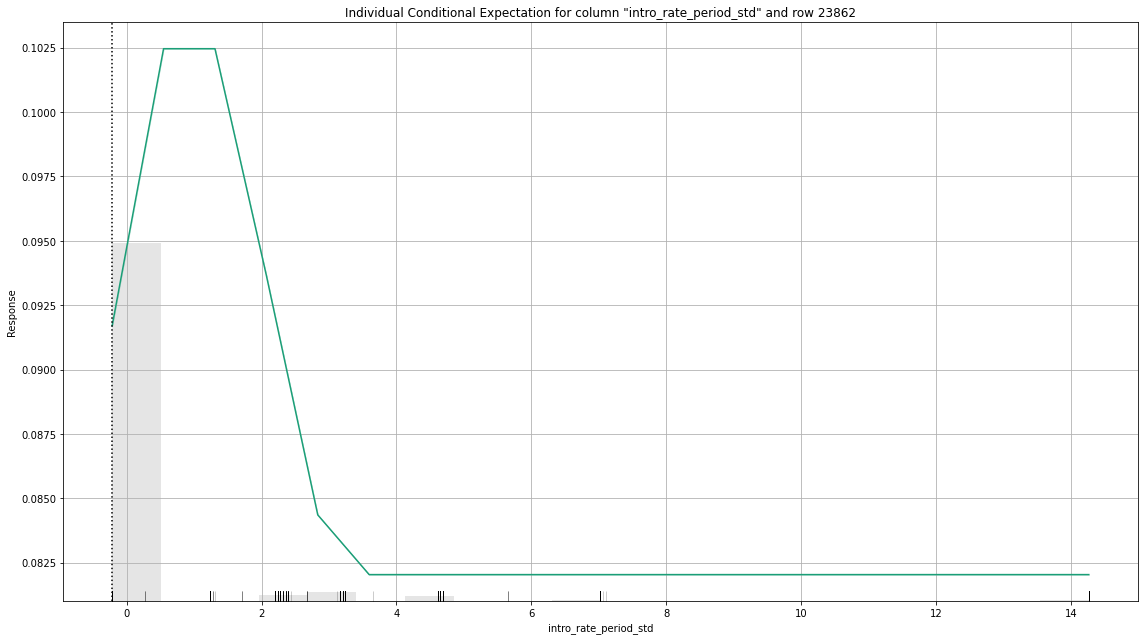

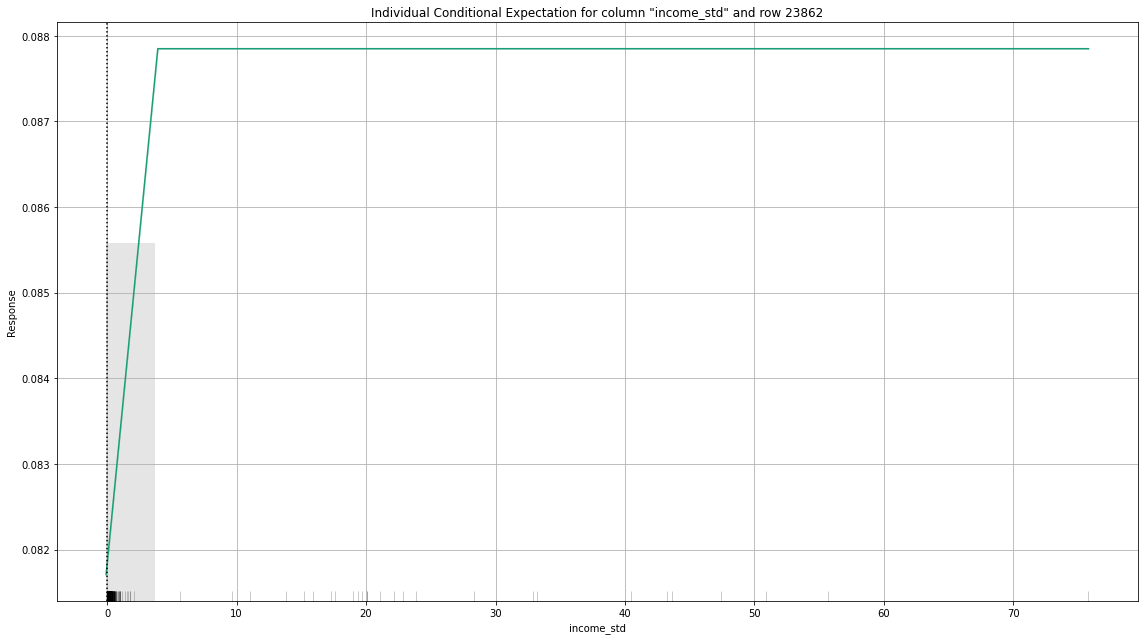

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

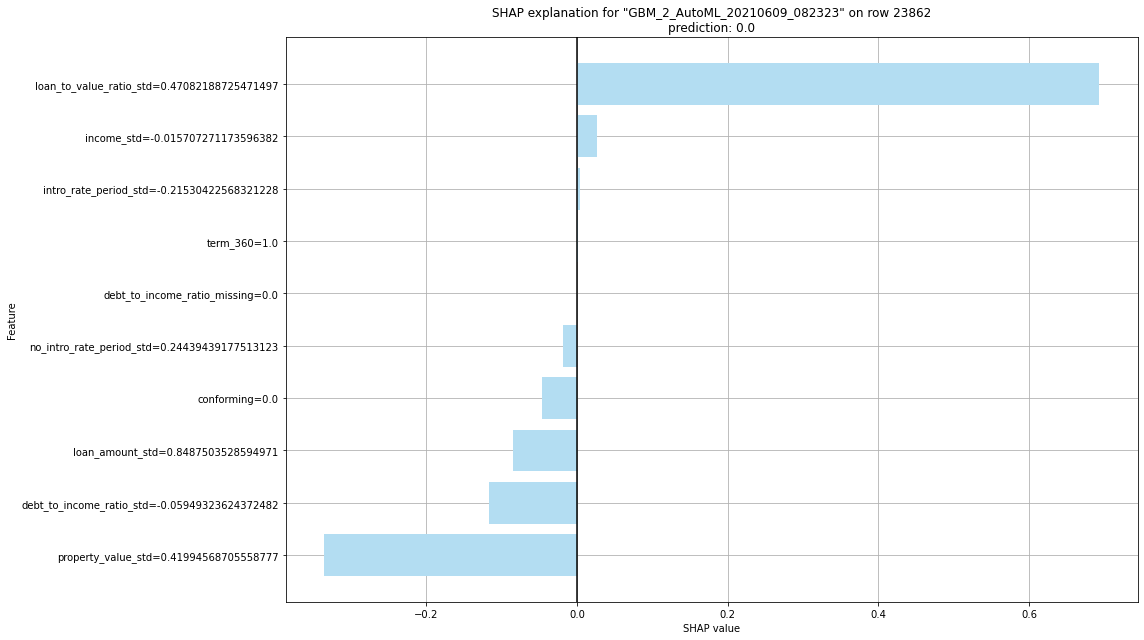

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

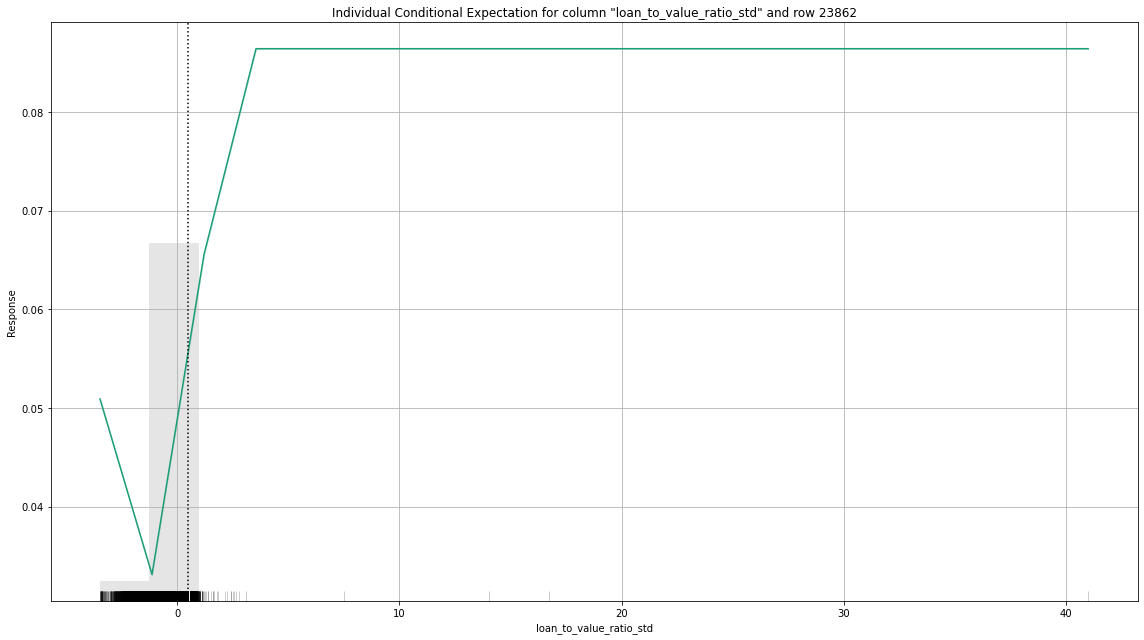

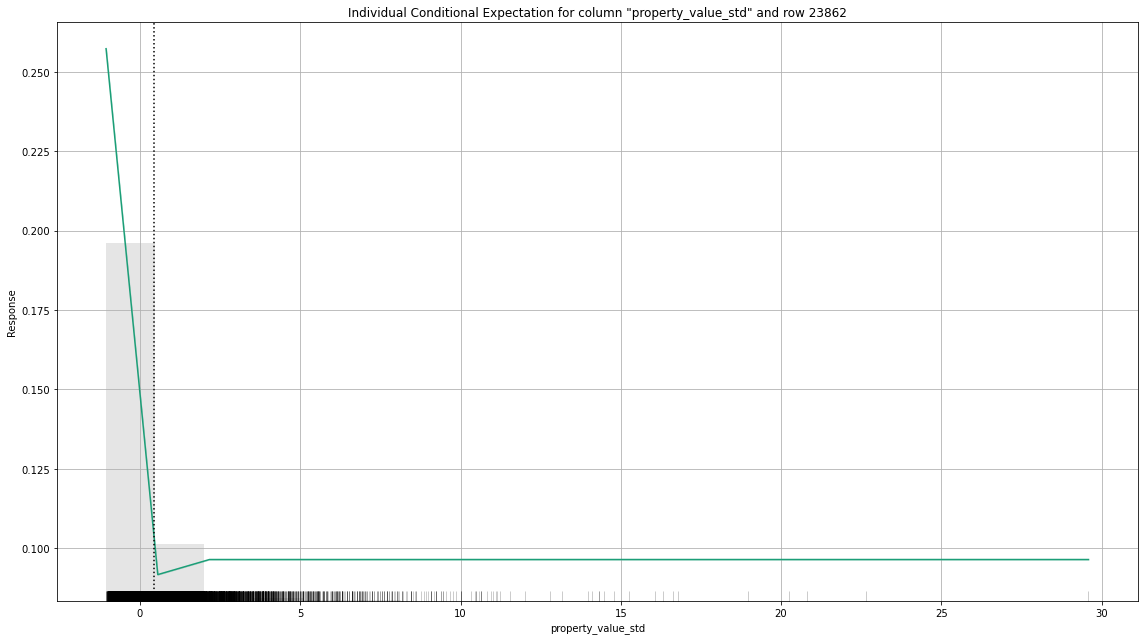

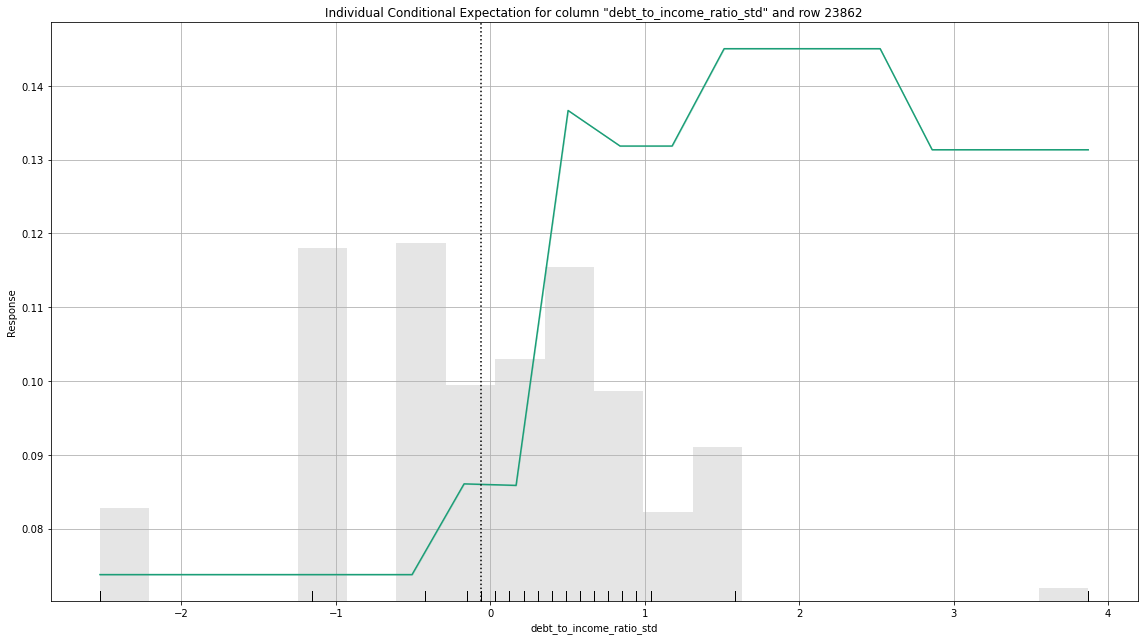

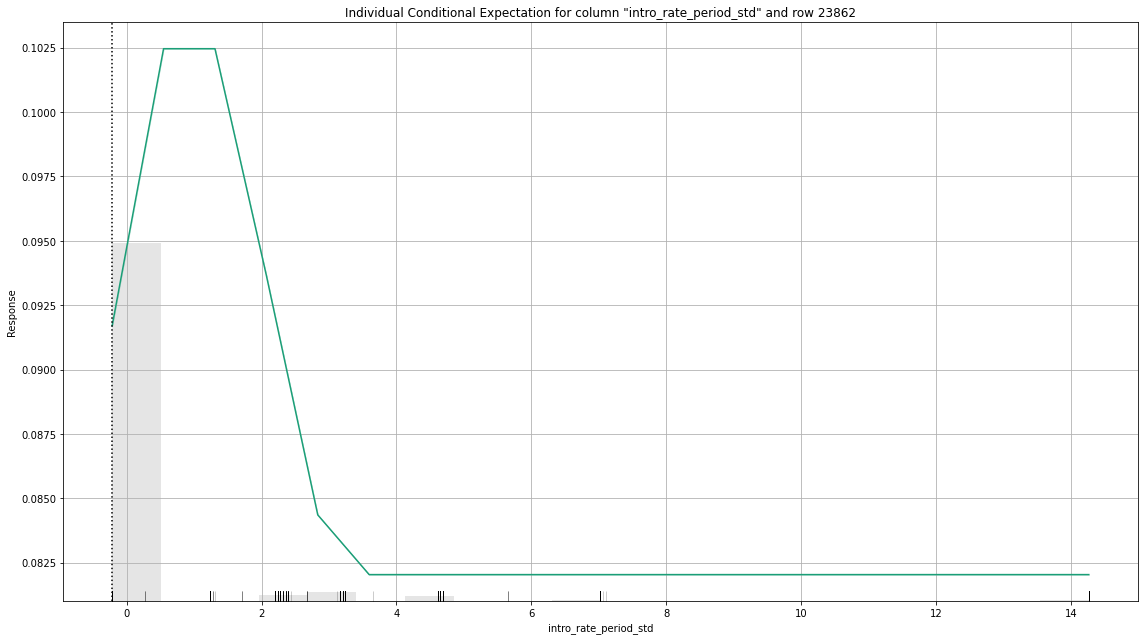

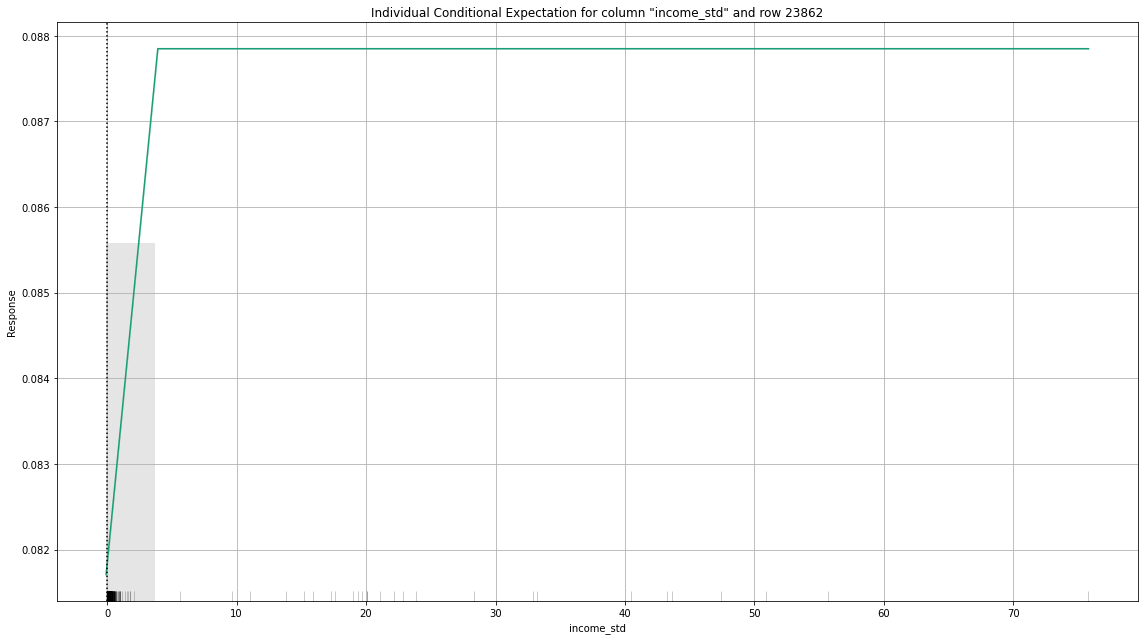

In [33]:
# Explain 10 percentile
gbm_h2o.explain_row(hvalid, row_index=int(gbm_percentile_dict[10]))

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

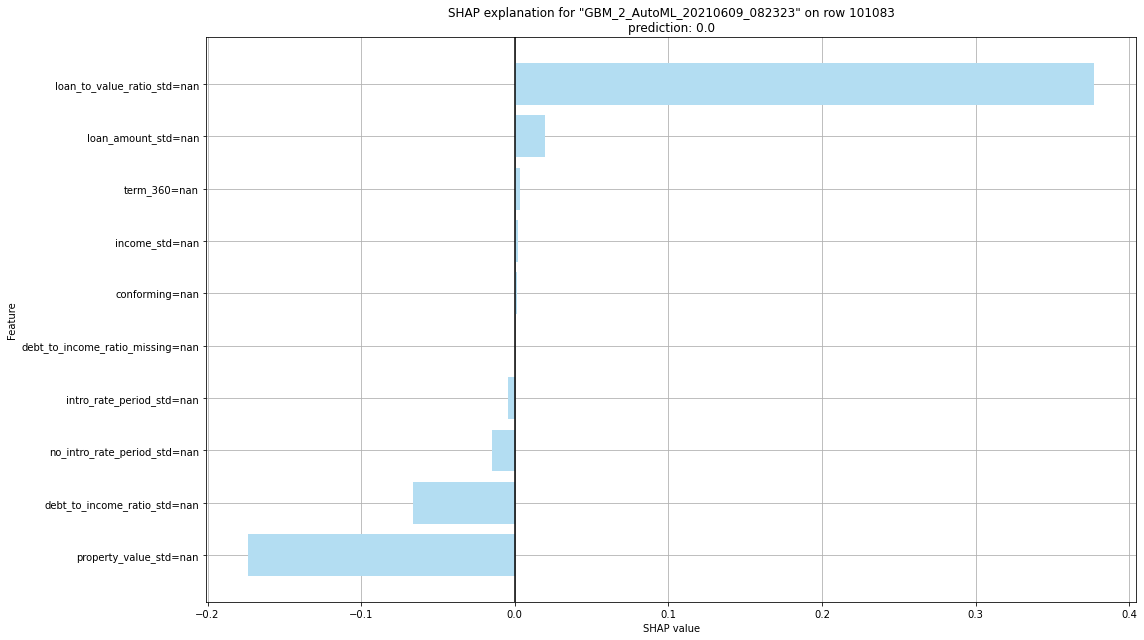

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

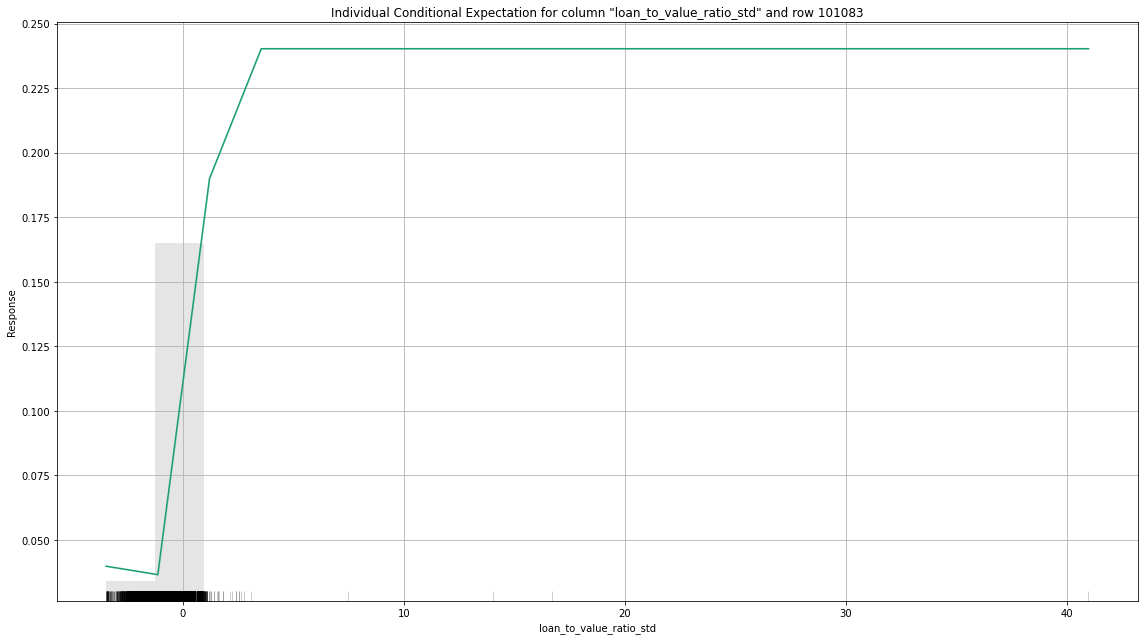

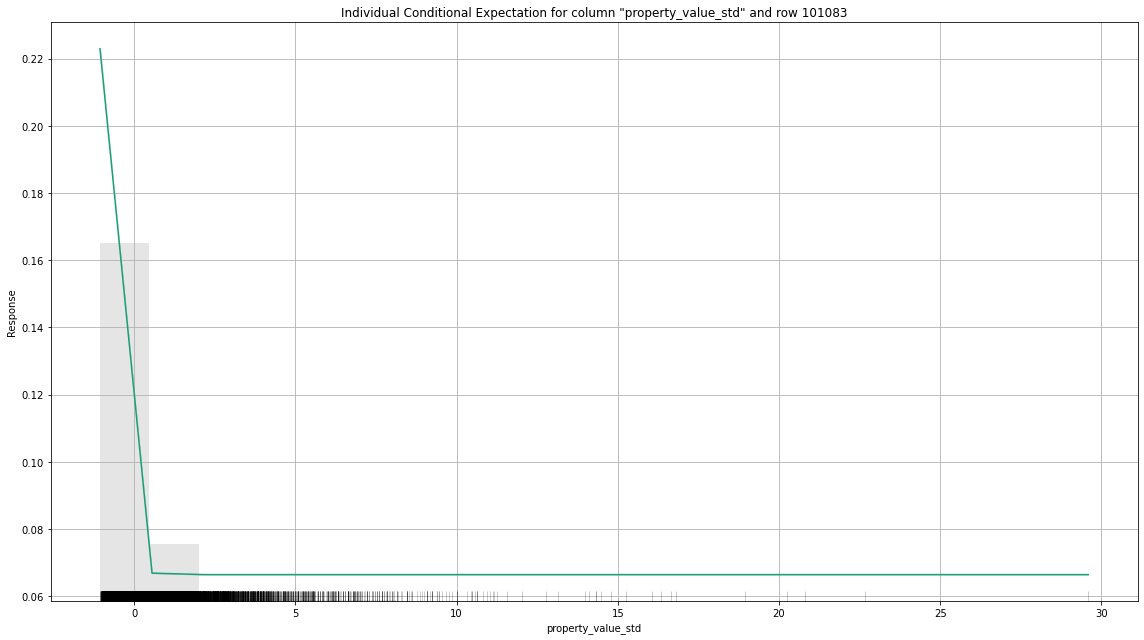

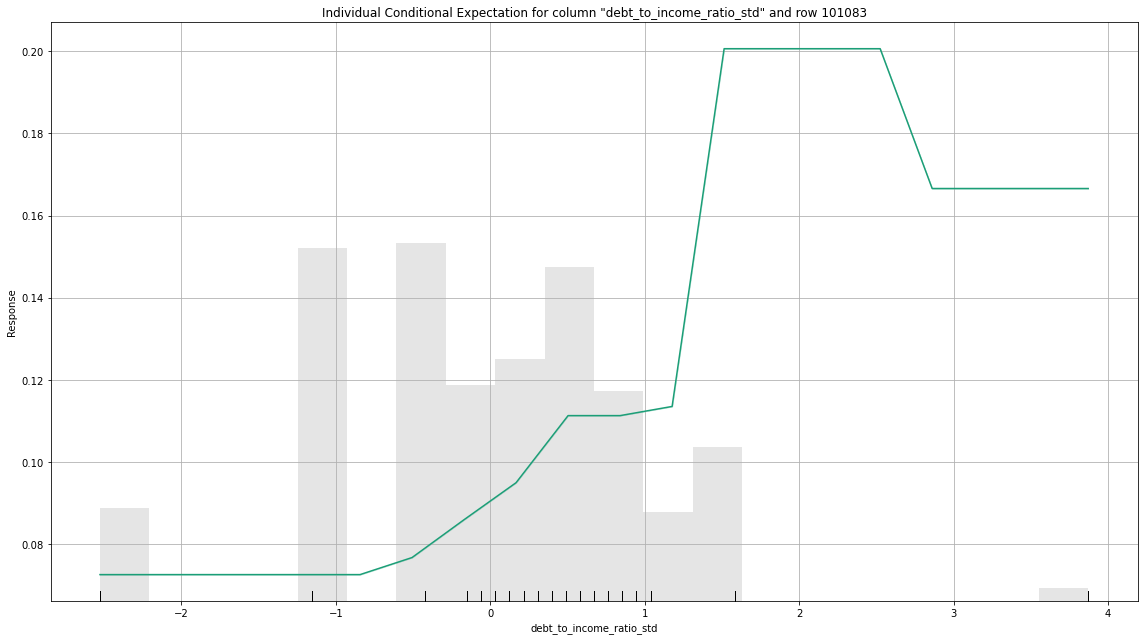

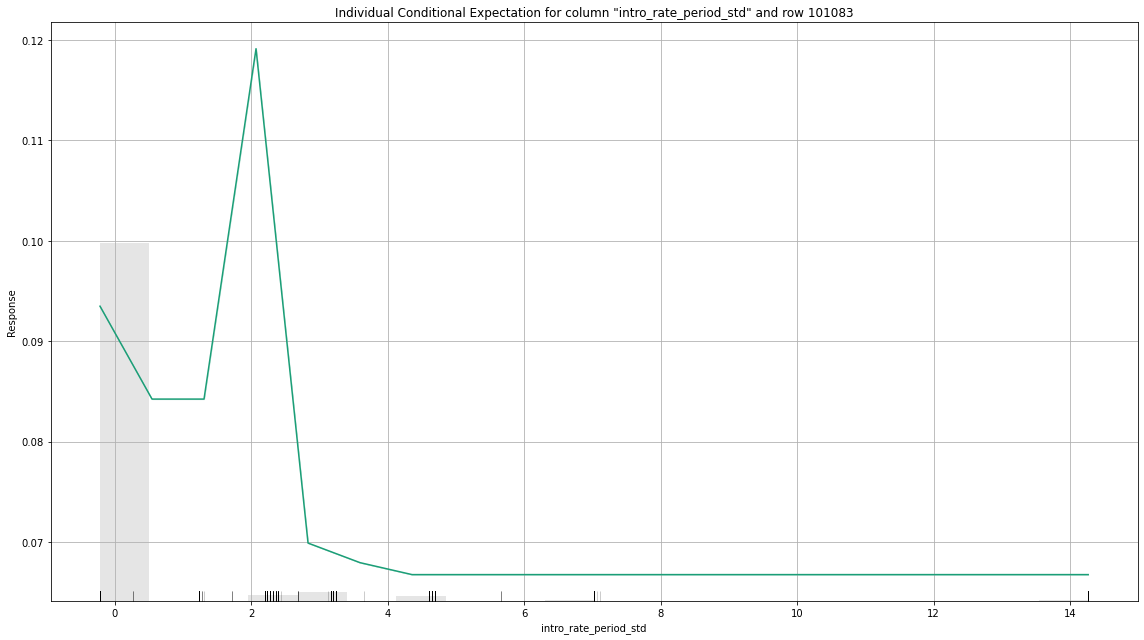

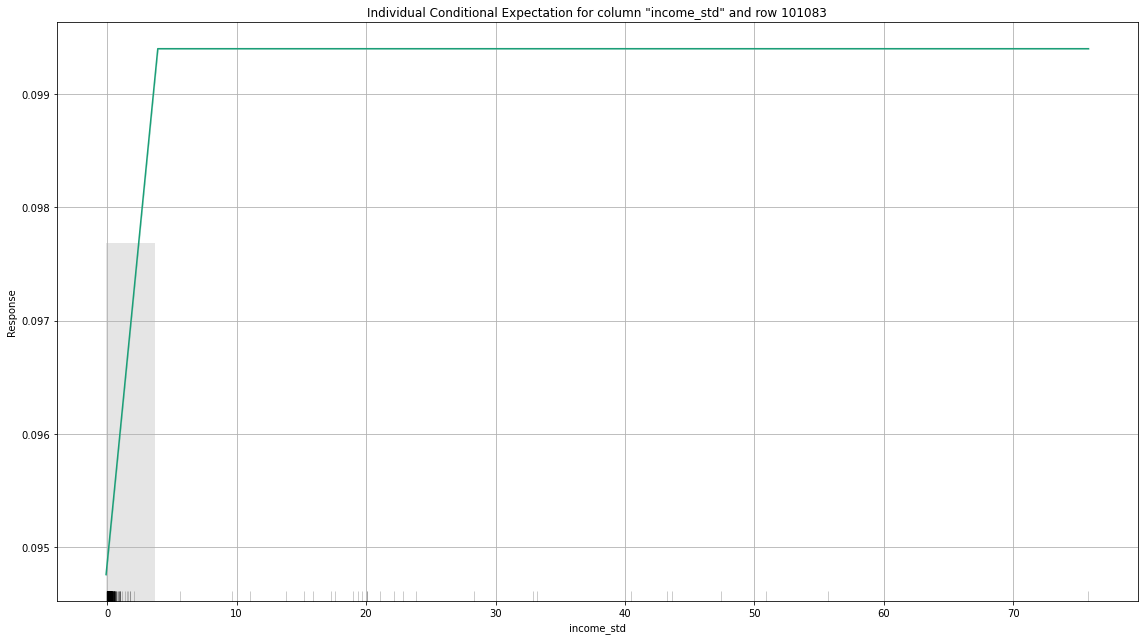

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

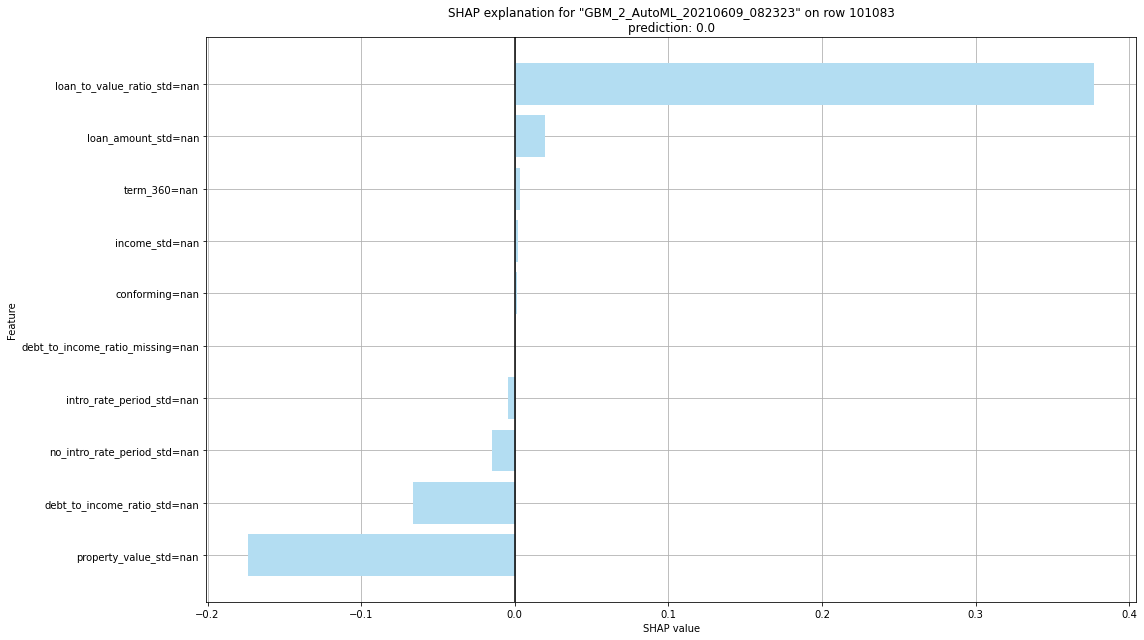

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

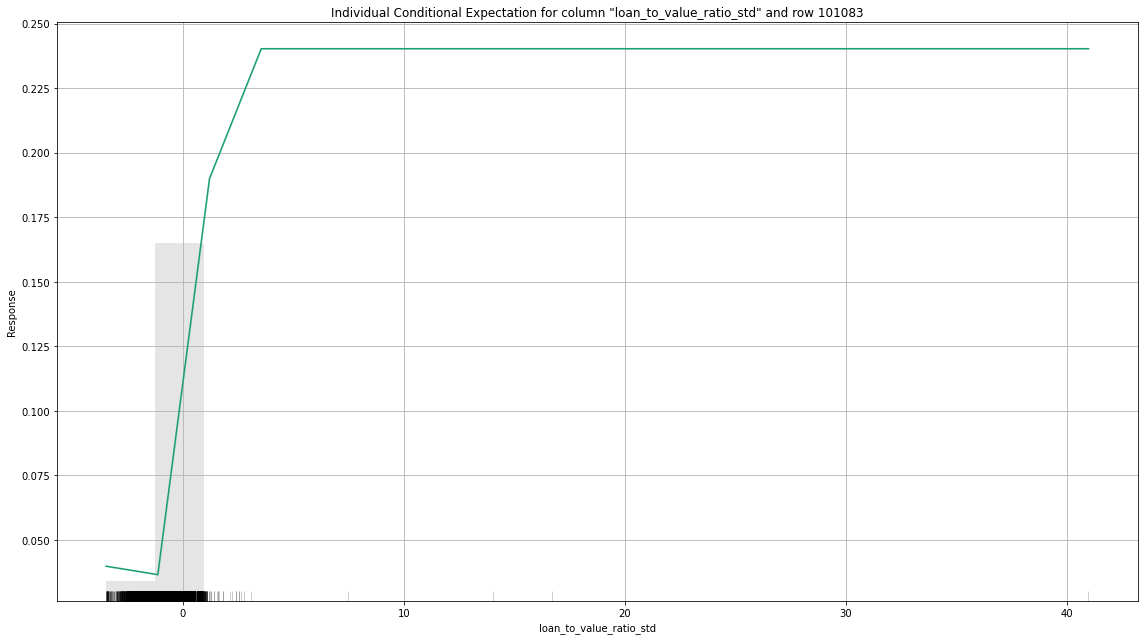

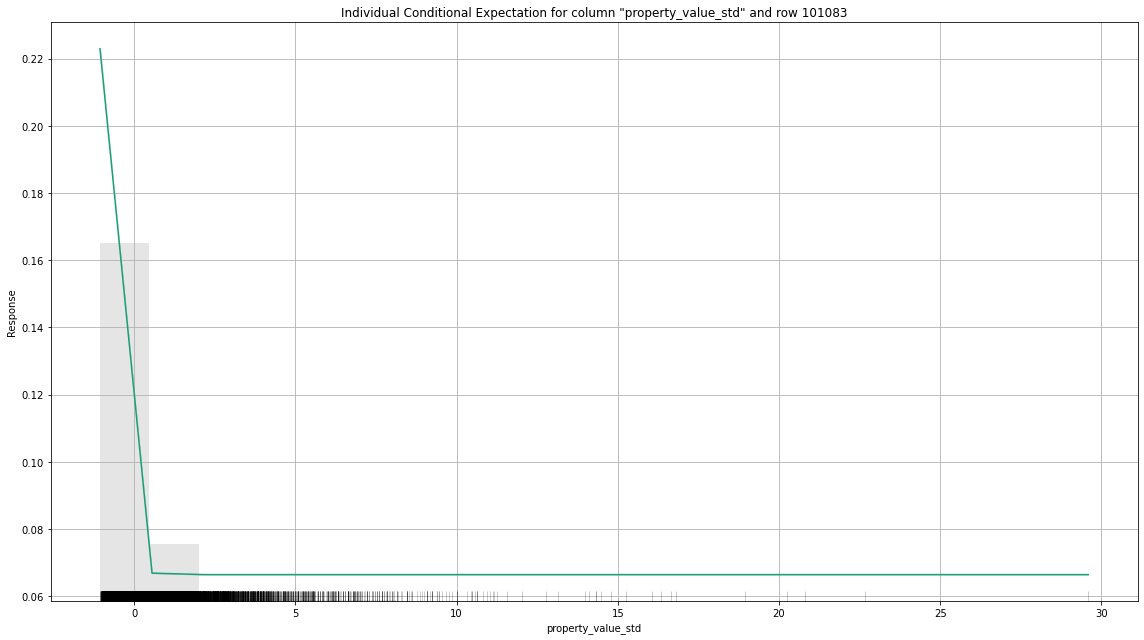

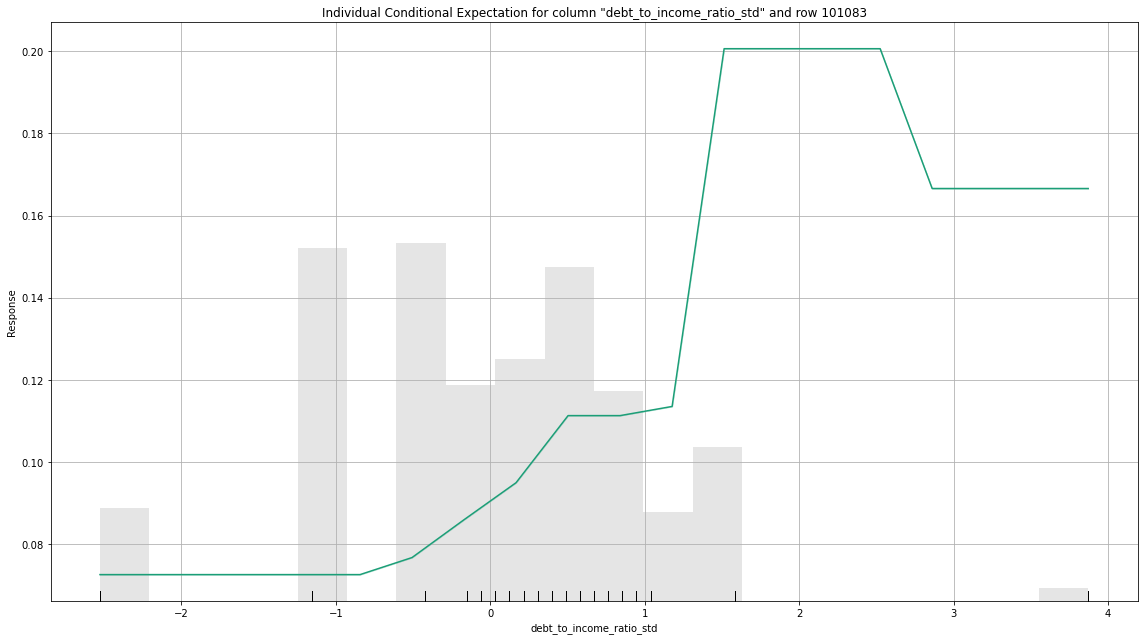

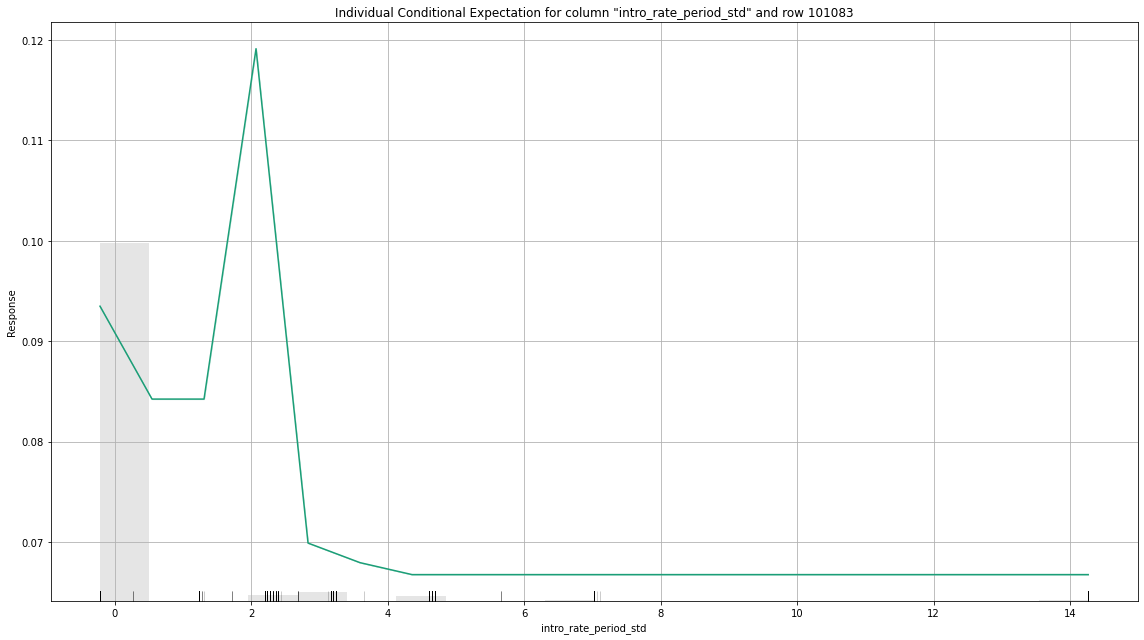

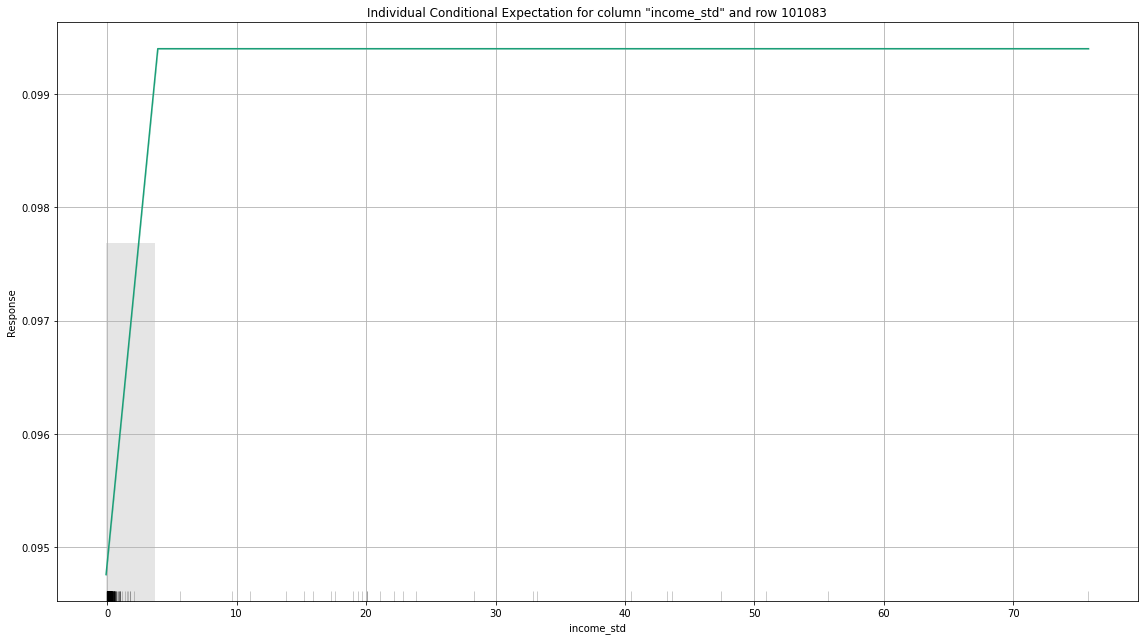

In [34]:
# Explain 50 percentile
gbm_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[50]))

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

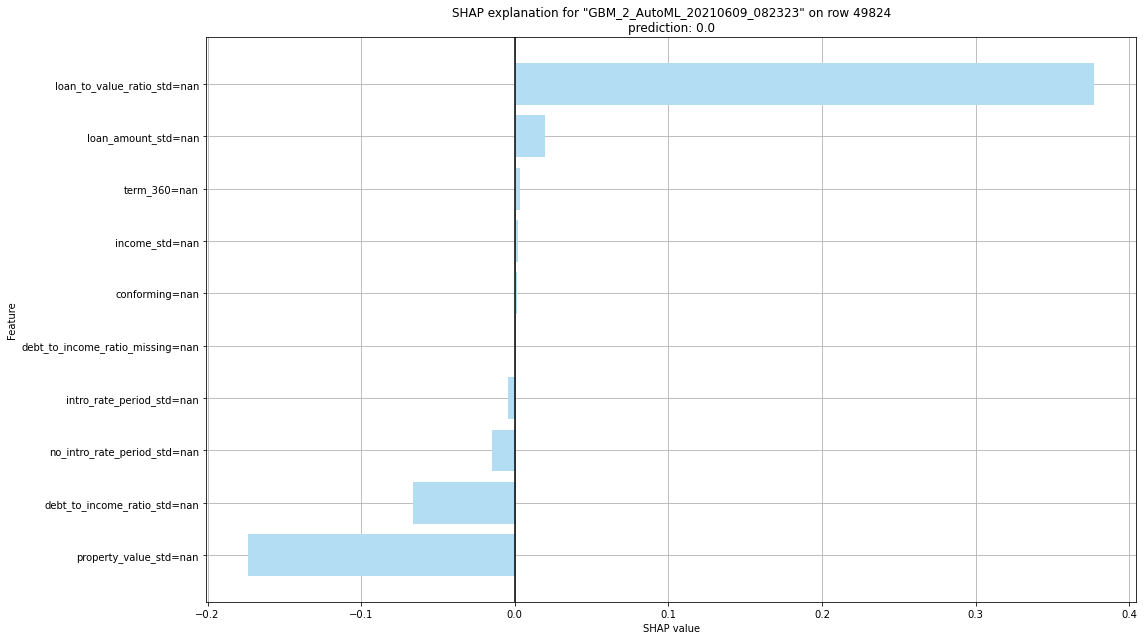

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

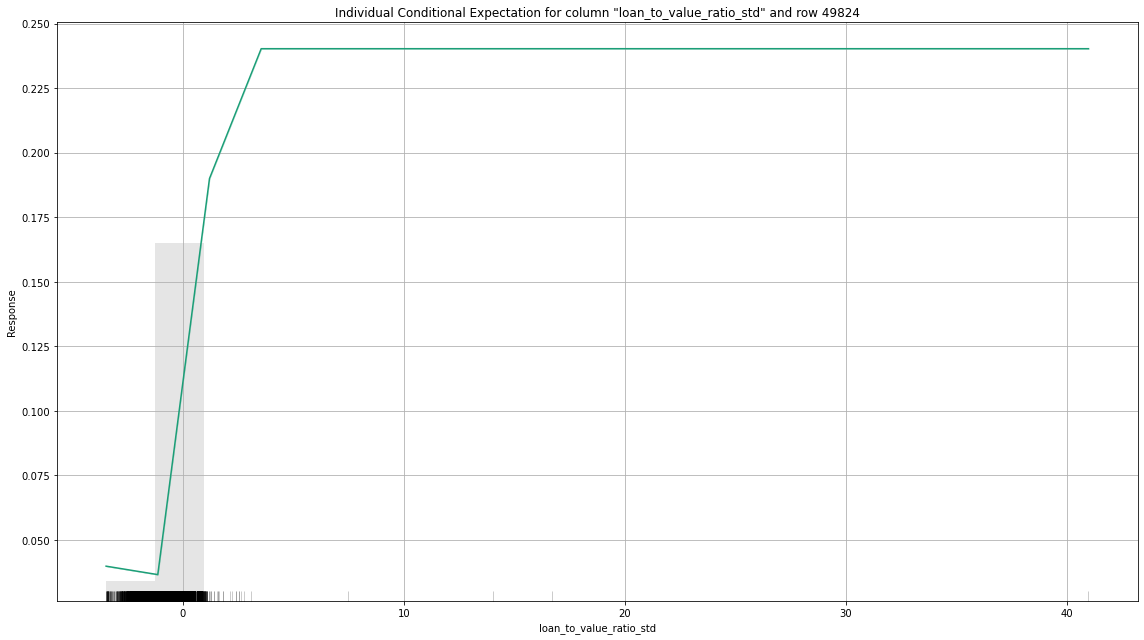

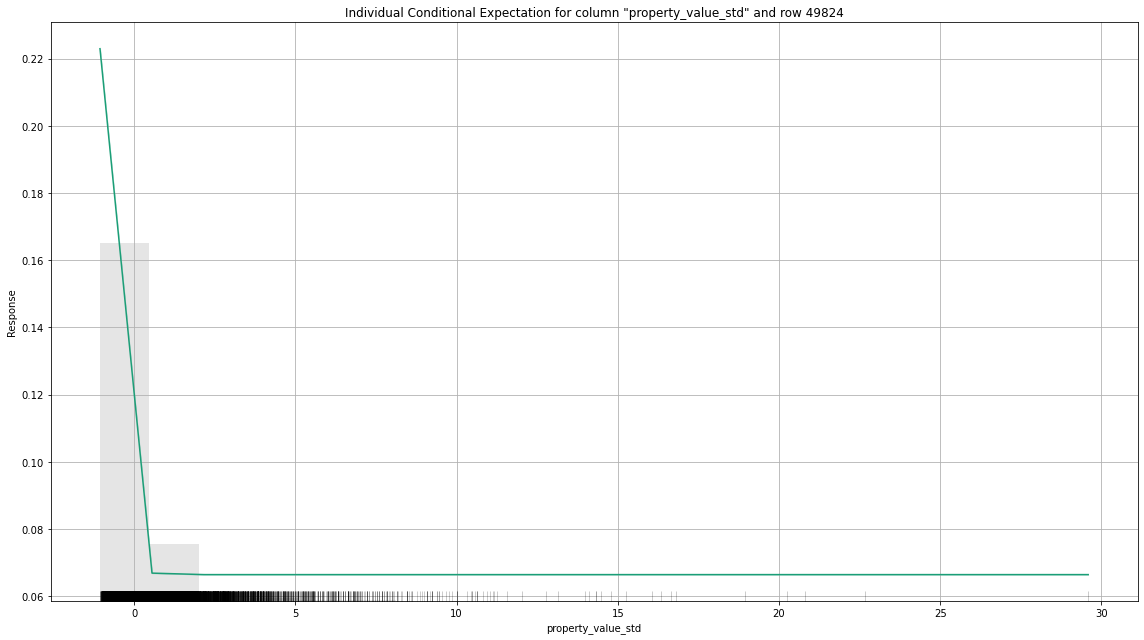

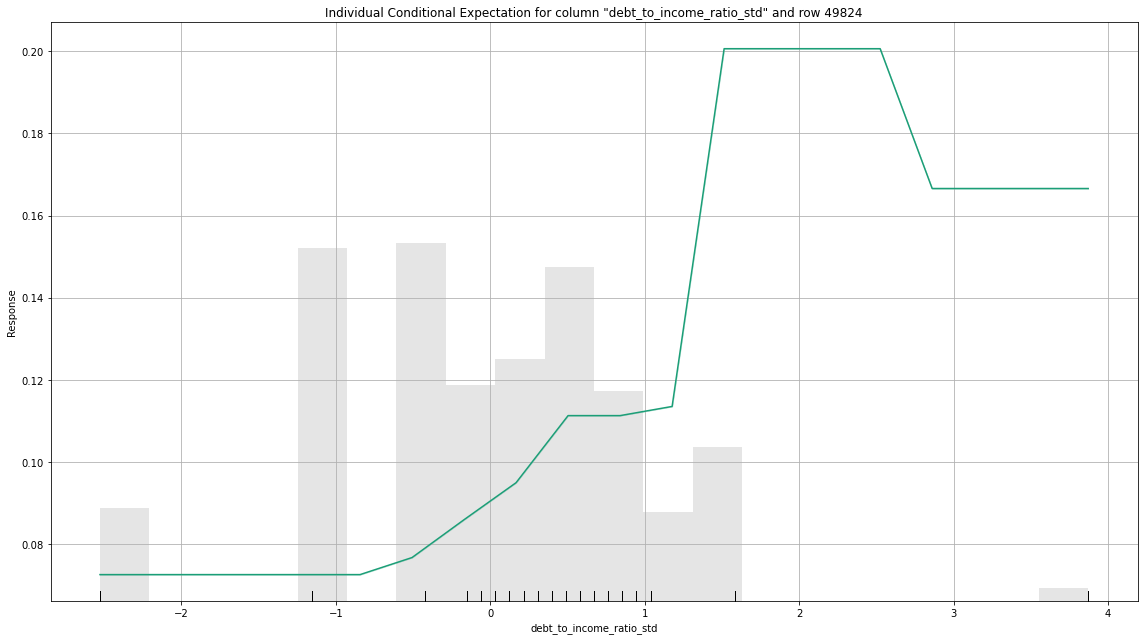

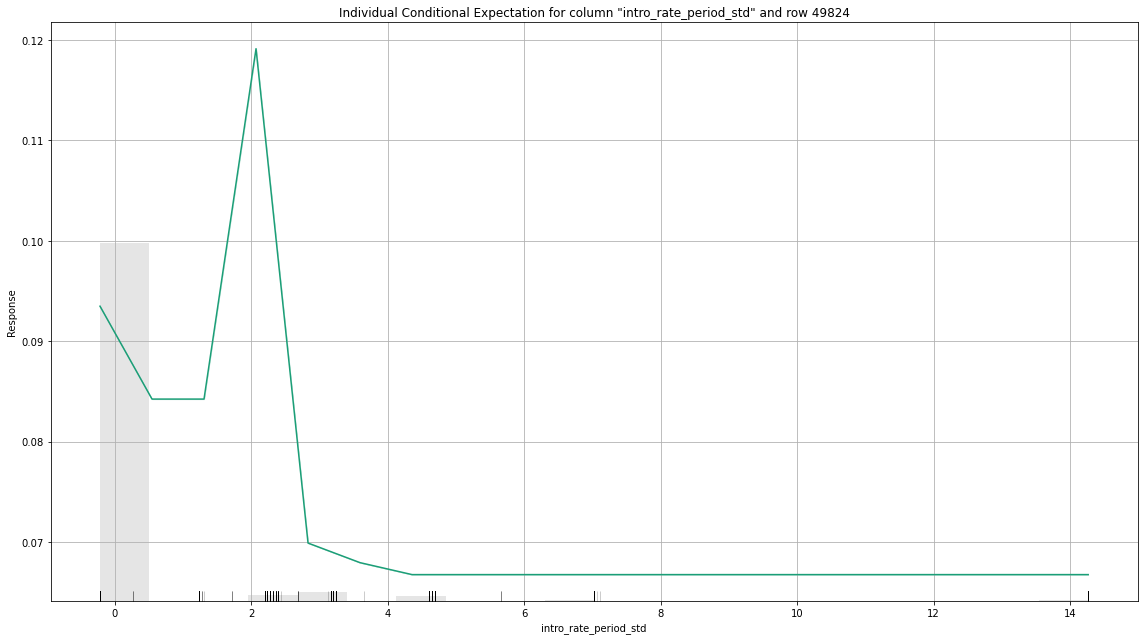

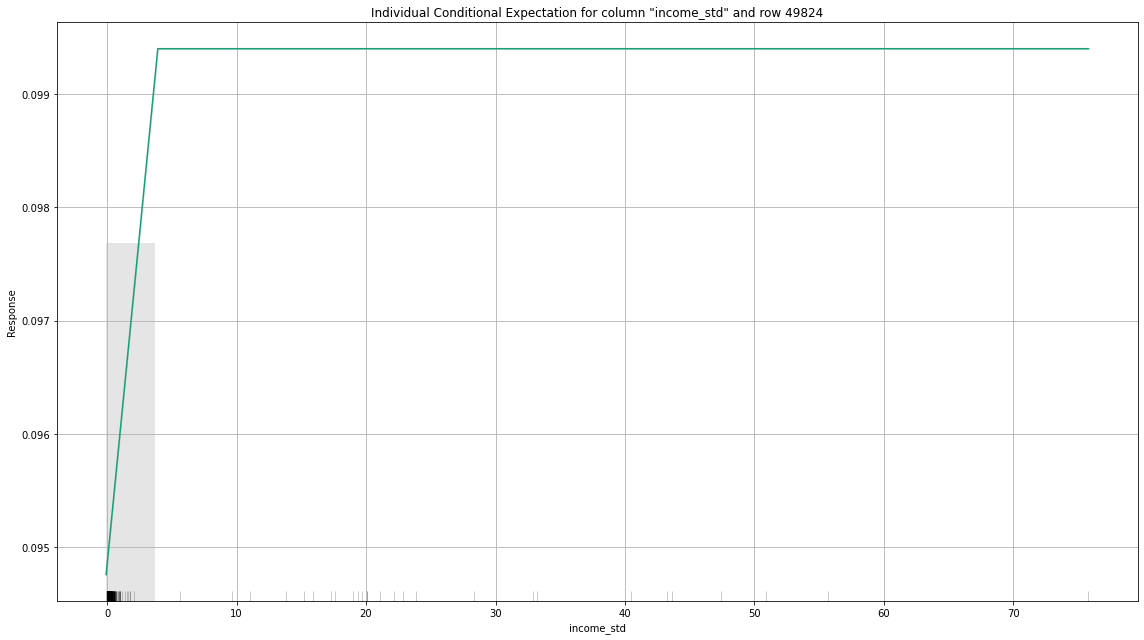

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

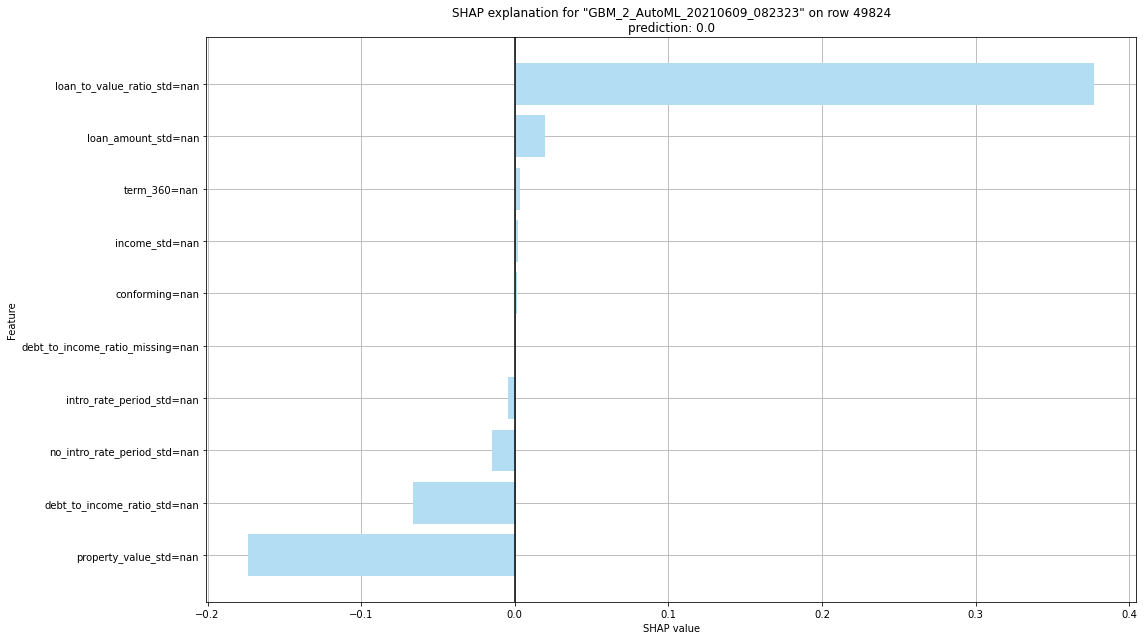

# Individual Conditional Expectation

> Individual conditional expectations (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response for a given row. ICE plot is similar to partial dependence plot (PDP), PDP shows the average effect of a feature while ICE plot shows the effect for a single instance.

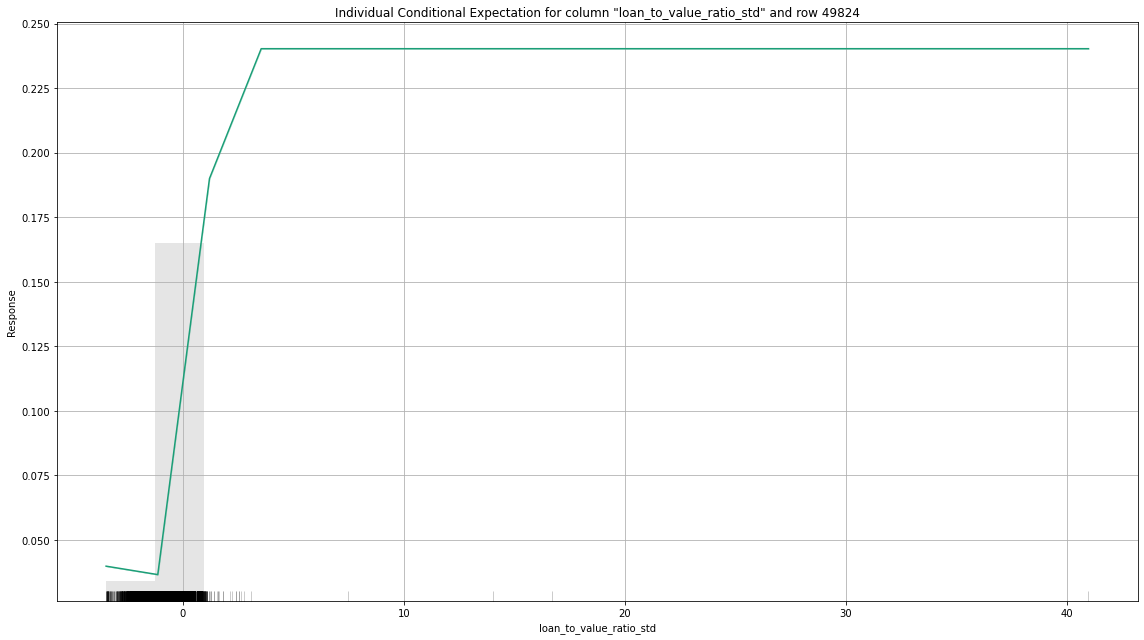

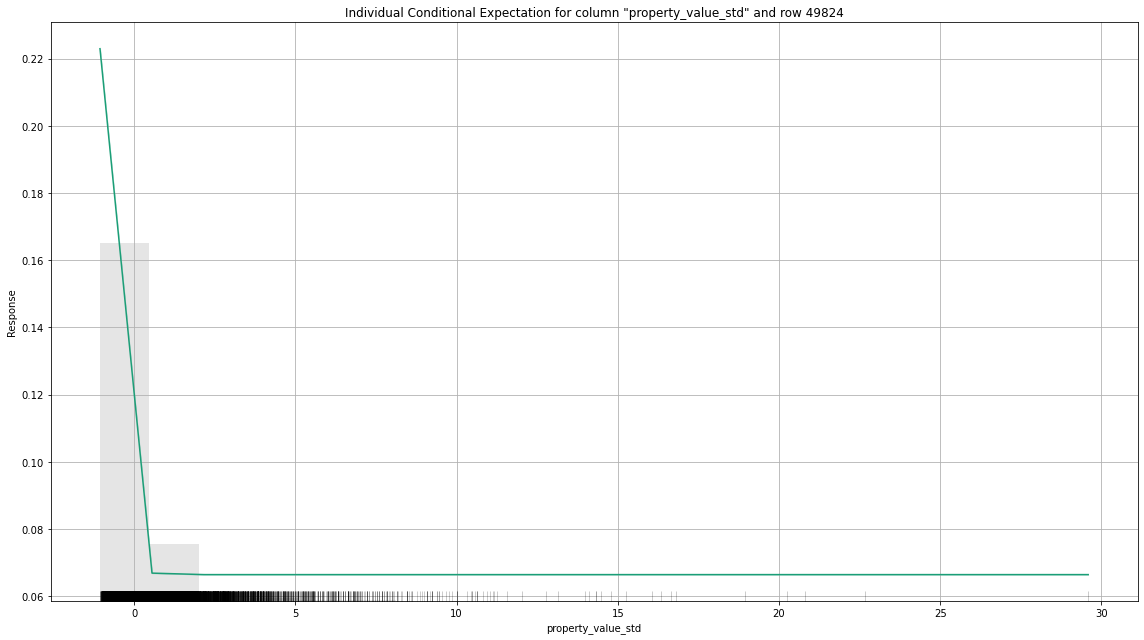

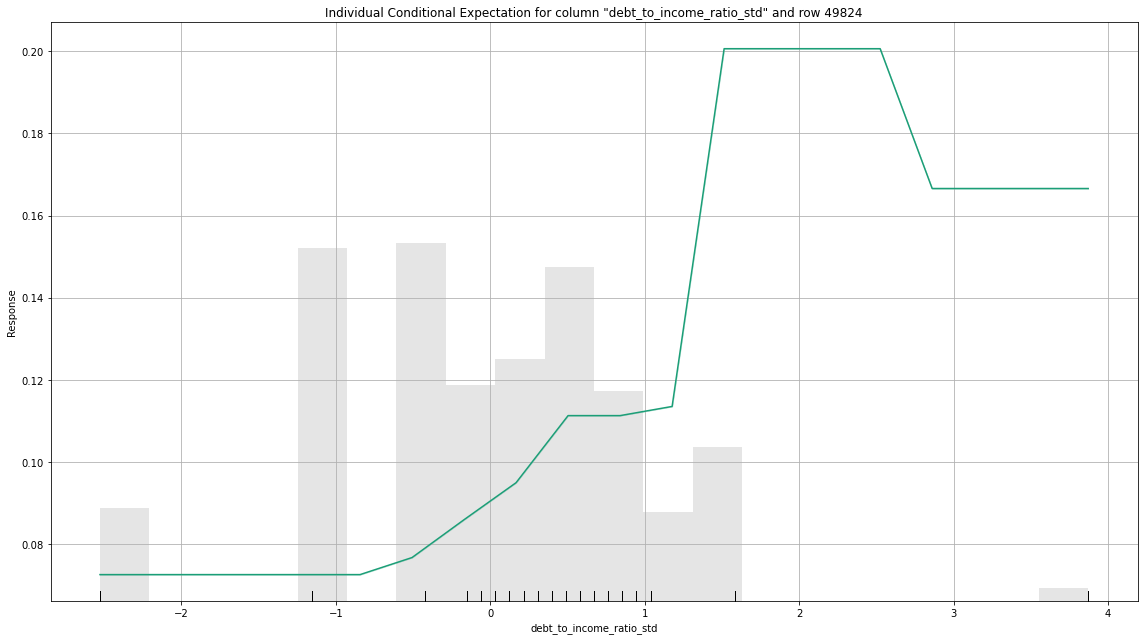

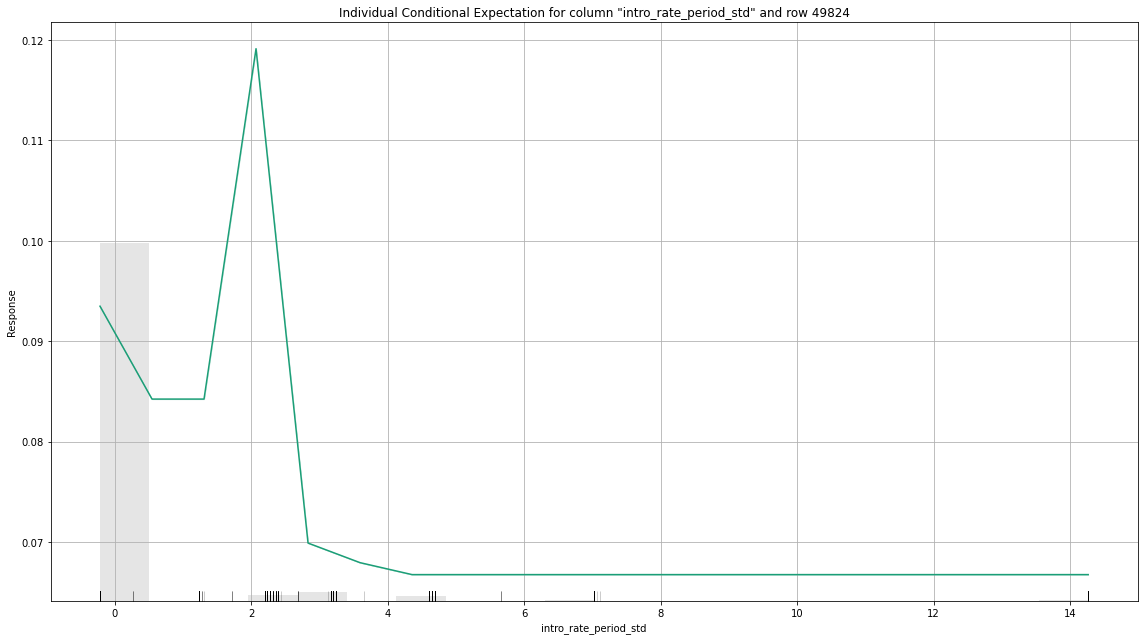

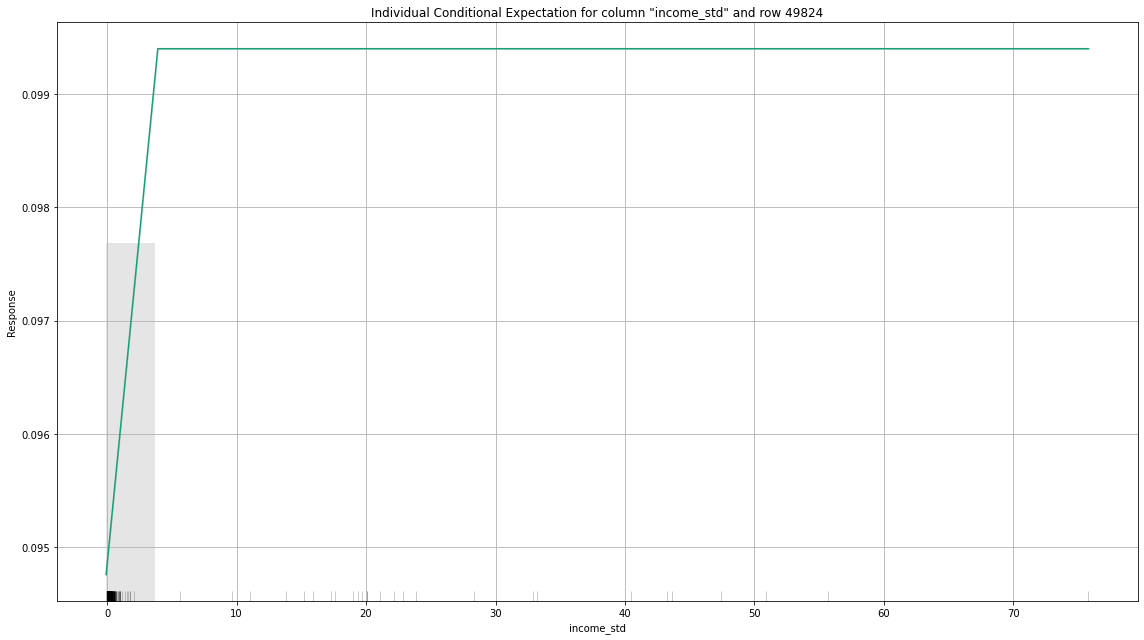

In [35]:
# Explain 90 percentile
gbm_h2o.explain_row(hvalid, row_index=int(ensenble_percentile_dict[90]))

## Calculate and Plot Feature Behavior.

### MGBM

In [36]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'mgbm':
        temp_df['partial_dependence'] = best_gbm.predict(h2o.H2OFrame(temp_df))['1.0'].as_data_frame()
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

In [37]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'mgbm'])
    first_pd = par_dep(name, valid[x_names], best_gbm, 'mgbm')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['mgbm'] = first_pd['partial_dependence']
    
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.
Partial dependence calculated in 785.88 s.


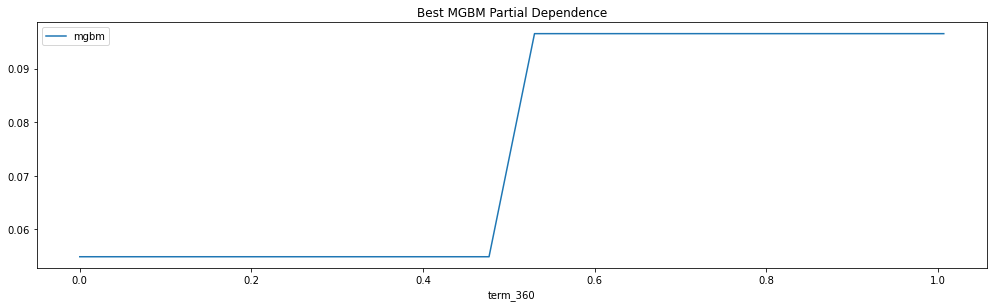

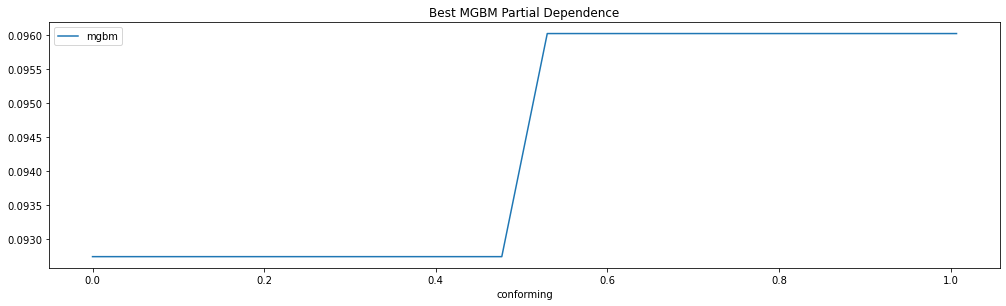

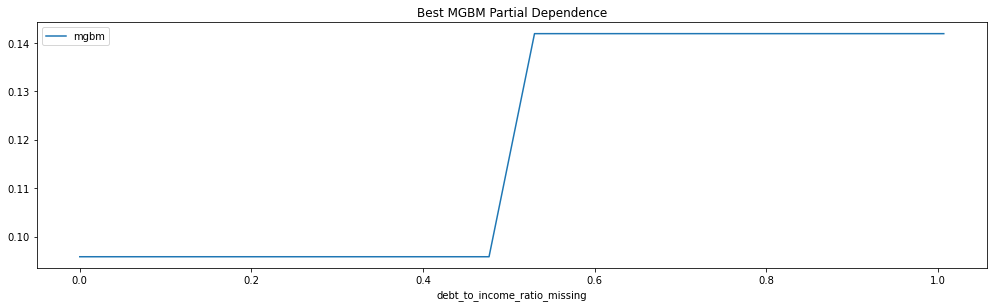

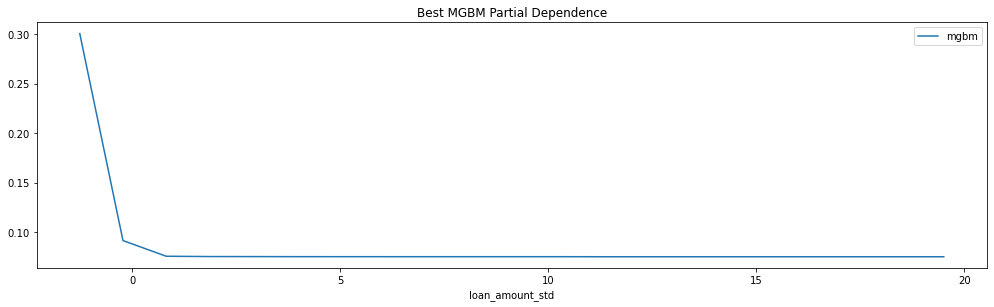

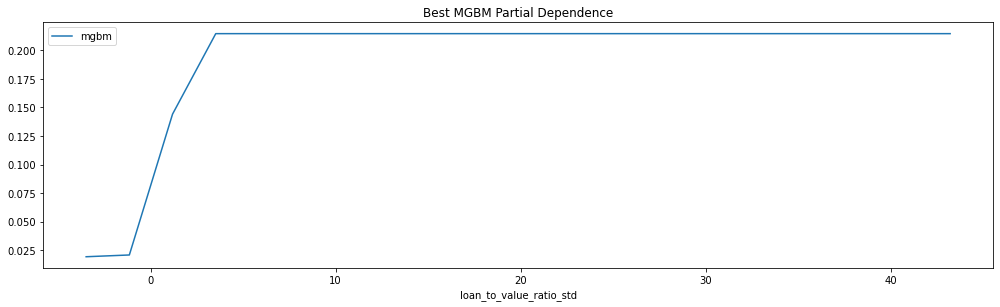

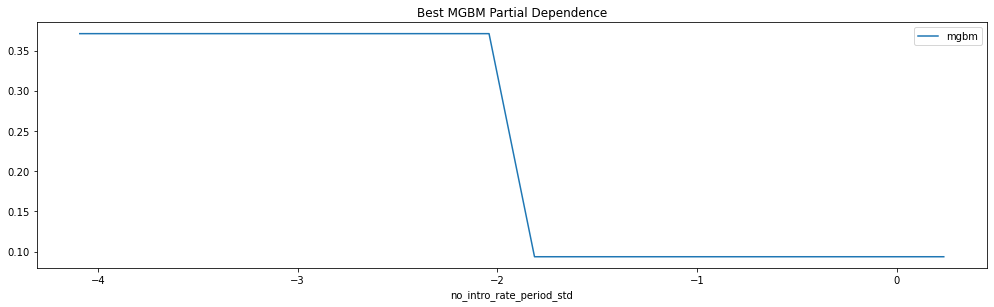

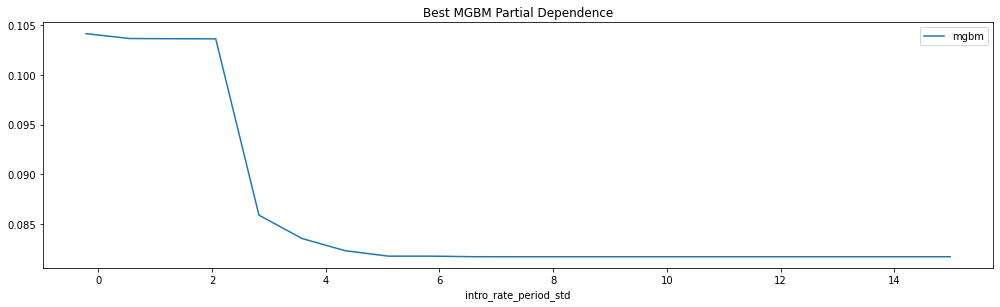

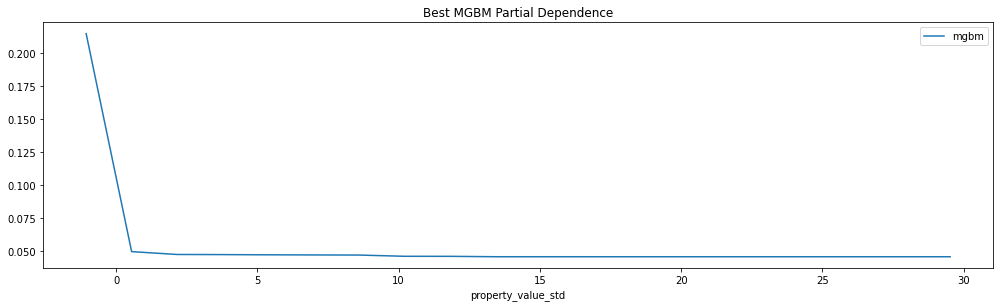

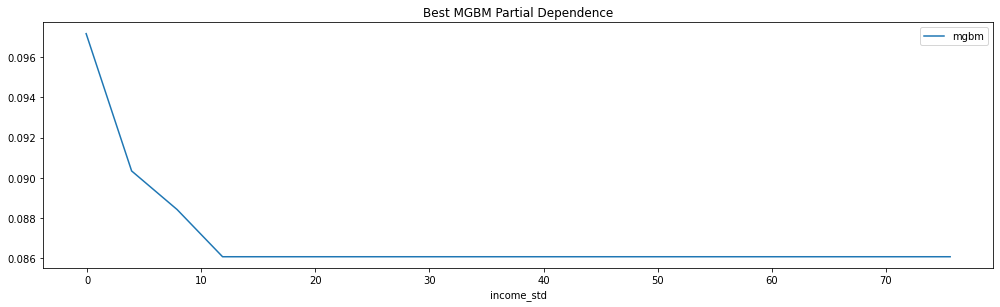

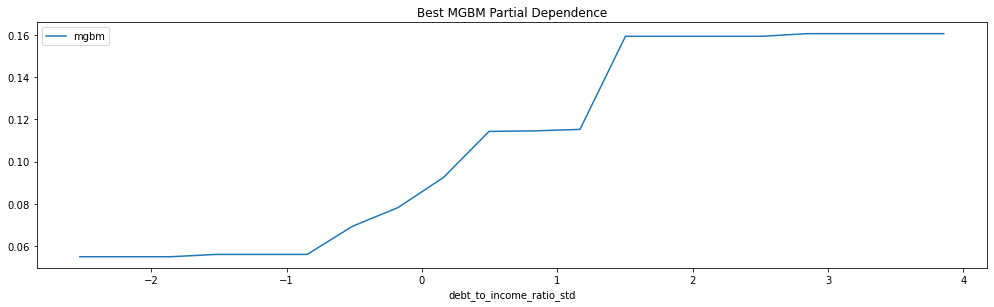

In [38]:
# loop through names to calculate par dep 
for name in x_names:
    
    # init 3-pane plot
    fig, (ax0) = plt.subplots(ncols=1, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='mgbm', ax=ax0, title='Best MGBM Partial Dependence')
    ax0.set_xlabel(name)
   

### GBM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_2_AutoML_20210609_082323


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16179220547030526: 


0.0      1.0   Error                 Rate
0    0.0  83984.0  17287.0  0.1707   (17287.0/101271.0)
1    1.0   4326.0   6534.0  0.3983     (4326.0/10860.0)
2  Total  88310.0  23821.0  0.1927   (21613.0/112131.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

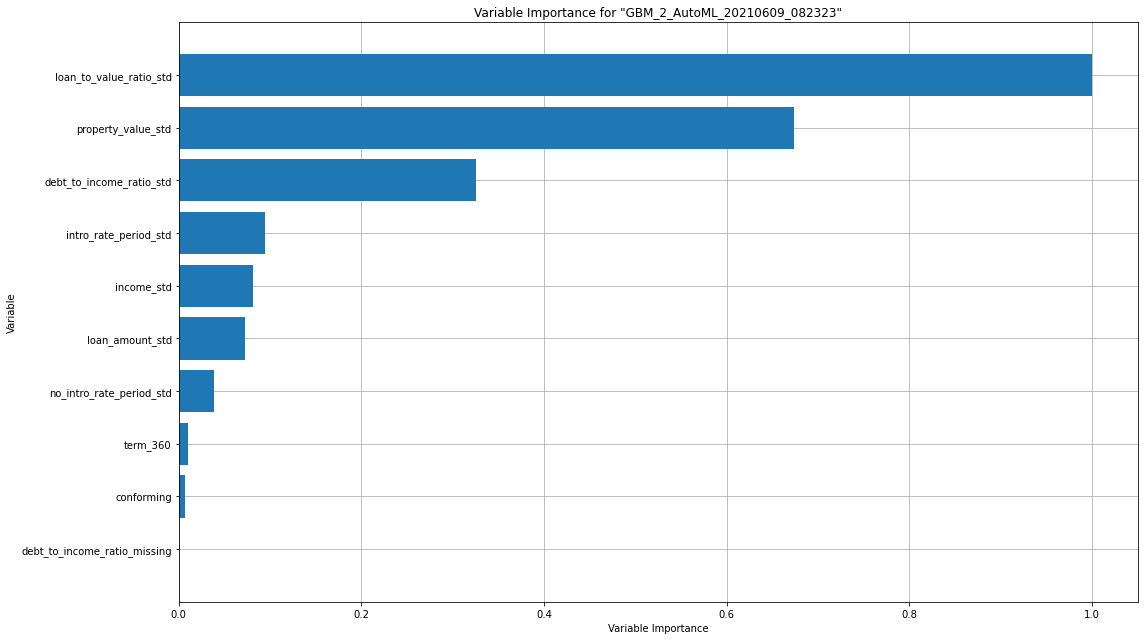

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

invalid value encountered in true_divide


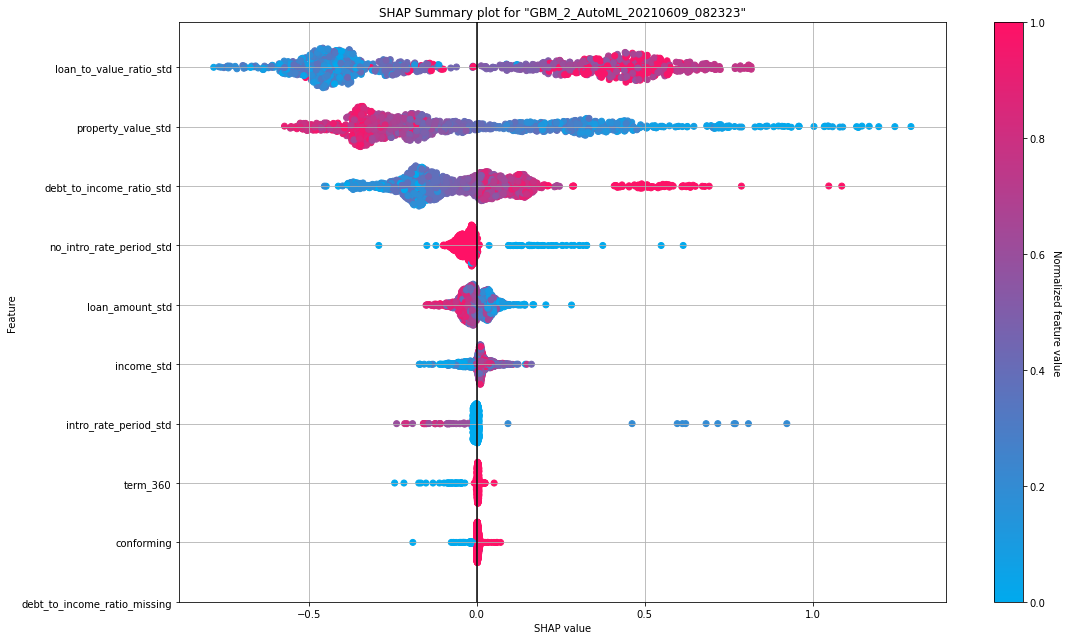

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

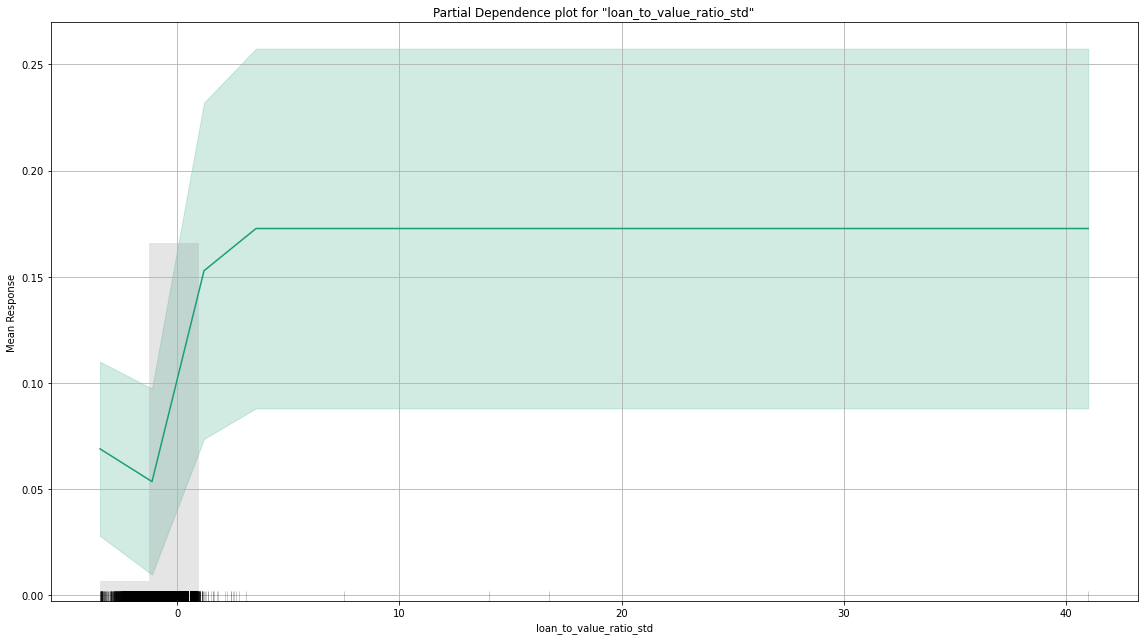

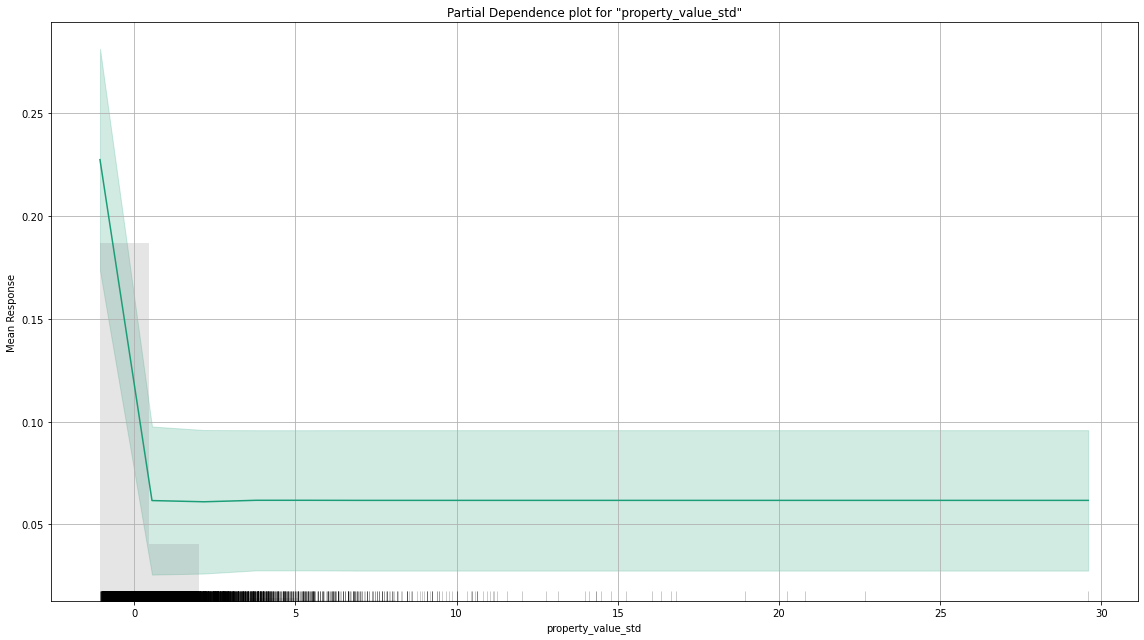

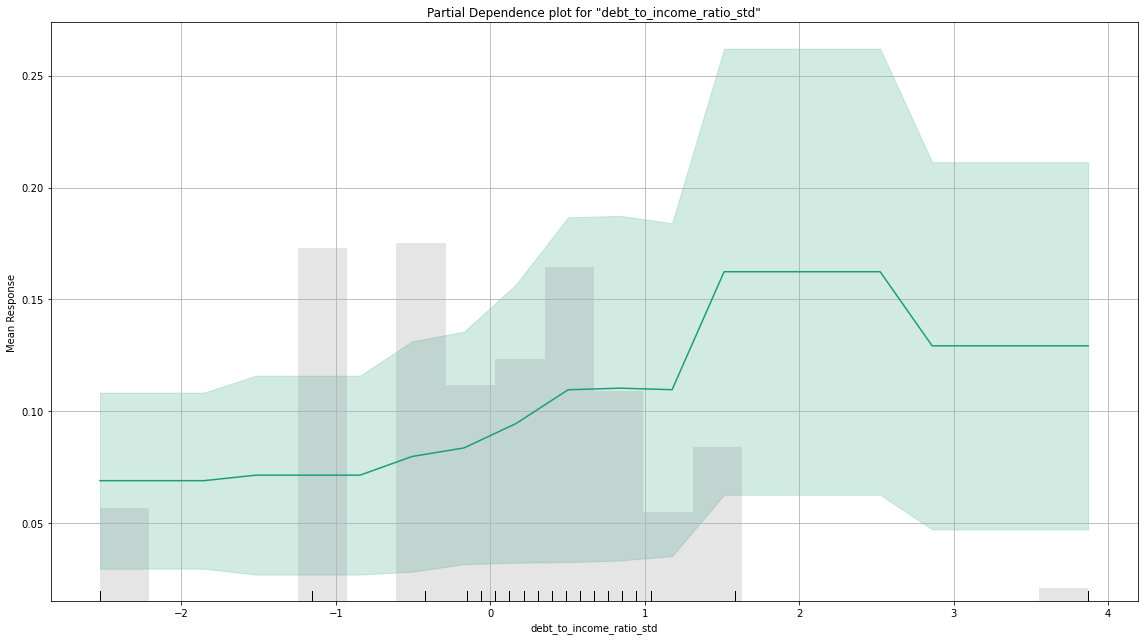

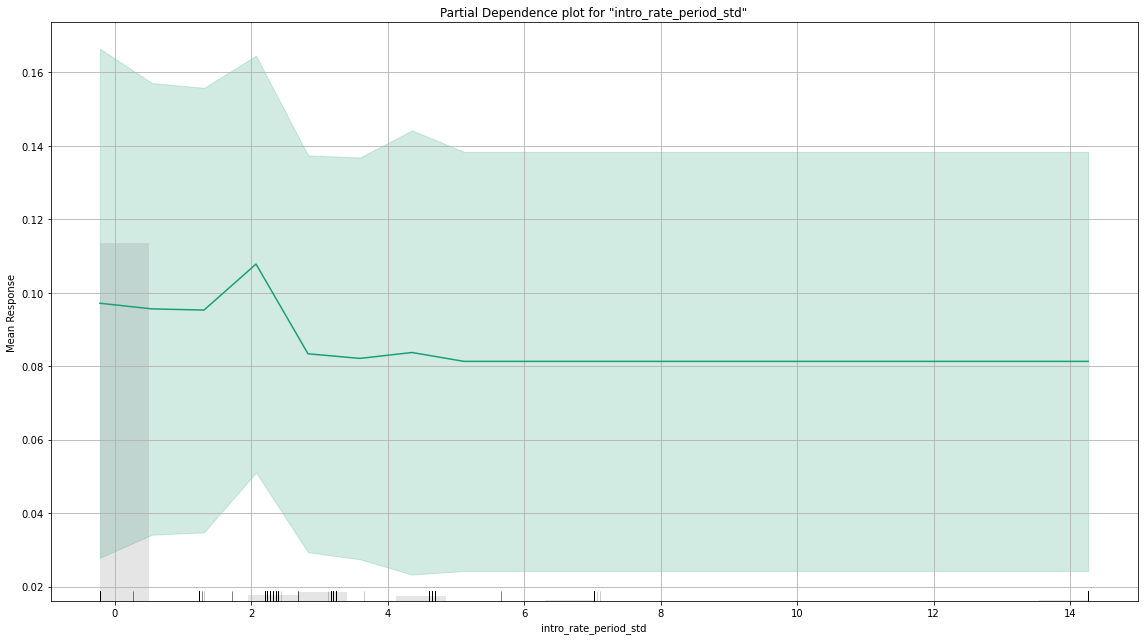

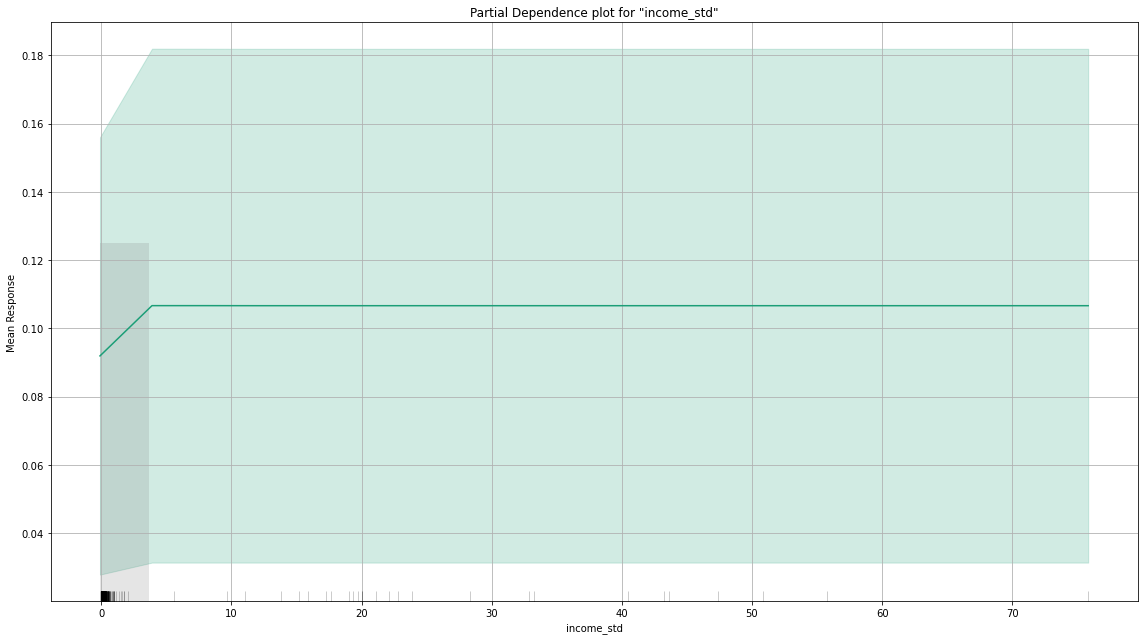

In [39]:
exa_gbm = gbm_h2o.explain(hvalid)

### Ensenble

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210609_082323


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1741866084526511: 


0.0     1.0   Error              Rate
0    0.0  7331.0  1608.0  0.1799   (1608.0/8939.0)
1    1.0   333.0   653.0  0.3377     (333.0/986.0)
2  Total  7664.0  2261.0  0.1956   (1941.0/9925.0)

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

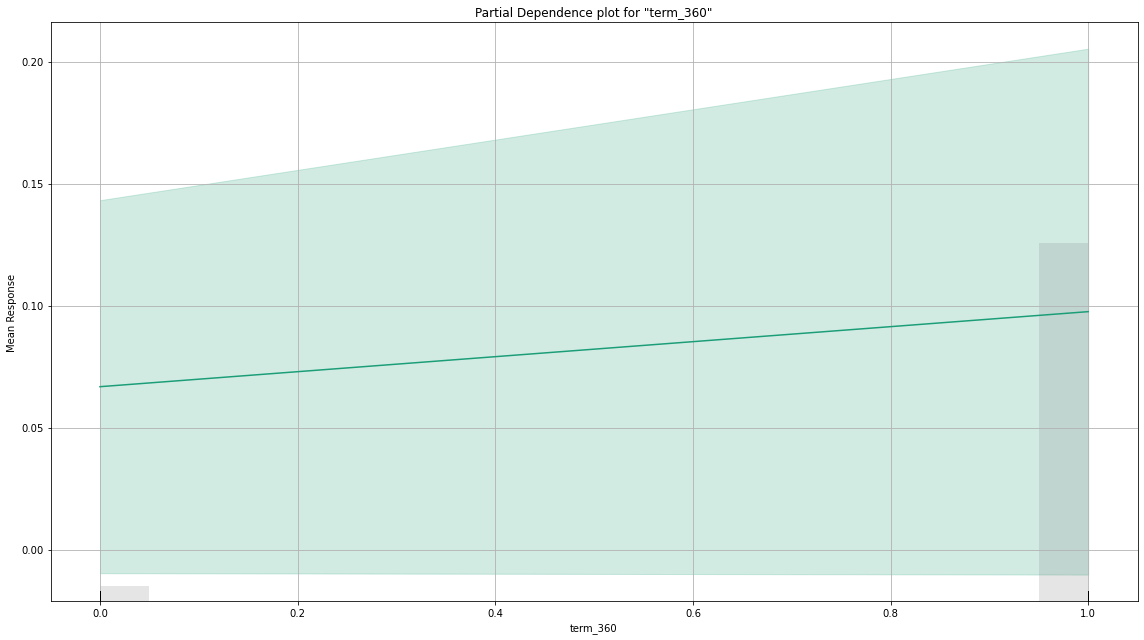

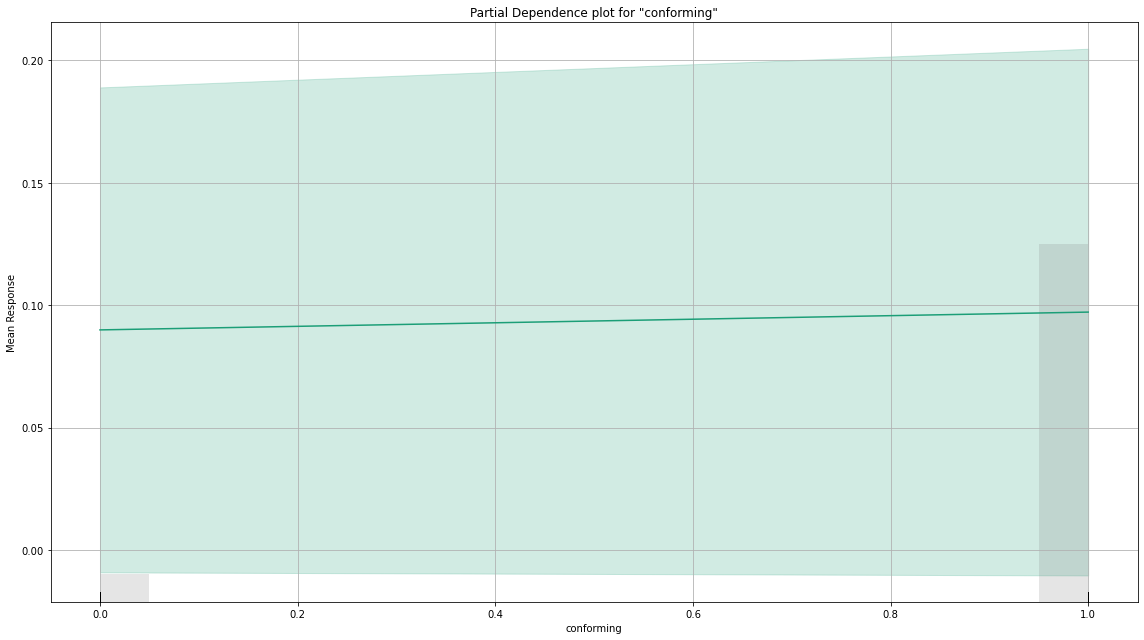

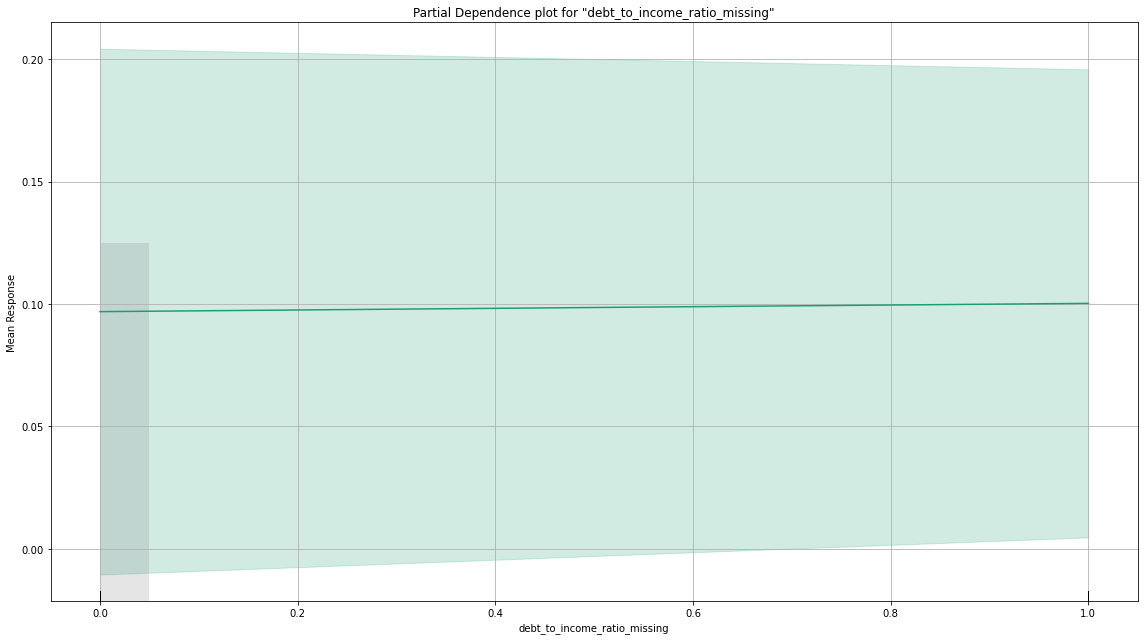

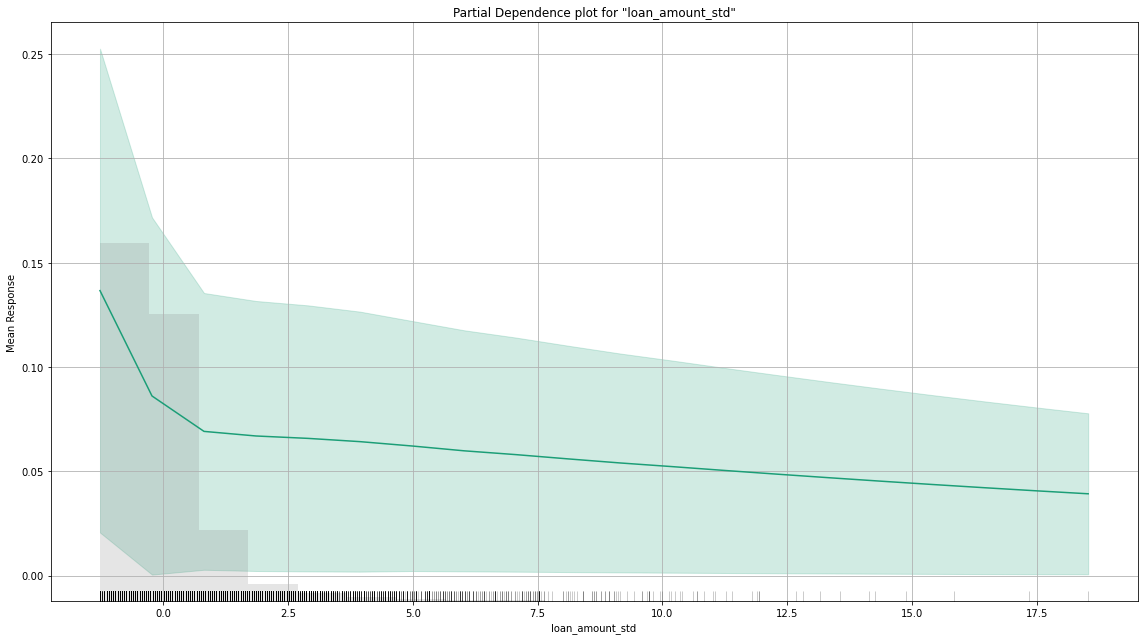

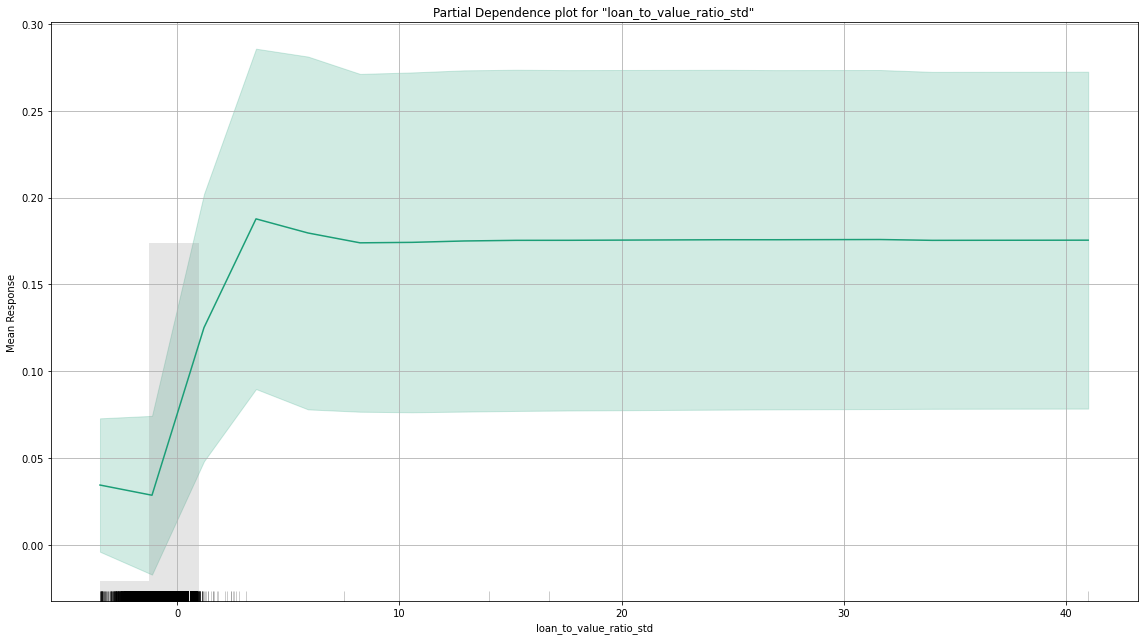

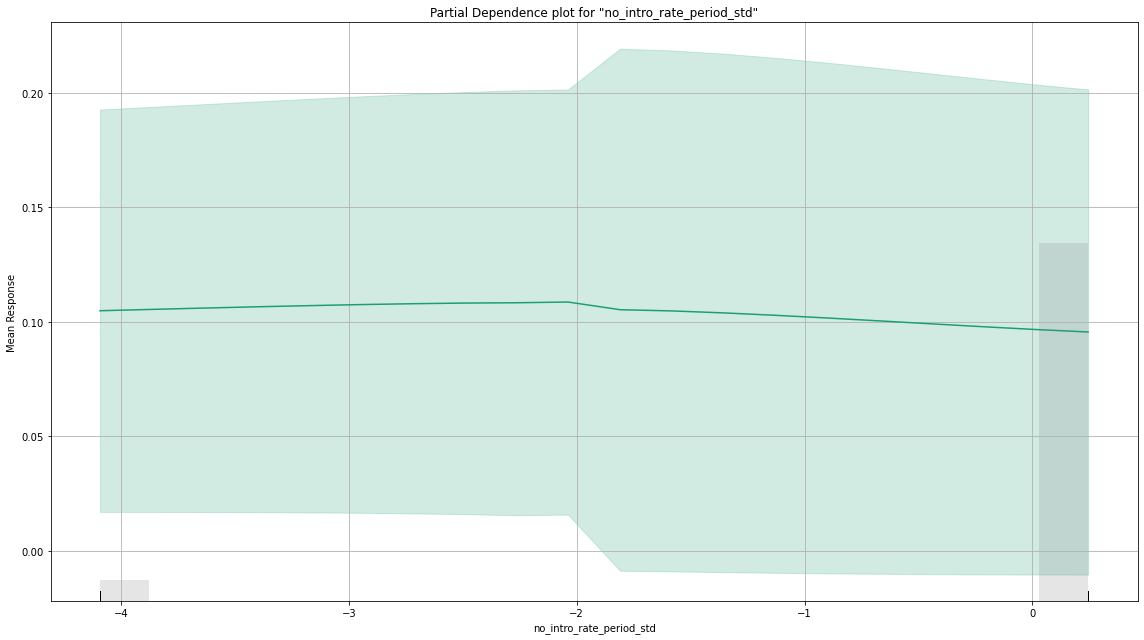

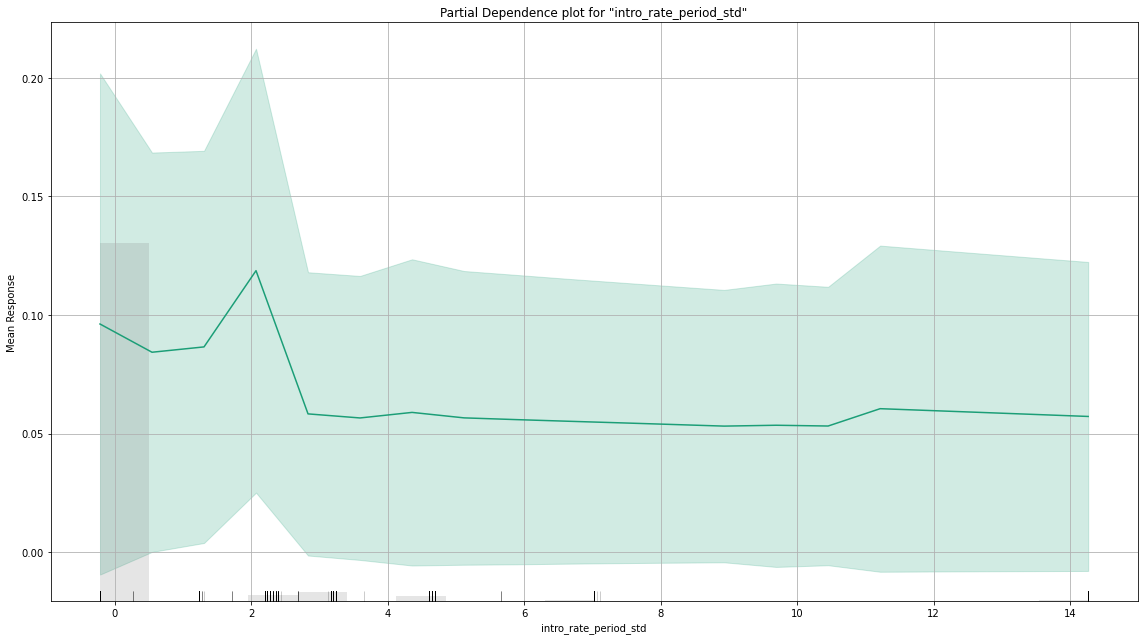

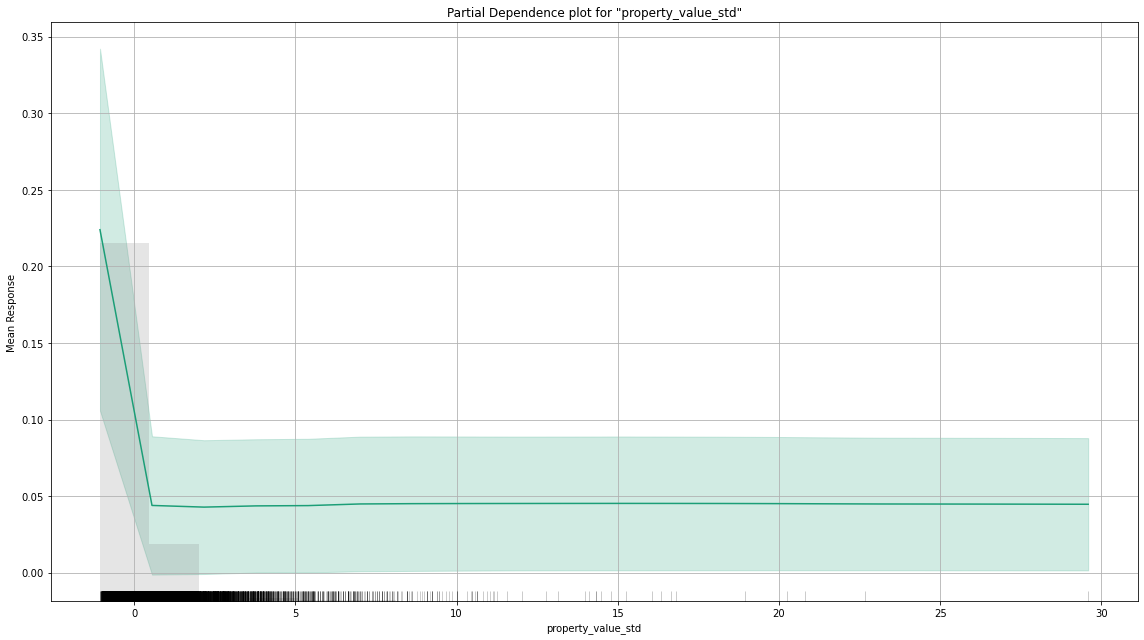

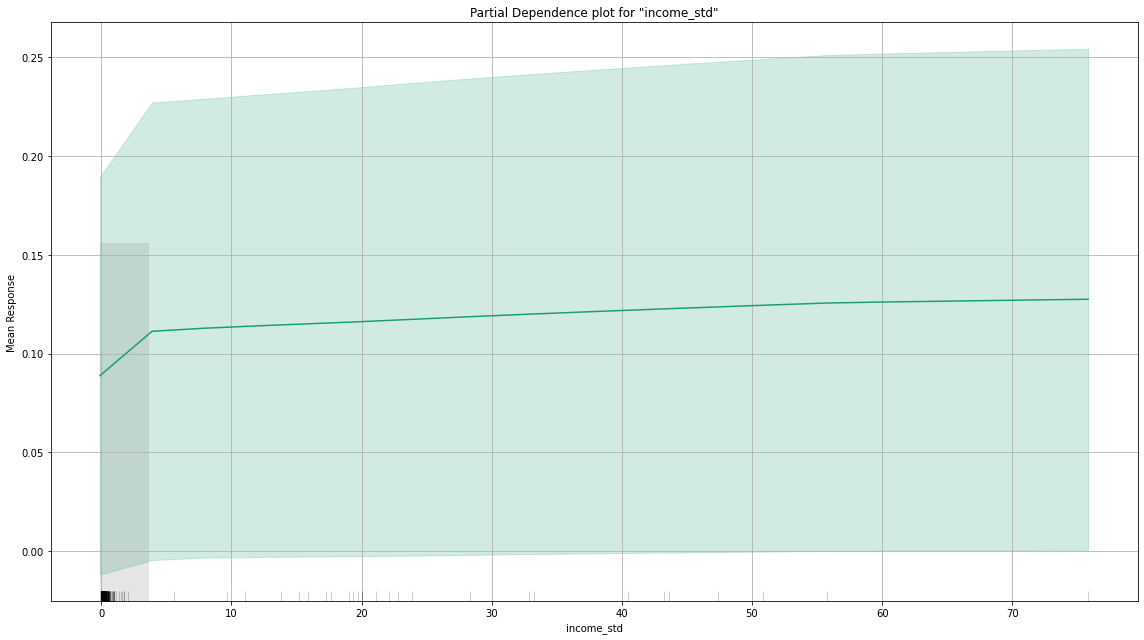

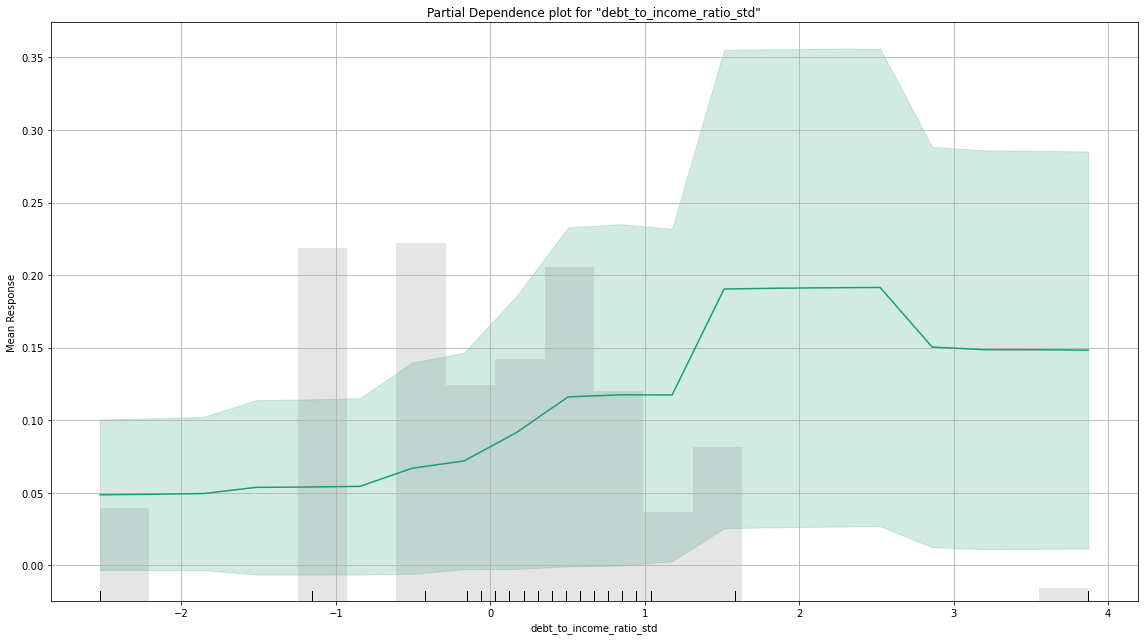

In [40]:
exa_ensenble = ensenble_h2o.explain(hvalid)

In [41]:
# end global timer 
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1629.33 s.


In [42]:
# shutdown h2o
h2o.cluster().shutdown(prompt=False)

H2O session _sid_b276 closed.
